<a href="https://colab.research.google.com/github/kikiymini/7506R-1C2024-GRUPO02/blob/main/7506R_TP1_GRUPO02_ENTREGA_N1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Organizaci&oacute;n de Datos</center>

#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1: Propiedades en venta</center>

### <center> Grupo 2</center>

## Integrantes:

*   Aramayo Carolina
*   Utrera Maximo Damian
*   Villalba Ana Daniela
*   Fiorilo Roy


# Importación de librerias

In [254]:
import pandas as pd
import numpy as np
import sklearn as sk

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
from folium.plugins import MarkerCluster
from mpl_toolkits.mplot3d import Axes3D

from shapely import wkt
from shapely.geometry import MultiPolygon, Polygon, Point

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

# Lectura de archivo

### Desde google drive

In [255]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = "/content/drive/MyDrive/7506R-1C2024-GRUPO02"
file_path = drive_path + '/Dataset/properati_argentina_2021.csv'
barrios_file = drive_path + '/Dataset/barrios.csv'
df = pd.read_csv(file_path)
using_drive = True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Desde maquina local

In [256]:
# Si se esta trabajando en local, descomentar esta celta y comentar la de arriba
# file_path = './dataset/properati_argentina_2021.csv'
# barrios_file = './dataset/barrios.csv'
# df = pd.read_csv(file_path)
# using_drive = False

In [257]:
df.head()

id  start_date    end_date  created_on    latitud  \
0  XZq2dFGxBiboHY3Bo/tqlw==  2021-09-09  2022-01-27  2021-09-09 -38.957632   
1  8afoK+yMH/rnnlYiktwgNA==  2021-09-09  2021-10-23  2021-09-09 -34.888878   
2  iVaG5rBB47dd1Ya4BMXREA==  2021-09-09  2022-03-09  2021-09-09 -32.488717   
3  QE1QVMWKAHWkd0qT0FtPWA==  2021-09-09  2022-01-27  2021-09-09 -34.900165   
4  tJ5lSk7IysG/71OGhacNZA==  2021-09-09  2022-01-27  2021-09-09 -38.954528   

    longitud    place_l2 place_l3 place_l4 place_l5  place_l6 operation  \
0 -68.105443     Neuquén      NaN      NaN      NaN       NaN     Venta   
1 -56.092368  Montevideo      NaN      NaN      NaN       NaN     Venta   
2 -58.257499  Entre Ríos      NaN      NaN      NaN       NaN     Venta   
3 -54.808453   Maldonado      NaN      NaN      NaN       NaN     Venta   
4 -68.041862     Neuquén      NaN      NaN      NaN       NaN     Venta   

  property_type  property_rooms  property_bedrooms  property_surface_total  \
0          Casa             6.0                NaN                     NaN   
1          Casa             4.0                3.0                   193.0   
2          Casa             NaN                NaN                   110.0   
3          Casa             NaN                3.0                     NaN   
4            PH             3.0                2.0                     NaN   

   property_surface_covered  property_price property_currency  \
0                     206.0             NaN               NaN   
1                     193.0        390000.0               USD   
2                      45.0         47000.0               USD   
3                     180.0        400000.0               USD   
4                      98.0        102000.0               USD   

       property_title  
0      Casa - Capital  
1       Casa - Malvín  
2      Casa - Uruguay  
3    Casa - El Chorro  
4  PH - Villa Farrell

In [258]:
df.shape

(460154, 20)

# Análisis Exploratorio y Pre-procesamiento de Datos

En esta sección vamos a filtrar y seleccionar los datos a trabajar a lo largo del proyecto.




## Filtrado

Se deben filtrar
únicamente los anuncios de propiedades de tipo vivienda ( Casa, PH y Departamento ) ubicados
en Capital Federal cuyo tipo de operación sea venta y su precio se encuentre en dólares (USD).

En la etapa de filtrado, vamos a utilizar la funcionalidad de `str.contains()` de pandas. Este código se basa en la documentación oficial de pandas que puedes encontrar en [este enlace](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.contains.html).


In [259]:
df["property_type"].value_counts()

property_type
Departamento       231358
Casa               120768
Lote                28748
PH                  25910
Local comercial     20546
Oficina             16085
Otro                 7713
Cochera              4111
Depósito             4050
Casa de campo         865
Name: count, dtype: int64

In [260]:
# filtro por tipo de propiedad
# str.contains() se utiliza para buscar patrones de texto dentro de las cadenas en una serie.
# USD: indica el patrón que busco
# case: no distingue entre mayúsculas y minúsculas
# na: no registro valores NaN
filtro = df.property_type.str.contains('Casa|PH|Departamento',case=False,na=False)
ds_propiedades_filtradas = df[filtro]
ds_propiedades_filtradas = ds_propiedades_filtradas[~ds_propiedades_filtradas['property_type'].str.contains('Casa de campo')]

In [261]:
df["place_l2"].value_counts().head() # Hay muchas ubicaciones

place_l2
Capital Federal             157563
Bs.As. G.B.A. Zona Norte     89693
Santa Fe                     47861
Bs.As. G.B.A. Zona Sur       47754
Bs.As. G.B.A. Zona Oeste     28352
Name: count, dtype: int64

In [262]:
# filtro propiedades en Capital Federal
filtro = ds_propiedades_filtradas.place_l2.str.contains('Capital Federal',case=False,na=False)
ds_propiedades_filtradas = ds_propiedades_filtradas[filtro]

In [263]:
df["operation"].value_counts()

operation
Venta                337874
Alquiler              98900
Alquiler temporal     23380
Name: count, dtype: int64

In [264]:
# filtro propiedades en venta
filtro = ds_propiedades_filtradas.operation.str.contains('Venta',case=False,na=False)
ds_propiedades_filtradas = ds_propiedades_filtradas[filtro]

In [265]:
df["property_currency"].value_counts()

property_currency
USD    349104
ARS     88869
UYU      3506
PEN        99
COP        12
Name: count, dtype: int64

In [266]:
# filtro por moneda DÓLAR
filtro = ds_propiedades_filtradas.property_currency.str.contains('USD',case=False,na=False)
ds_propiedades_filtradas = ds_propiedades_filtradas[filtro]

In [267]:
# DataSet filtrado
ds_propiedades_filtradas.head()

id  start_date    end_date  created_on    latitud  \
25  CyZu6IaZgmQYGk8jmPajCg==  2021-09-09  2021-09-26  2021-09-09        NaN   
42  d3Z0MblSb2IMBoOBMGJEEQ==  2021-09-09  2021-09-26  2021-09-09 -34.637319   
43  rL7qPkQnomsMGu2ViS3sBw==  2021-09-09  2021-09-28  2021-09-09 -34.628647   
49  vuX/ccLAMVml4qWRFcOJUA==  2021-09-09  2022-01-05  2021-09-09 -34.610027   
51  ZTtSCeqZ3HUgf5jjwEzRcw==  2021-09-09  2022-03-09  2021-09-09 -34.631621   

     longitud         place_l2 place_l3 place_l4 place_l5  place_l6 operation  \
25        NaN  Capital Federal      NaN      NaN      NaN       NaN     Venta   
42 -58.361124  Capital Federal     Boca      NaN      NaN       NaN     Venta   
43 -58.361871  Capital Federal     Boca      NaN      NaN       NaN     Venta   
49 -58.401934  Capital Federal     Once      NaN      NaN       NaN     Venta   
51 -58.416825  Capital Federal    Boedo      NaN      NaN       NaN     Venta   

   property_type  property_rooms  property_bedrooms  property_surface_total  \
25          Casa             4.0                3.0                   171.0   
42  Departamento             3.0                2.0                    58.0   
43  Departamento             4.0                3.0                    70.0   
49  Departamento             4.0                2.0                     NaN   
51            PH             4.0                2.0                     NaN   

    property_surface_covered  property_price property_currency  \
25                     133.0        210000.0               USD   
42                      55.0         82900.0               USD   
43                      70.0         99000.0               USD   
49                     104.0        146000.0               USD   
51                      73.0        250000.0               USD   

                                 property_title  
25  VENTA CASA LLAVE EN MANO - COSTA ESMERALDA   
42       VENTA TRES AMBIENTES LA BOCA PISO ALTO  
43   Departamento - 4 Ambientes - Catalinas Sur  
49          Venta departamento 4 ambientes Once  
51                                   PH - Boedo

In [268]:
ds_propiedades_filtradas.shape

(94249, 20)

## Exploración Inicial

### Medidas de resumen de las variables cuantitativas del Dataset

In [269]:
# Creo resumen con describe
ds_resumen = ds_propiedades_filtradas.describe()
# Agrego moda a la tabla resumen
ds_resumen.loc['mode'] = ds_propiedades_filtradas.mode().iloc[0]
ds_resumen


latitud      longitud  place_l6  property_rooms  \
count  90519.000000  90519.000000       0.0    93205.000000   
mean     -34.591481    -58.449795       NaN        2.822799   
std        0.181719      0.292630       NaN        1.426148   
min      -53.788624    -71.471192       NaN        1.000000   
25%      -34.615975    -58.466522       NaN        2.000000   
50%      -34.595790    -58.439000       NaN        3.000000   
75%      -34.577413    -58.408862       NaN        4.000000   
max      -24.219827    -54.133330       NaN       40.000000   
mode     -34.541250    -58.472966       NaN        3.000000   

       property_bedrooms  property_surface_total  property_surface_covered  \
count       83262.000000            89405.000000              90895.000000   
mean            2.014629              109.092970                 87.931932   
std             1.129767              980.401976                990.927129   
min            -1.000000               10.000000                  1.000000   
25%             1.000000               45.000000                 40.000000   
50%             2.000000               65.000000                 58.000000   
75%             3.000000              105.000000                 88.000000   
max            70.000000           137000.000000             217000.000000   
mode            1.000000               50.000000                 40.000000   

       property_price  
count    9.424900e+04  
mean     2.262382e+05  
std      3.186035e+05  
min      5.000000e+03  
25%      9.500000e+04  
50%      1.439000e+05  
75%      2.370000e+05  
max      2.140000e+07  
mode     1.100000e+05

En esta tabla resumen se pueden apreciar (en orden):

* El recuento de las entradas validas por atributo.
* El mean de cada atributo.
* La desviacion estandar.
* El valor minimo de cada atributo.
* El percentil 25.
* El percentil 50.
* El percentil 75.
* El valor maximo de cada atributo.
* La moda de cada atributo.

Tambien se pueden ver algunos valores atipicos como el hecho que hay alguna propiedad con 36 ambientes y 32 habitaciones, o -1 habitaciones, o tambien el minimo de las longitudes que pareciera estar fuera de CABA. Estos seran abarcados en su correspondiente seccion (valores atipicos).

### Cantidad de valores posibles para cada variable cualitativo

In [270]:
# Mostrar la cantidad de valores posibles para cada variable cualitativa
variables_cualitativas = [
    'property_type',
    'operation',
    'property_currency',
    'start_date',
    'end_date',
    'created_on',
    'place_l2',
    'place_l3',
    'place_l4',
    'place_l5',
    'place_l6',
    ]
ds_propiedades_filtradas[variables_cualitativas].nunique()

property_type          3
operation              1
property_currency      1
start_date           365
end_date             607
created_on           365
place_l2               1
place_l3              57
place_l4               4
place_l5               0
place_l6               0
dtype: int64

**Notar que las columnas place l5 y l6 son completamente nulas, retomaremos eso mas adelante**

### Frecuencia de los valores posibles de variables cualitativas

En un grafico de barras se veran las frecuencias de los valores posibles para los atributos cualitativos mas importantes y donde hay mas de 1 alternativa, es decir no se tomara por ejemplo *place_l2* porque se sabe que por el filtro el 100% de los valores sera 'Capital Federal', asi mismo para *operation* que sera 'Venta' y *property_currency* que sera 'USD'.

* place_l3 (los 15 mas frecuentes)
* place_l4
* property_type

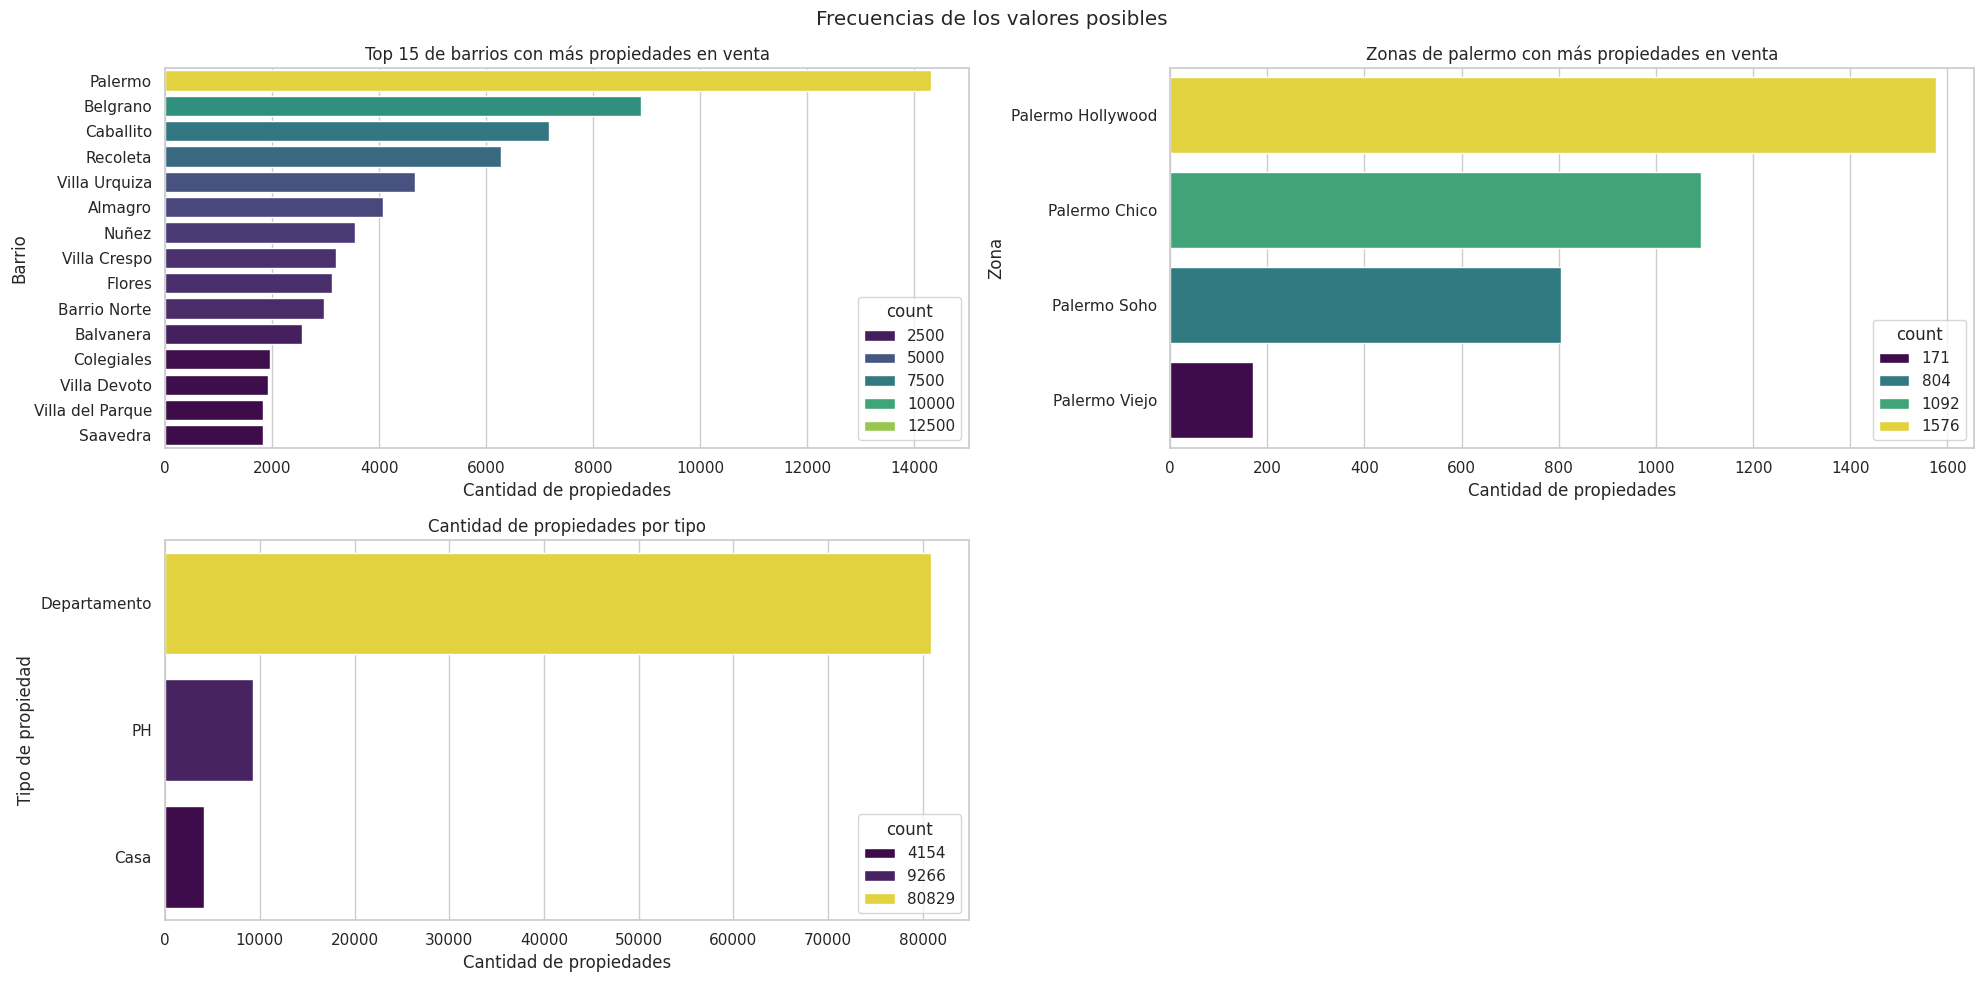

In [271]:
plt.figure(figsize=(20, 10)) # 10x10 inches
plt.suptitle('Frecuencias de los valores posibles')

# bar plot por place_l3
plt.subplot(2, 2, 1) # 2 filas, 2 columnas, 1 posicion
frecuencias_place_3 = ds_propiedades_filtradas["place_l3"].value_counts().head(15)
sns.barplot(x=frecuencias_place_3.values, y=frecuencias_place_3.index, hue=frecuencias_place_3, palette='viridis')
plt.title('Top 15 de barrios con más propiedades en venta')
plt.xlabel('Cantidad de propiedades')
plt.ylabel('Barrio')

# bar plot por place_l4
plt.subplot(2, 2, 2) # 2 filas, 2 columnas, 2 posicion
frecuencias_place_4 = ds_propiedades_filtradas["place_l4"].value_counts()
sns.barplot(x=frecuencias_place_4.values, y=frecuencias_place_4.index, hue=frecuencias_place_4, palette='viridis')
# Ya que los 4 valores posibles pertenecen a Palermo
plt.title('Zonas de palermo con más propiedades en venta')
plt.xlabel('Cantidad de propiedades')
plt.ylabel('Zona')

# bar plot por property_type
plt.subplot(2, 2, 3) # 2 filas, 2 columnas, 3 posicion
frecuencias_property_type = ds_propiedades_filtradas["property_type"].value_counts()
sns.barplot(x=frecuencias_property_type.values, y=frecuencias_property_type.index, hue=frecuencias_property_type, palette='viridis')
plt.title('Cantidad de propiedades por tipo')
plt.xlabel('Cantidad de propiedades')
plt.ylabel('Tipo de propiedad')

plt.tight_layout()
plt.show()

*Anotacion: todos los place_l4 que no son NaN son zonas de palermo.*

### Variables irrelevantes para el analisis

Las variables que se pueden considerar irrelevantes para el analisis que se les dara son:

* **ID**: no aporta informacion para analizar, sin embargo puede ser util para propositos de manejo de datos.
* **Place_l2**: siempre son capital federal debido al primer filtro
* **Place_l5/l6**: no tienen ningun valor en ningun registro lo que los hace innecesarios.
* **Operation**: debido a el pre-procesamiento de los datos todos los registros tendran una operacion de venta, es decir que este atributo pasa a ser redundante.
* **Property_currency**: similarmente como pasa con *operation* pasa con este otro atributo, es un atributo redundante ya que todos seran USD.
* **Property_title**: no aporta informacion relevante al analisis.
* **Latitud/Longitud**: como ya se tiene el barrio de la propiedad en place_l2 esta informacion puede o no ser relevante dependiendo si se quiere ver la ubicacion exacta o si se quiere validar el barrio.
* **Variables de fechas (start/end/created)**: estas variables podrian ser utiles si se hace un analisis por ejemplo para ver cuales son las fechas donde mas ventas empiezan/terminan, de lo contrario no es relevante. Pero la variable de creacion, en que se diferencia de la de comienzo? lo veremos en breve.

#### En sintesis

En base a lo anterior dicho se toma la decision de dejar de contar con los atributos:

* place_l2
* place_l5/l6 (se abordara en la seccion de datos faltantes)
* operation
* property_currency
* property title

In [272]:
# Nuevo filtro para eliminar dichas columnas
columnas_a_eliminar = ['place_l2', 'operation', 'property_currency', 'property_title']
ds_propiedades_filtradas.drop(columns = columnas_a_eliminar,inplace=True)

Comparacion de start time y creation time

In [273]:
(ds_propiedades_filtradas['start_date'] == ds_propiedades_filtradas['created_on']).value_counts()

True    94249
Name: count, dtype: int64

Son exactamente iguales, por lo tanto borro una

In [274]:
ds_propiedades_filtradas.drop(columns=['created_on'], inplace=True)

### Analisis grafico de distribucion de variables mas relevantes

* distribucion de precios
* distribucion de publicaciones por mes
* distribucion de habitaciones y dormitorios

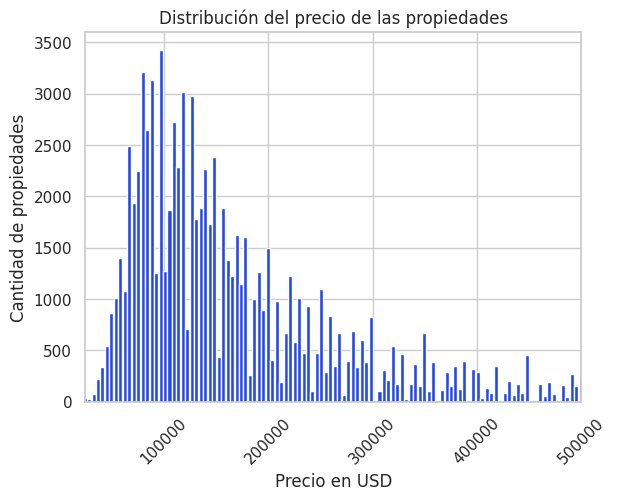

In [275]:
# plot de distribucion de property_price

plt.hist(data=ds_propiedades_filtradas,x="property_price",bins=5000, color="#2348F0",rwidth=0.9)
plt.xlim(25000,500000)
plt.xlabel("Precio en USD")
plt.ylabel("Cantidad de propiedades")
plt.title("Distribución del precio de las propiedades")
plt.xticks(rotation=45)

plt.show()

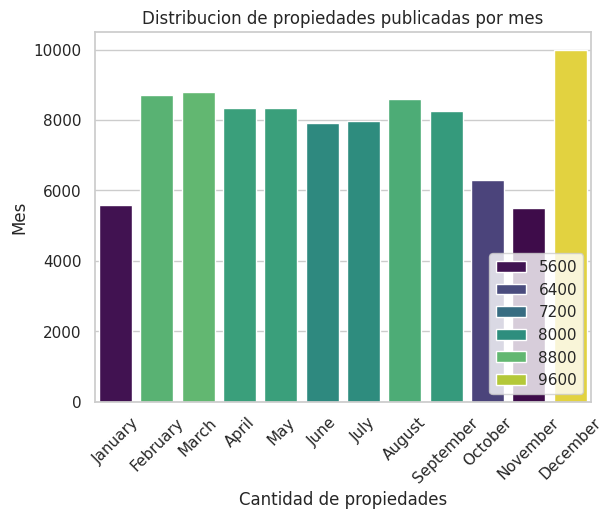

In [276]:
# bar plot distribucion de ventas por mes

ds_propiedades_filtradas["start_date"] = pd.to_datetime(ds_propiedades_filtradas["start_date"])
meses = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
frecuencias_mes = ds_propiedades_filtradas["start_date"].dt.month_name().value_counts().reindex(meses)
sns.barplot(x=frecuencias_mes.index, y=frecuencias_mes.values, hue=frecuencias_mes, palette='viridis')
plt.legend(loc='lower right')
plt.title('Distribucion de propiedades publicadas por mes')
plt.xlabel('Cantidad de propiedades')
plt.ylabel('Mes')
plt.xticks(rotation=45)

plt.show()

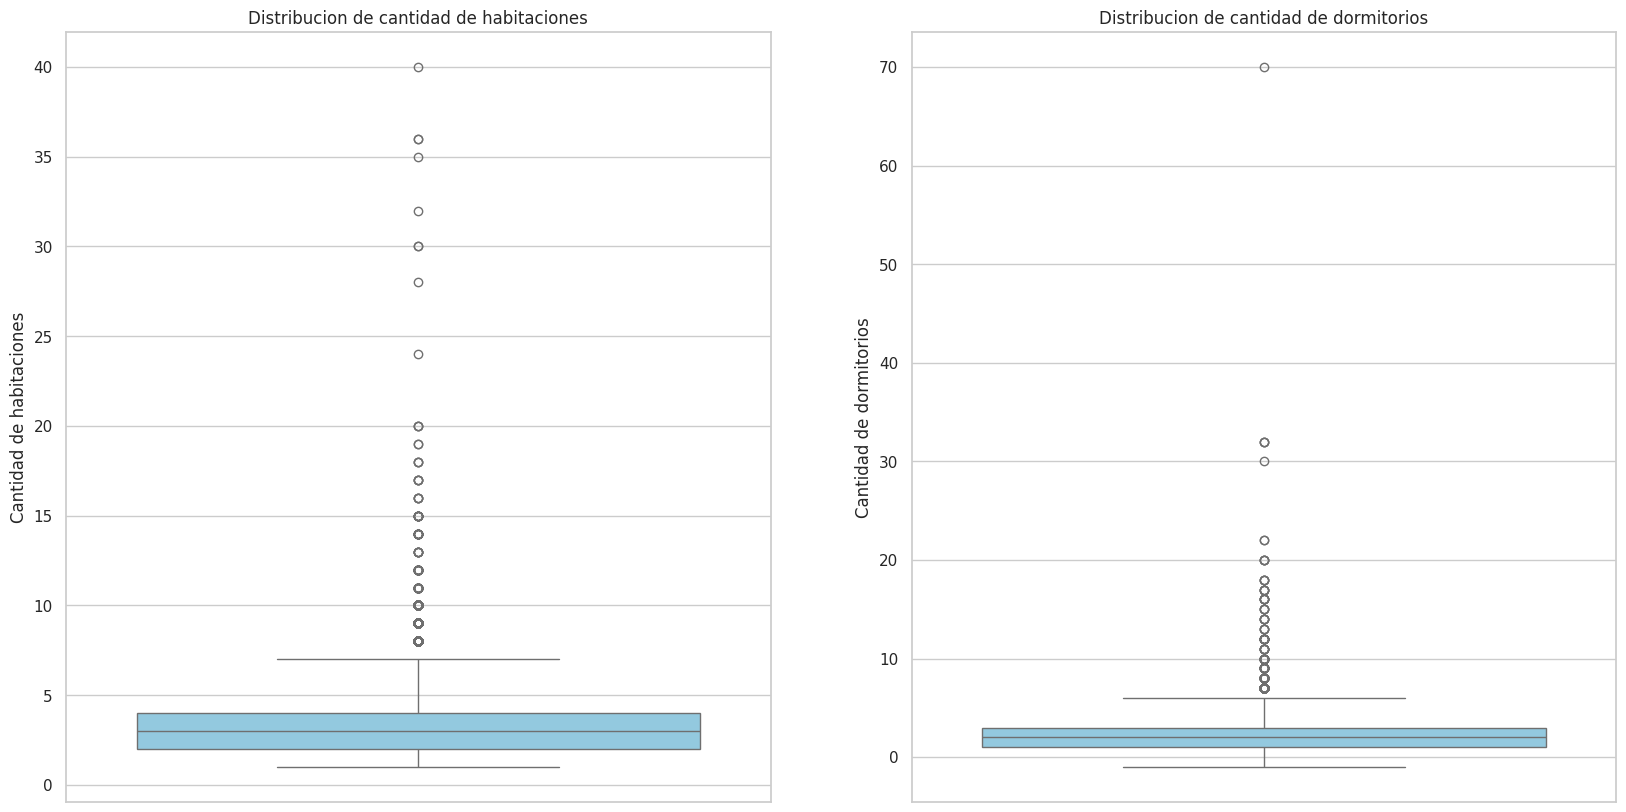

In [277]:
# Boxplot de property_rooms y property_bedrooms
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1) # 1 fila, 2 columnas, 1 posicion
sns.boxplot(data=ds_propiedades_filtradas, y='property_rooms', color='skyblue')
plt.title('Distribucion de cantidad de habitaciones')
plt.ylabel('Cantidad de habitaciones')

plt.subplot(1, 2, 2) # 1 fila, 2 columnas, 2 posicion
sns.boxplot(data=ds_propiedades_filtradas, y='property_bedrooms', color='skyblue')
plt.title('Distribucion de cantidad de dormitorios')
plt.ylabel('Cantidad de dormitorios')

plt.show()

### Analisis de correlaciones existentes entre variables

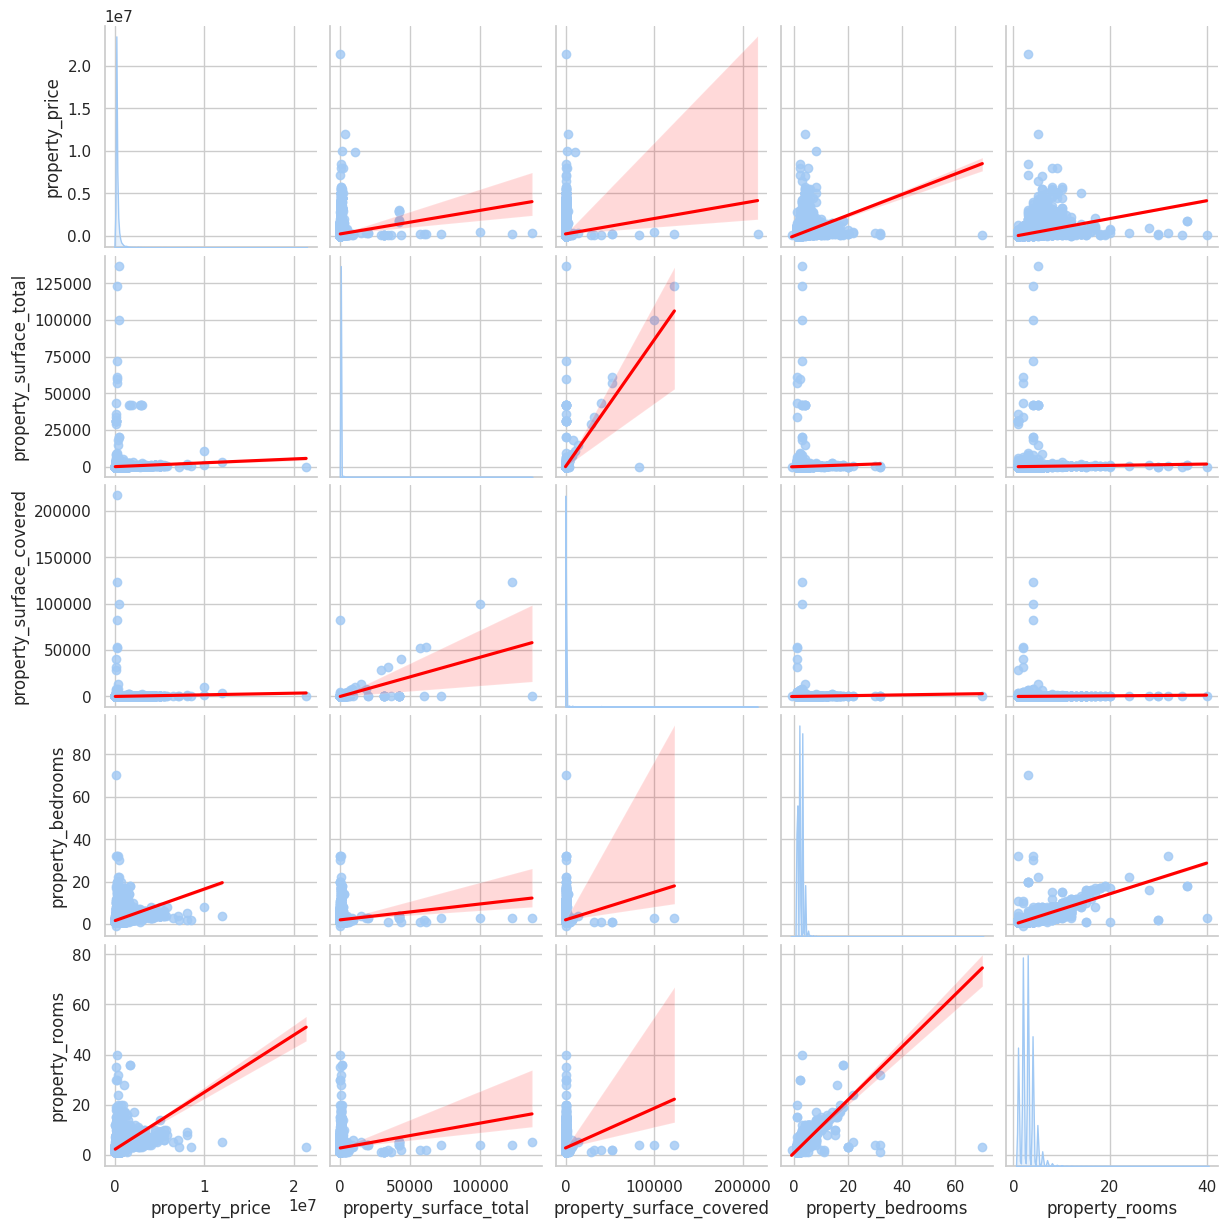

In [278]:
# pairplot con price, surface_total, surface_covered, bedrooms, rooms
sns.pairplot(ds_propiedades_filtradas[['property_price', 'property_surface_total', 'property_surface_covered', 'property_bedrooms', 'property_rooms']], diag_kind='kde', kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.show()

Observando este grafico de relaciones se pueden ver que algunas de estas variables tienen claramente una relacion y otras no tanto.

* La relacion entre la **superficie total** y **superficie cubierta** es lineal y acendente, es decir da la impresion que una dependiera de la otra, y si se piensa logicamente esto tiene sentido (si hay mas espacio se cubre mas espacio) aunque no siempre es necesariamente el caso (puede haber una casa pequeña en un terreno grande)
* La relacion entre el **precio** y la cantidad de **habitaciones** y **dormitorios**, en esta se puede notar que a mas habitaciones y/o dormitorios mas aumenta el maximo precio pero no deja de haber precios mas bajos, sin embargo, pasada una cierta cantidad (aproximadamente ~15) el precio deja de aumentar y mas bien se queda constante (entre los valores hasta ~250,000 USD)
* La relacion entre **habitaciones** y **dormitorios** tambien es lineal y acendente, lo cual puede deberse a que cuando una casa tiene muchas habitaciones esta probablemente tenga tambien muchos dormitorios.

*Extra: hay ciertos valores outliers que pueden afectar a la correlacion entre variables por ejemplo una propiedad con mas de 60 habitaciones, estos seran analizados en la seccion de valores atipicos*

Para hacer un analisis mas profundo de estos datos se analiza la *covarianza* y *correlacion* entre las variables usadas en la figura anterior:

In [279]:
# covarianza y correlacion entre property_surface_total y property_surface_covered
covariance = ds_propiedades_filtradas['property_surface_total'].cov(ds_propiedades_filtradas['property_surface_covered'])
correlation = ds_propiedades_filtradas['property_surface_total'].corr(ds_propiedades_filtradas['property_surface_covered'])
print(f'Surface Total vs Surface Covered\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

# covarianza y correlacion entre price y property_rooms
covariance = ds_propiedades_filtradas['property_price'].cov(ds_propiedades_filtradas['property_rooms'])
correlation = ds_propiedades_filtradas['property_price'].corr(ds_propiedades_filtradas['property_rooms'])
print(f'Price vs Rooms\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

# covarianza y correlacion entre price y property_bedrooms
covariance = ds_propiedades_filtradas['property_price'].cov(ds_propiedades_filtradas['property_bedrooms'])
correlation = ds_propiedades_filtradas['property_price'].corr(ds_propiedades_filtradas['property_bedrooms'])
print(f'Price vs Bedrooms\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

# covarianza y correlacion entre price y property_surface_total
covariance = ds_propiedades_filtradas['property_price'].cov(ds_propiedades_filtradas['property_surface_total'])
correlation = ds_propiedades_filtradas['property_price'].corr(ds_propiedades_filtradas['property_surface_total'])
print(f'Price vs Surface Total\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

# covarianza y correlacion entre price y property_surface_covered
covariance = ds_propiedades_filtradas['property_price'].cov(ds_propiedades_filtradas['property_surface_covered'])
correlation = ds_propiedades_filtradas['property_price'].corr(ds_propiedades_filtradas['property_surface_covered'])
print(f'Price vs Surface Covered\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

# covarianza y correlacion entre property_rooms y property_bedrooms
covariance = ds_propiedades_filtradas['property_rooms'].cov(ds_propiedades_filtradas['property_bedrooms'])
correlation = ds_propiedades_filtradas['property_rooms'].corr(ds_propiedades_filtradas['property_bedrooms'])
print(f'Rooms vs Bedrooms\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

Surface Total vs Surface Covered
Covariance: 422567.93 & Correlation: 0.60

Price vs Rooms
Covariance: 213915.99 & Correlation: 0.49

Price vs Bedrooms
Covariance: 155132.09 & Correlation: 0.43

Price vs Surface Total
Covariance: 26682797.26 & Correlation: 0.09

Price vs Surface Covered
Covariance: 17771425.78 & Correlation: 0.06

Rooms vs Bedrooms
Covariance: 1.31 & Correlation: 0.87



Esto nos dice que en efecto lo previamente observado era el caso. Tambien ahora gracias a este analisis se ve que las relaciones mas debiles son las dadas entre el precio y las superficies totales/cubiertas.

## Sets de entrenamiento y test

Se debe separar un conjunto de entrenamiento (80%) y un conjunto de test (20%).

En esta sección se utiliza el método `train_test_split()` de Scikit-learn para dividir el conjunto de datos en conjuntos de entrenamiento y prueba. Este método es útil para evaluar el rendimiento de un modelo de aprendizaje automático.

El método `train_test_split()` se puede encontrar en la documentación oficial de Scikit-learn:

- [train_test_split() en Scikit-learn](https://scikit-learn.org/stable/modules/cross_validation.html)
- [Documentación de train_test_split() en Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split)


## Visualización de los datos

In [280]:
# Crear una copia del DataFrame original ds_propiedades_filtradas
visu_ds_propiedades_filtradas = ds_propiedades_filtradas.copy()

# Aplicar el filtro por la columna 'property_rooms' < 6 en la copia
visu_ds_propiedades_filtradas = visu_ds_propiedades_filtradas[visu_ds_propiedades_filtradas['property_rooms'] < 6]

# Filtrar propiedades con precios entre 20,000 y 500,000
visu_ds_propiedades_filtradas = visu_ds_propiedades_filtradas[(visu_ds_propiedades_filtradas['property_price'] > 20000) &
                             (visu_ds_propiedades_filtradas['property_price'] < 500000)]

# Crear una tabla pivote para calcular el precio promedio por barrio y cantidad de habitaciones
df_visu = visu_ds_propiedades_filtradas.pivot_table(values='property_price',
                                      index='place_l3',
                                      columns='property_rooms',
                                      aggfunc='mean')

df_visu

#Modificamos un rango para que se vea mejor la visualizacion

property_rooms                  1.0            2.0            3.0  \
place_l3                                                            
Abasto                 69217.483333   93577.013514  122969.072727   
Agronomía              72346.294118  105211.079365  172307.462687   
Almagro                76403.287779   97328.448067  140748.842600   
Balvanera              66020.146667   77840.329285  118116.539541   
Barracas               89309.791908  109176.360000  155940.859564   
Barrio Norte           95444.509434  114794.077889  195035.655034   
Belgrano              103788.116445  144599.999124  215639.008841   
Boca                   60988.442308   69070.353982   94057.821429   
Boedo                  69420.233129   90627.981675  136057.379227   
Caballito              85010.429742  110728.021107  165260.553928   
Catalinas              50500.000000            NaN  128500.000000   
Centro / Microcentro   60600.000000   81688.461538  119823.529412   
Chacarita              83478.550296  109433.795349  176239.433862   
Coghlan                86370.157143  124765.887417  197289.919679   
Colegiales             89179.901538  129683.431579  190684.577193   
Congreso               65553.244275   81570.184211  117786.393333   
Constitución           59914.480315   67615.866142   93205.070175   
Flores                 71364.138614   90943.633548  133620.219008   
Floresta               66815.945946   86731.886628  130227.572271   
Las Cañitas           110000.000000  214857.142857            NaN   
Liniers                64520.054545   87090.456311  138500.262570   
Mataderos              65704.096774   90793.541935  134323.262948   
Monserrat              75625.492754   84824.304833  118115.118881   
Monte Castro           79127.482759   96666.871622  150910.582781   
Nuñez                 103643.744444  141915.207327  210140.430918   
Once                   52872.000000   76795.652174  118042.647059   
Palermo               104673.099248  149511.539275  238422.875784   
Parque Avellaneda      70311.764706   81886.956522  113362.096774   
Parque Centenario      80885.714286  102658.096774  145773.913043   
Parque Chacabuco       77828.471831   95051.552632  141674.967359   
Parque Chas            76909.278351  108293.887850  179392.333333   
Parque Patricios       66286.655556   89449.276596  109163.466667   
Paternal               76755.767677   90757.880435  128699.857143   
Pompeya                45885.714286   58817.923077   95140.506329   
Puerto Madero         250800.838384  332765.048469  399213.639344   
Recoleta               98129.780791  126447.584129  228592.101958   
Retiro                 96073.034043  102056.941176  180126.405694   
Saavedra               93141.848259  118559.799250  186551.240506   
San Cristobal          63046.077966   78045.137026  112761.280206   
San Nicolás            60049.355438   79660.095960  116682.167315   
San Telmo              80228.415344  104324.748756  138311.754237   
Tribunales             61546.800000   90650.000000  109242.392857   
Velez Sarsfield        69309.375000   93186.212121  144563.076923   
Versalles              77919.444444  106089.324324  156545.744681   
Villa Crespo           82664.661491  106159.774923  153389.398026   
Villa Devoto           91917.492958  113672.948560  179555.807519   
Villa General Mitre    70234.735849   87120.440000  131741.843972   
Villa Lugano           61983.478261   84921.756757   90419.014706   
Villa Luro             71515.789474   94180.340000  136133.851675   
Villa Ortuzar          77838.314685   99511.377880  182263.530201   
Villa Pueyrredón       80238.154412  110989.722008  160712.062857   
Villa Real             81200.000000  106040.909091  140335.555556   
Villa Riachuelo                 NaN   89666.666667   90737.500000   
Villa Santa Rita       77027.266667   96832.962617  140596.574468   
Villa Soldati          53000.000000   67000.000000   88055.555556   
Villa Urquiza          91701.001244  124274.206522  189687.871329  

Text(70.93749999999999, 0.5, 'Zonas de Capital Federal')

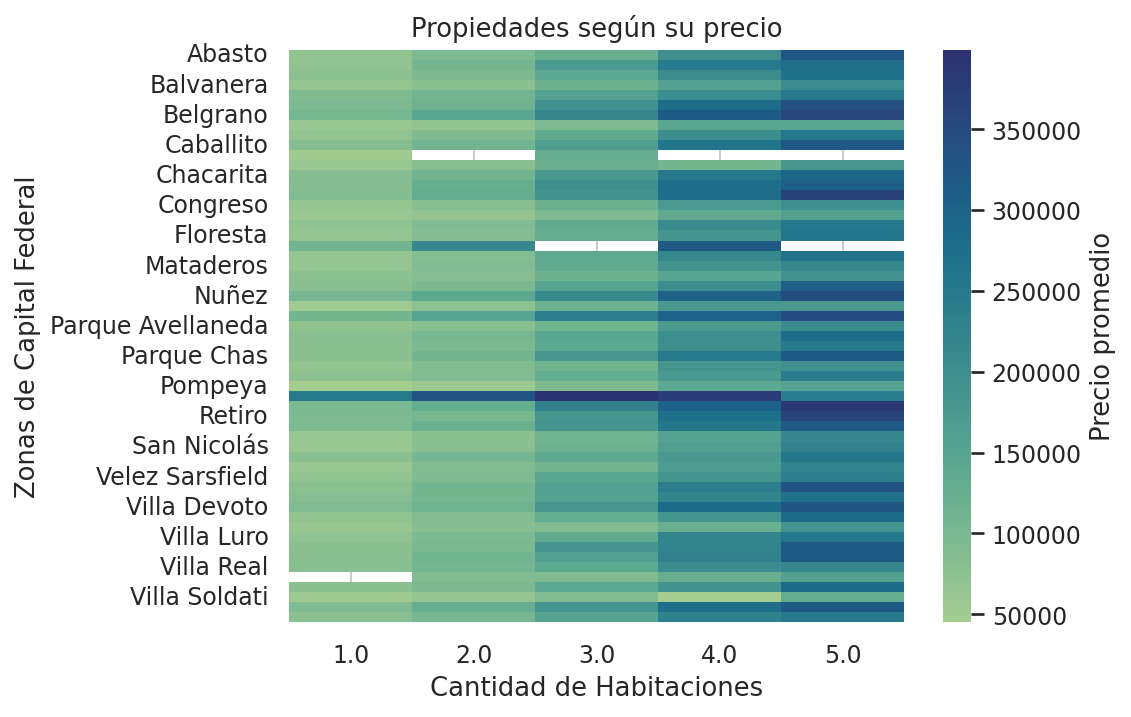

In [281]:
# Nueva figura con un dpi de 155 para mejorar la calidad de la visualización
plt.figure(dpi=155)

# Establecer el título de la visualización
plt.title("Propiedades según su precio")

# Crear un heatmap utilizando Seaborn con los datos de df_visu
sns.heatmap(df_visu, square=False, cmap='crest', fmt=".0f", cbar_kws={'label': 'Precio promedio'})

# Establecer etiquetas para los ejes x e y
plt.xlabel("Cantidad de Habitaciones")
plt.ylabel("Zonas de Capital Federal")

# Heatmap que muestra el precio promedio por propiedad tomando en cuenta la cantidad de habitaciones y su ubicación

La visualización presentada es un mapa de calor (heatmap) que muestra el precio promedio de las propiedades en función de la cantidad de habitaciones y su ubicación en diferentes zonas de la Ciudad Autónoma de Buenos Aires (CABA). Al observar el heatmap, es posible identificar patrones en los precios según la ubicación y el tamaño de la propiedad. Por ejemplo, puede haber áreas donde las propiedades con más habitaciones tienden a tener precios más altos, mientras que en otras zonas los precios son más uniformes independientemente del tamaño de la propiedad.La visualización proporciona una manera efectiva de entender cómo se relacionan el precio promedio de las propiedades, la cantidad de habitaciones y la ubicación en diferentes áreas de la Ciudad Autónoma de Buenos Aires. Ayuda a los interesados a tomar decisiones informadas sobre la compra o inversión en propiedades en la ciudad.

VERSION MEJORADA: POR CORRECCION DEL PROFE

---


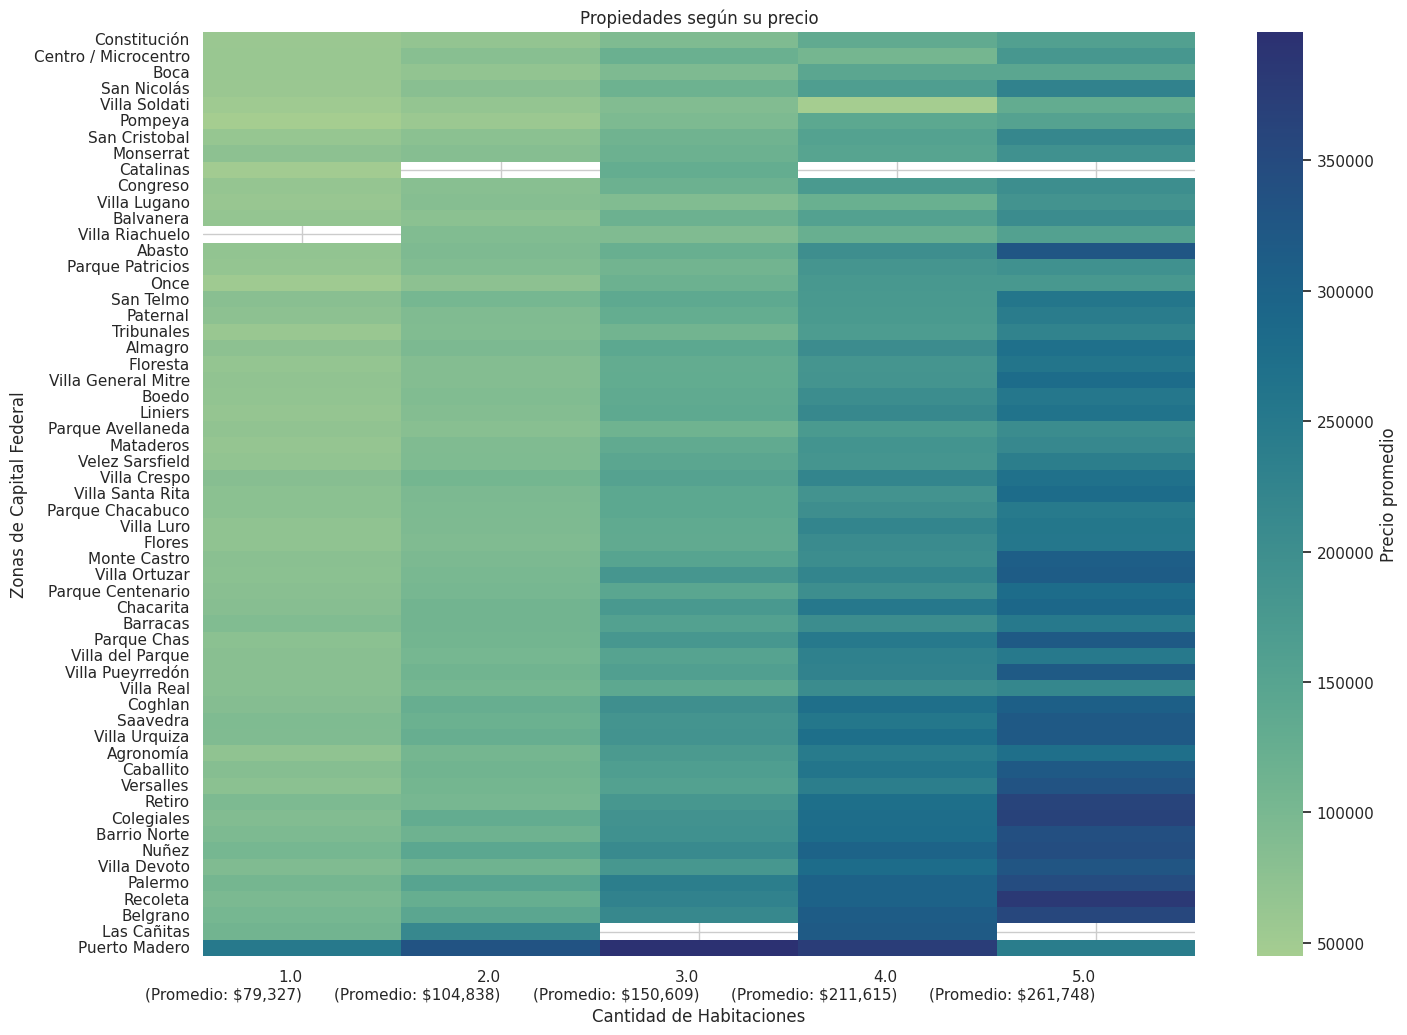

In [282]:
# Calcula el precio promedio por zona
avg_price_by_zone = visu_ds_propiedades_filtradas.groupby('place_l3')['property_price'].mean()

# Ordenar los barrios según el precio promedio
sorted_zones = avg_price_by_zone.sort_values().index

# Crear una tabla pivote para calcular el precio promedio por barrio y cantidad de habitaciones
df_visu = visu_ds_propiedades_filtradas.pivot_table(values='property_price',
                                      index='place_l3',
                                      columns='property_rooms',
                                      aggfunc='mean')

# Reordenar los barrios según el precio promedio
df_visu = df_visu.reindex(index=sorted_zones)

# Nueva figura con un tamaño mayor y dpi para mejorar la calidad de la visualización
plt.figure(figsize=(16, 12), dpi=100)

# Establecer el título de la visualización
plt.title("Propiedades según su precio")

# Crear un heatmap utilizando Seaborn con los datos de df_visu
sns.heatmap(df_visu, cmap='crest', fmt=".0f", cbar_kws={'label': 'Precio promedio'})

# Ajustar los ticks del eje x para coincidir con las zonas de la Capital Federal
plt.xticks(ticks=np.arange(0.5, len(df_visu.columns)), labels=df_visu.columns, rotation=45, ha='right')

# Ajustar los ticks del eje y para incluir todos los barrios
plt.yticks(ticks=np.arange(0.5, len(df_visu.index)), labels=df_visu.index, rotation=0, ha='right')
# Ajustar los ticks del eje x para coincidir con las zonas de la Capital Federal y el precio promedio por zona
plt.xticks(ticks=np.arange(0.5, len(df_visu.columns)),
           labels=[f"{col}\n(Promedio: ${df_visu[col].mean():,.0f})" for col in df_visu.columns],
           rotation=45, ha='right')

# Ajustar los ticks del eje y para incluir todos los barrios
plt.yticks(ticks=np.arange(0.5, len(df_visu.index)), labels=df_visu.index, rotation=0, ha='right')

# Añadir etiquetas para los ejes x e y
plt.xlabel("Cantidad de Habitaciones")
plt.ylabel("Zonas de Capital Federal")
plt.xticks(rotation=0)

# Mostrar el heatmap
plt.show()

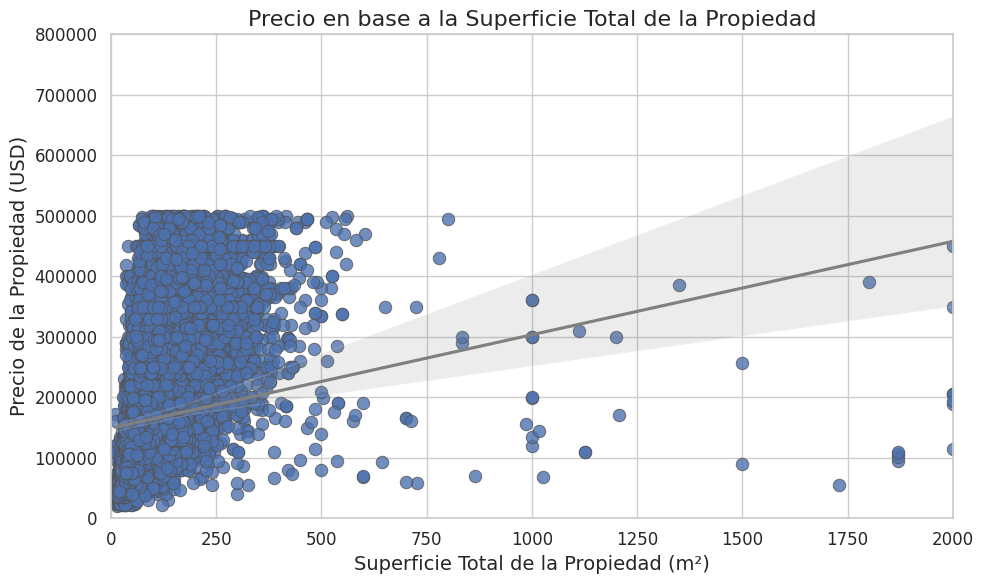

In [283]:
# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Crear el scatter plot utilizando Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=visu_ds_propiedades_filtradas[visu_ds_propiedades_filtradas['property_surface_total'] < 20000],
                x='property_surface_total', y='property_price', palette='pastel', s=80, alpha=0.8)

# Agregar una línea de regresión
sns.regplot(data=visu_ds_propiedades_filtradas[visu_ds_propiedades_filtradas['property_surface_total'] < 20000],
            x='property_surface_total', y='property_price', scatter=False, color='gray')

# Ajustar título y etiquetas
plt.title('Precio en base a la Superficie Total de la Propiedad', fontsize=16)
plt.xlabel('Superficie Total de la Propiedad (m²)', fontsize=14)
plt.ylabel('Precio de la Propiedad (USD)', fontsize=14)

# Ajustar tamaño de fuente de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Ajustar el rango de los ejes
plt.xlim(0, 2000)  # Establecer el rango x hasta 20,000
plt.ylim(0, 800000)
# Añadir sombreado alrededor de las burbujas
plt.gca().collections[0].set_edgecolor("#555555")

plt.tight_layout()
plt.show()

Esta visualización muestra un diagrama de dispersión (scatter plot) que relaciona el precio de la propiedad con su superficie total, con el agregado de una línea de regresión para visualizar la tendencia general de los datos.La línea de regresión trazada en el gráfico muestra la tendencia general de los datos. Permite ver si hay una relación lineal entre el precio y la superficie total de la propiedad. En este caso, la pendiente de la línea de regresión indica la tasa de cambio en el precio para cada unidad adicional de superficie.Cada punto en el diagrama de dispersión representa una propiedad individual, y su posición relativa en el gráfico indica su precio y superficie total. Esto facilita la identificación de propiedades que pueden estar por encima o por debajo de la tendencia general.

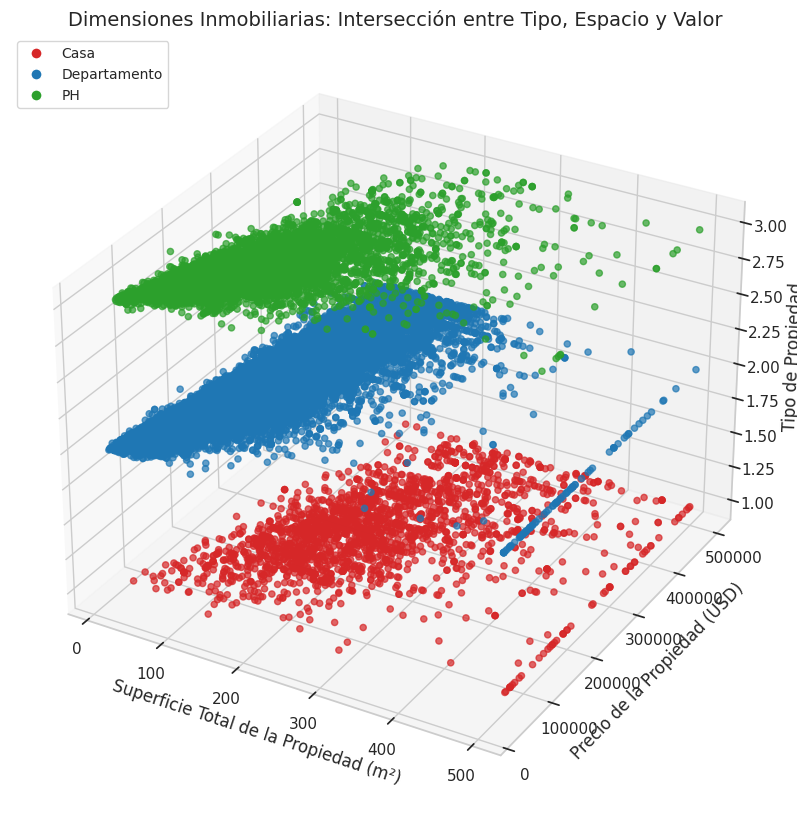

In [284]:
# Crear una figura y un conjunto de ejes tridimensionales
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Mapa de colores para los tipos de propiedad
color_mapping = {'Casa': 'tab:red', 'Departamento': 'tab:blue', 'PH': 'tab:green'}

# Asignar un valor numérico a cada tipo de propiedad
property_type_mapping = {'Casa': 1, 'Departamento': 2, 'PH': 3}
property_type_numeric = [property_type_mapping[prop_type] for prop_type in visu_ds_propiedades_filtradas['property_type']]

# Extraer las variables del dataframe
property_surface_total = visu_ds_propiedades_filtradas['property_surface_total'].clip(0, 500)
property_price = visu_ds_propiedades_filtradas['property_price']

# Graficar los puntos tridimensionales
scatter = ax.scatter(property_surface_total, property_price, property_type_numeric, c=[color_mapping[prop_type] for prop_type in visu_ds_propiedades_filtradas['property_type']], alpha=0.7)

# Etiquetas de los ejes
ax.set_xlabel('Superficie Total de la Propiedad (m²)', fontsize=12)
ax.set_ylabel('Precio de la Propiedad (USD)', fontsize=12)
ax.set_zlabel('Tipo de Propiedad', fontsize=12)

# Leyenda para los colores
legend_labels = ['Casa', 'Departamento', 'PH']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[prop_type], markersize=8, label=prop_type) for prop_type in legend_labels]
ax.legend(handles=legend_handles, labels=legend_labels, loc='upper left', fontsize=10)

# Añadir una rejilla de fondo
ax.grid(True)

# Título del gráfico
plt.title('Dimensiones Inmobiliarias: Intersección entre Tipo, Espacio y Valor', fontsize=14)

# Mostrar el gráfico
plt.show()

Este gráfico tridimensional permite visualizar la distribución de las propiedades en función de su tipo, tamaño y precio. Se pueden identificar patrones de agrupamiento o tendencias en el espacio tridimensional, lo que puede ser útil para comprender mejor el mercado inmobiliario y tomar decisiones informadas. Además, podría usarse para ajustar un modelo de regresión tridimensional para predecir el precio de una propiedad en función de su tipo y tamaño.

In [285]:
# Calcular el precio promedio por barrio
precio_promedio_por_barrio = visu_ds_propiedades_filtradas.groupby('place_l3')['property_price'].mean().reset_index()

# Crear el gráfico de burbujas agrupadas
fig = px.scatter(precio_promedio_por_barrio,
                 x='place_l3', y='property_price',
                 size='property_price',
                 color='place_l3',
                 hover_name='place_l3',
                 size_max=50,
                 title='Precio promedio por barrio',
                 labels={'place_l3': 'Barrio', 'property_price': 'Precio promedio'})
fig.show()

Esta visualización muestra un gráfico de burbujas agrupadas que representa el precio promedio de las propiedades en cada barrio.El gráfico de burbujas agrupadas proporciona una representación visual del precio promedio de las propiedades en cada barrio de interés. Cada burbuja representa un barrio, y el tamaño de la burbuja indica el precio promedio de las propiedades en ese barrio. Los colores de las burbujas pueden indicar diferentes barrios para facilitar la identificación visual, las burbujas más grandes representan barrios con precios promedio más altos, mientras que las burbujas más pequeñas representan barrios con precios promedio más bajos.El gráfico de burbujas agrupadas es interactivo, lo que permite a los usuarios explorar los datos con mayor detalle al pasar el cursor sobre las burbujas para ver información adicional, como el nombre del barrio y el precio promedio.

VERSION MEJORADA: POR CORRECCION DEL PROFE

---


In [286]:
# Ordenar los barrios según el precio promedio
precio_promedio_por_barrio_sorted = precio_promedio_por_barrio.sort_values('property_price')

# Crear el gráfico de burbujas agrupadas
fig = px.scatter(precio_promedio_por_barrio_sorted,
                 x='place_l3', y='property_price',
                 size='property_price',
                 color='property_price',
                 hover_name='place_l3',
                 size_max=50,
                 title='Precio Promedio por Zona de Capital Federal',
                 labels={'place_l3': 'Barrio', 'property_price': 'Precio Promedio por Zona'})
fig.update_layout(xaxis_title="Precio Promedio por Zona",
                  yaxis_title="Barrio",
                  title_font=dict(size=20, family="Arial"),
                  font=dict(family="Arial", size=12),
                  plot_bgcolor='white',
                  paper_bgcolor='white',
                  hoverlabel=dict(font=dict(family="Arial", size=14)),
                  xaxis=dict(showgrid=True, gridwidth=1, gridcolor='lightgray'),
                  yaxis=dict(showgrid=True, gridwidth=1, gridcolor='lightgray'))
fig.show()

In [287]:
# Filtramos los Nan de latitud ya que es impresindible contar con este dato para asignarlo al mapa
visu_mapa = visu_ds_propiedades_filtradas.dropna(subset=['latitud'])

def generar_mapa_con_registros_por_barrio(df):
    """
    Función para generar un mapa con los registros por barrio.

    Parámetros:
    - visu_mapa: DataFrame que contiene los datos de las propiedades filtradas.

    Devuelve:
    - mapa: Objeto del mapa de Folium.
    """
    # Coordenadas del centro de la Ciudad Autónoma de Buenos Aires
    latitud_caba = -34.6037
    longitud_caba = -58.3816

    # Crear el mapa centrado en CABA
    mapa = folium.Map(location=[latitud_caba, longitud_caba], zoom_start=12)

    # Agregar un grupo de marcadores
    marker_cluster = MarkerCluster().add_to(mapa)

    # Contar la cantidad de registros por barrio
    registros_por_barrio = visu_mapa['place_l3'].value_counts()

    # Agregar marcadores en el mapa para cada barrio
    for barrio, cantidad in registros_por_barrio.items():
        latitud = visu_mapa[visu_mapa['place_l3'] == barrio]['latitud'].iloc[0]
        longitud = visu_mapa[visu_mapa['place_l3'] == barrio]['longitud'].iloc[0]

        folium.Marker(location=[latitud, longitud],
                      tooltip=f"{barrio}: {cantidad} Propiedad en Venta").add_to(marker_cluster)

    return mapa

# Generar el mapa con los registros por barrio
mapa = generar_mapa_con_registros_por_barrio(visu_mapa)

# Mostrar el mapa
mapa

La visualización proporciona un mapa interactivo que muestra la ubicación de las propiedades en venta en la Ciudad Autónoma de Buenos Aires (CABA), agrupadas por barrio.Cada marcador en el mapa representa una propiedad, y su ubicación específica está determinada por las coordenadas de latitud y longitud proporcionadas en los datos.Los grupos de marcadores en el mapa indican la concentración de propiedades en cada barrio, lo que puede proporcionar información sobre la popularidad y la demanda de viviendas en diferentes áreas de CABA.

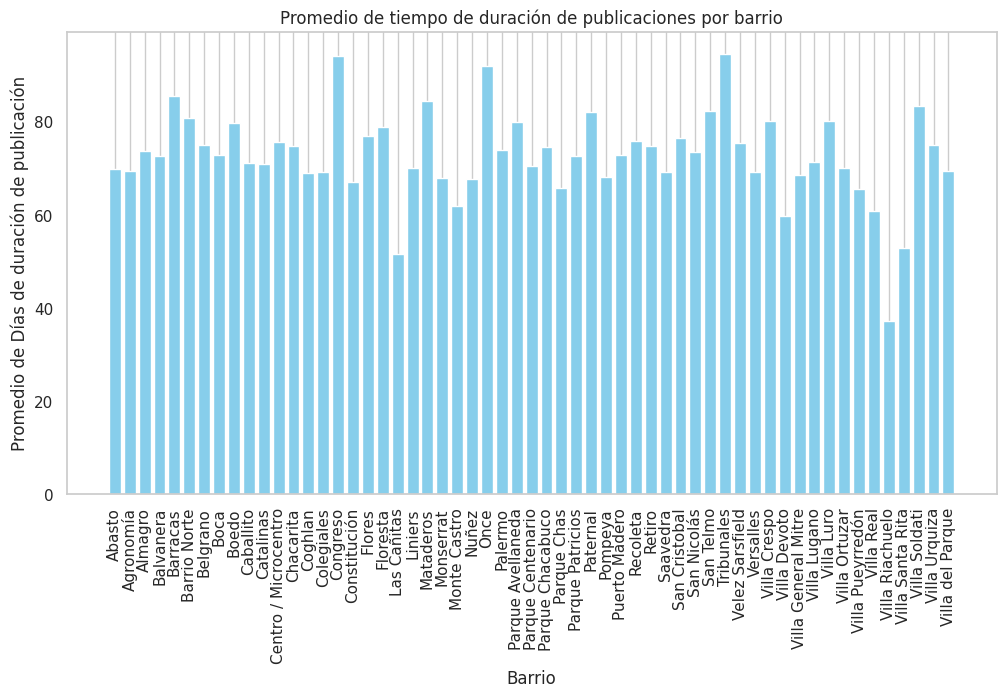

In [288]:
# Convertir las fechas a tipo datetime si no están en ese formato
visu_ds_propiedades_filtradas['start_date'] = pd.to_datetime(visu_ds_propiedades_filtradas['start_date'], errors='coerce')
visu_ds_propiedades_filtradas['end_date'] = pd.to_datetime(visu_ds_propiedades_filtradas['end_date'], errors='coerce')

# Calcular la duración de cada publicación
visu_ds_propiedades_filtradas['duracion_publicacion'] = (visu_ds_propiedades_filtradas['end_date'] - visu_ds_propiedades_filtradas['start_date']).dt.days

# Agrupar por barrio y calcular el promedio de duración de las publicaciones
promedio_duracion_por_barrio = visu_ds_propiedades_filtradas.groupby('place_l3')['duracion_publicacion'].mean().reset_index()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(promedio_duracion_por_barrio['place_l3'], promedio_duracion_por_barrio['duracion_publicacion'], color='skyblue')
plt.title('Promedio de tiempo de duración de publicaciones por barrio')
plt.xlabel('Barrio')
plt.ylabel('Promedio de Días de duración de publicación')
plt.xticks(rotation=90)
plt.grid(axis='y')

plt.show()

Esta visualización presenta un gráfico de barras que muestra el promedio de tiempo de duración de las publicaciones por barrio en la Ciudad Autónoma de Buenos Aires (CABA). Cada barra en el gráfico representa un barrio específico, y su altura indica el promedio de días que las publicaciones permanecen activas en ese barrio.La visualización permite comparar fácilmente la duración promedio de las publicaciones entre diferentes barrios de la ciudad. Las barras más altas indican que las publicaciones en ese barrio tienden a permanecer activas por más tiempo, mientras que las barras más cortas indican una duración promedio más corta de las publicaciones.Los barrios con barras más altas pueden indicar áreas de la ciudad donde la demanda de propiedades es más alta o donde las propiedades tienden a permanecer en el mercado por períodos más prolongados. Esto puede ser útil para comprender las dinámicas del mercado inmobiliario en diferentes áreas de la ciudad.

## Datos Faltantes
En esta sección se va a realizar el análsis de la presencia de datos faltantes

### Análisis de datos faltantes a nivel columna

#### Análisis previo

In [289]:
ds_propiedades_filtradas.columns

Index(['id', 'start_date', 'end_date', 'latitud', 'longitud', 'place_l3',
       'place_l4', 'place_l5', 'place_l6', 'property_type', 'property_rooms',
       'property_bedrooms', 'property_surface_total',
       'property_surface_covered', 'property_price'],
      dtype='object')

Para iniciar, vamos a analizar la cantidad de datos faltantes por columna y su porcentaje

In [290]:
def obtener_filas(ds):
  return ds.shape[0]

def obtener_columnas(ds):
  return ds.shape[1]

In [291]:
filas = obtener_filas(ds_propiedades_filtradas)
columnas = obtener_columnas(ds_propiedades_filtradas)
print("El dataset de entrenamiento tiene {} filas y {} columnas".format(filas,columnas))

El dataset de entrenamiento tiene 94249 filas y 15 columnas


Obtengo el porcentaje de cada columna que contiene datos nulos

In [292]:
def obtener_promedio_nulos(ds):
  return ds.isna().sum() / obtener_filas(ds) * 100

promedio_datos_nulos = obtener_promedio_nulos(ds_propiedades_filtradas)
promedio_datos_nulos

id                            0.000000
start_date                    0.000000
end_date                      0.000000
latitud                       3.957602
longitud                      3.957602
place_l3                      0.442445
place_l4                     96.134707
place_l5                    100.000000
place_l6                    100.000000
property_type                 0.000000
property_rooms                1.107704
property_bedrooms            11.657418
property_surface_total        5.139577
property_surface_covered      3.558658
property_price                0.000000
dtype: float64

Muestro la cantidad de datos nulos por columna

In [293]:
def obtener_cantidad_nulos_ds(ds):
  return ds.isna().sum()

cant_datos_nulos = obtener_cantidad_nulos_ds(ds_propiedades_filtradas)
cant_datos_nulos

id                              0
start_date                      0
end_date                        0
latitud                      3730
longitud                     3730
place_l3                      417
place_l4                    90606
place_l5                    94249
place_l6                    94249
property_type                   0
property_rooms               1044
property_bedrooms           10987
property_surface_total       4844
property_surface_covered     3354
property_price                  0
dtype: int64

Grafico esta relación

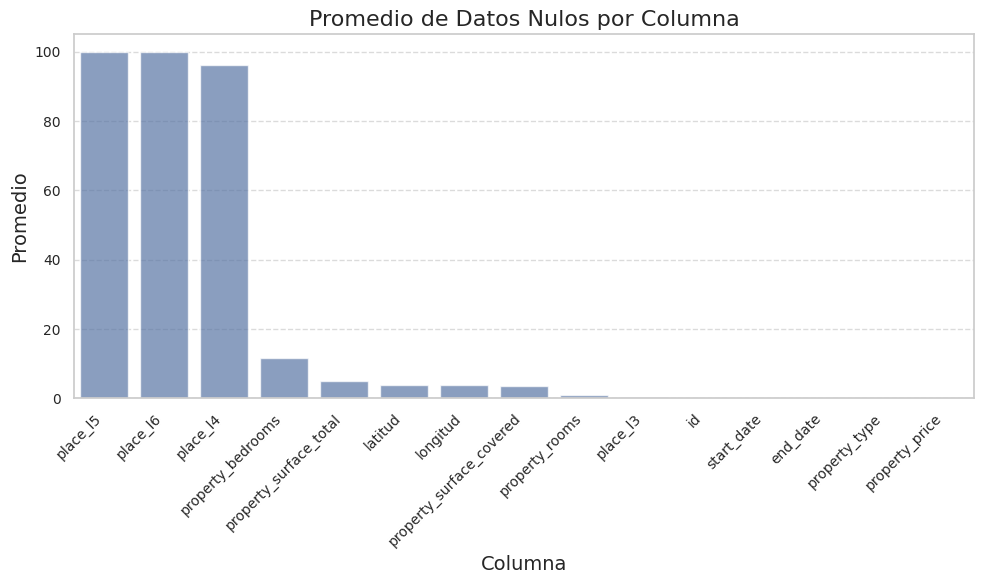

In [294]:
ds_porcentaje = promedio_datos_nulos

# Ordenar los valores en orden descendente
ds_porcentaje = ds_porcentaje.sort_values(ascending = False)

# Establecer el estilo del gráfico
sns.set_style("whitegrid")

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 6))

# Graficar el gráfico de barras
bar_plot = sns.barplot(x=ds_porcentaje.index, y=ds_porcentaje.values, alpha=0.7)

# Agregar título y etiquetas
bar_plot.set_title("Promedio de Datos Nulos por Columna", fontsize=16)
bar_plot.set_xlabel("Columna", fontsize=14)
bar_plot.set_ylabel("Promedio", fontsize=14)

# Rotar etiquetas del eje x para una mejor legibilidad
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, horizontalalignment='right')

# Agregar líneas de la cuadrícula y ajustar el tamaño de la fuente
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Entonces los datos que debo analizar son:

In [295]:
def obtener_cantidad_nulos(ds):
  promedio_datos_nulos = obtener_promedio_nulos(ds)
  promedio_datos_nulos.sort_values(ascending = False,inplace=True)
  filtro = promedio_datos_nulos!=0
  return promedio_datos_nulos[filtro] if not promedio_datos_nulos[filtro].empty else 'No existen valores NaN'

obtener_cantidad_nulos(ds_propiedades_filtradas)

place_l5                    100.000000
place_l6                    100.000000
place_l4                     96.134707
property_bedrooms            11.657418
property_surface_total        5.139577
latitud                       3.957602
longitud                      3.957602
property_surface_covered      3.558658
property_rooms                1.107704
place_l3                      0.442445
dtype: float64

#### Elimino places (place_l6, place_l5, place_l4)

Al ver el gráfico y el análisis previo de nulos. Puedo eliminar las columnas ```place_l6```, ```place_l5``` y ```place_l4```, pues tienen en su totalidad de datos nulos. El ```place_l4``` tiene casi su totalidad de nulos.

Consideramos que las columnas ```place_l6```, ```place_l5``` son datos faltantes de tipo MCAR

In [296]:
columnas = ['place_l6','place_l5','place_l4']
ds_propiedades_filtradas.drop(columns=columnas, inplace=True)

In [297]:
ds_propiedades_filtradas.head()

id start_date    end_date    latitud   longitud  \
25  CyZu6IaZgmQYGk8jmPajCg== 2021-09-09  2021-09-26        NaN        NaN   
42  d3Z0MblSb2IMBoOBMGJEEQ== 2021-09-09  2021-09-26 -34.637319 -58.361124   
43  rL7qPkQnomsMGu2ViS3sBw== 2021-09-09  2021-09-28 -34.628647 -58.361871   
49  vuX/ccLAMVml4qWRFcOJUA== 2021-09-09  2022-01-05 -34.610027 -58.401934   
51  ZTtSCeqZ3HUgf5jjwEzRcw== 2021-09-09  2022-03-09 -34.631621 -58.416825   

   place_l3 property_type  property_rooms  property_bedrooms  \
25      NaN          Casa             4.0                3.0   
42     Boca  Departamento             3.0                2.0   
43     Boca  Departamento             4.0                3.0   
49     Once  Departamento             4.0                2.0   
51    Boedo            PH             4.0                2.0   

    property_surface_total  property_surface_covered  property_price  
25                   171.0                     133.0        210000.0  
42                    58.0                      55.0         82900.0  
43                    70.0                      70.0         99000.0  
49                     NaN                     104.0        146000.0  
51                     NaN                      73.0        250000.0

In [298]:
nulos_preimputacion = obtener_cantidad_nulos(ds_propiedades_filtradas)

#### Generar funciones para análisis

In [299]:
# establezco si son o no nulos
def generar_ds_nulo(columnas):
  return ds_propiedades_filtradas[columnas].isna()

def filtrar_nulo(columna,ds):
  return ds[columna]==True

def filtrar_no_nulo(columna,ds):
  return ds[columna]==False

def aplicar_filtro(ds,filtro,columna,nulidad):
  ds.loc[filtro,columna] = nulidad
  return ds

In [300]:
def contar_ds(ds,columna):
  return ds[columna].value_counts()

def imprimir_cantidades(nulos,no_nulos,columna):
  print("Cantidad de datos NULOS en {}: {}".format(columna,nulos))
  print("Cantidad de datos NO NULOS en {}: {}".format(columna,no_nulos))

In [301]:
def generar_grafico(ds, columna):
  # Ajustar el tamaño de la figura
  plt.figure(figsize=(10, 6))

  # Agrupar por 'longitud' y obtener el tamaño de cada grupo, luego trazar el gráfico de barras horizontales
  ds.groupby(columna).size().plot(kind='barh', color=sns.color_palette('Dark2'))

  # Ocultar los ejes superior y derecho
  plt.gca().spines['top'].set_visible(False)
  plt.gca().spines['right'].set_visible(False)

  titulo = 'Tamaño de Grupo por ' + columna
  # Configurar el tamaño de la letra del título y las etiquetas
  plt.title(titulo, fontsize=16)
  plt.xlabel('Cantidad', fontsize=14)
  plt.ylabel(columna, fontsize=14)

  # Mostrar el gráfico
  plt.show()

#### Latitud y longitud
Vamos a anlizar los nulos de estas dos variables

In [302]:
latatitud_longitud = generar_ds_nulo(['latitud','longitud'])
# filtros latitud
v_filtro_latitud = filtrar_nulo('latitud',latatitud_longitud)
f_filtro_latitud = filtrar_no_nulo('latitud',latatitud_longitud)
# filtros longitud
v_filtro_longitud = filtrar_nulo('longitud',latatitud_longitud)
f_filtro_longitud = filtrar_no_nulo('longitud',latatitud_longitud)
# aplico los filtros
latatitud_longitud = aplicar_filtro(latatitud_longitud,v_filtro_latitud,'latitud','nulo')
latatitud_longitud = aplicar_filtro(latatitud_longitud,f_filtro_latitud,'latitud','no nulo')

latatitud_longitud = aplicar_filtro(latatitud_longitud,v_filtro_longitud,'longitud','nulo')
latatitud_longitud = aplicar_filtro(latatitud_longitud,f_filtro_longitud,'longitud','no nulo')

latatitud_longitud.head()

latitud longitud
25     nulo     nulo
42  no nulo  no nulo
43  no nulo  no nulo
49  no nulo  no nulo
51  no nulo  no nulo

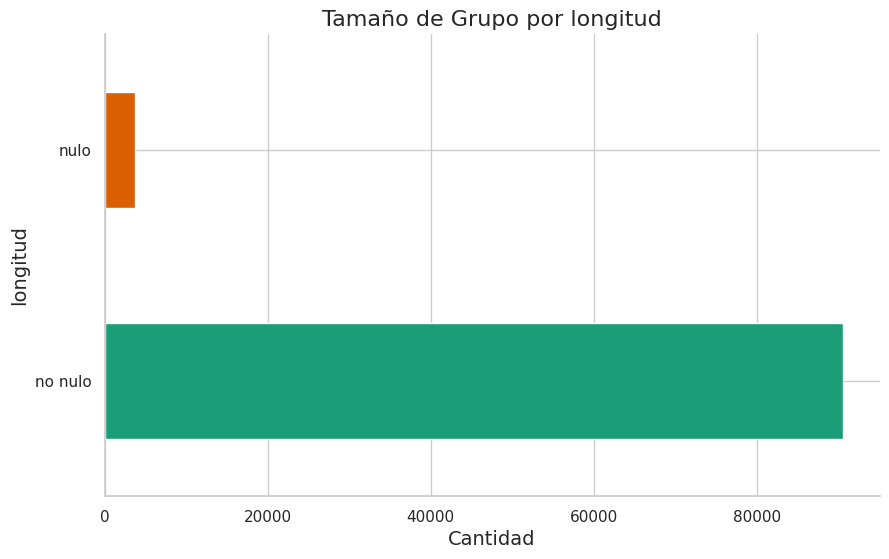

In [303]:
generar_grafico(latatitud_longitud,'longitud')

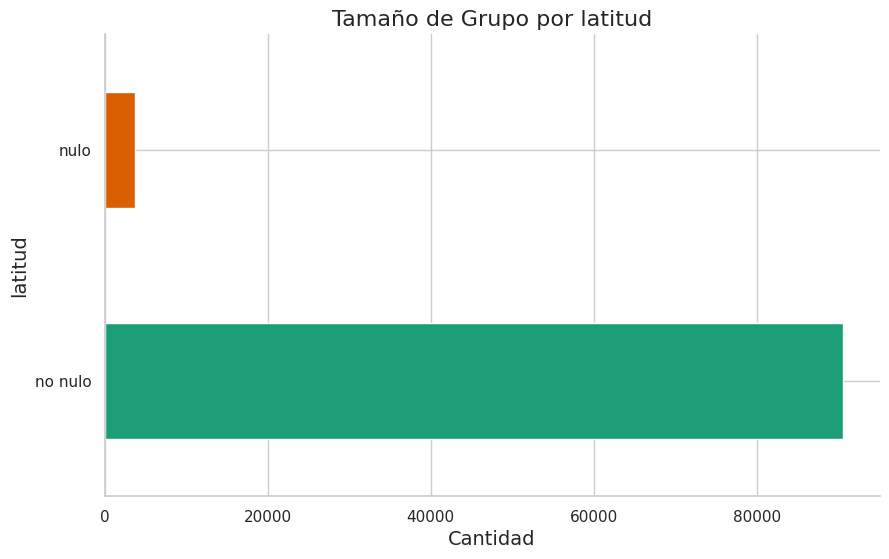

In [304]:
generar_grafico(latatitud_longitud,'latitud')

In [305]:
imprimir_cantidades(latatitud_longitud.value_counts()[1], latatitud_longitud.value_counts()[0], 'longitud')

Cantidad de datos NULOS en longitud: 3730
Cantidad de datos NO NULOS en longitud: 90519


In [306]:
imprimir_cantidades(latatitud_longitud.value_counts()[1], latatitud_longitud.value_counts()[0], 'latitud')

Cantidad de datos NULOS en latitud: 3730
Cantidad de datos NO NULOS en latitud: 90519


#### Superficie total y Superficie cubierta (property_surface_total, property_surface_covered)

In [307]:
# establezco si son o no nulos
sup_total_cubierta = generar_ds_nulo(['property_surface_total','property_surface_covered'])
# creo filtro si son o no nulos
v_filtro_total =  filtrar_nulo('property_surface_total',sup_total_cubierta)
f_filtro_total =  filtrar_no_nulo('property_surface_total',sup_total_cubierta)

v_filtro_cubierto =  filtrar_nulo('property_surface_covered',sup_total_cubierta)
f_filtro_cubierto =  filtrar_no_nulo('property_surface_covered',sup_total_cubierta)
# establezco los nulos y no nulos
sup_total_cubierta = aplicar_filtro(sup_total_cubierta,v_filtro_total,'property_surface_total','nulo')
sup_total_cubierta = aplicar_filtro(sup_total_cubierta,f_filtro_total,'property_surface_total','no nulo')

# establezco los nulos y no nulos
sup_total_cubierta = aplicar_filtro(sup_total_cubierta,v_filtro_cubierto,'property_surface_covered','nulo')
sup_total_cubierta = aplicar_filtro(sup_total_cubierta,f_filtro_cubierto,'property_surface_covered','no nulo')

sup_total_cubierta.head()

property_surface_total property_surface_covered
25                no nulo                  no nulo
42                no nulo                  no nulo
43                no nulo                  no nulo
49                   nulo                  no nulo
51                   nulo                  no nulo

In [308]:
imprimir_cantidades(sup_total_cubierta.value_counts()[1], sup_total_cubierta.value_counts()[0], 'property_surface_total')

Cantidad de datos NULOS en property_surface_total: 4844
Cantidad de datos NO NULOS en property_surface_total: 86051


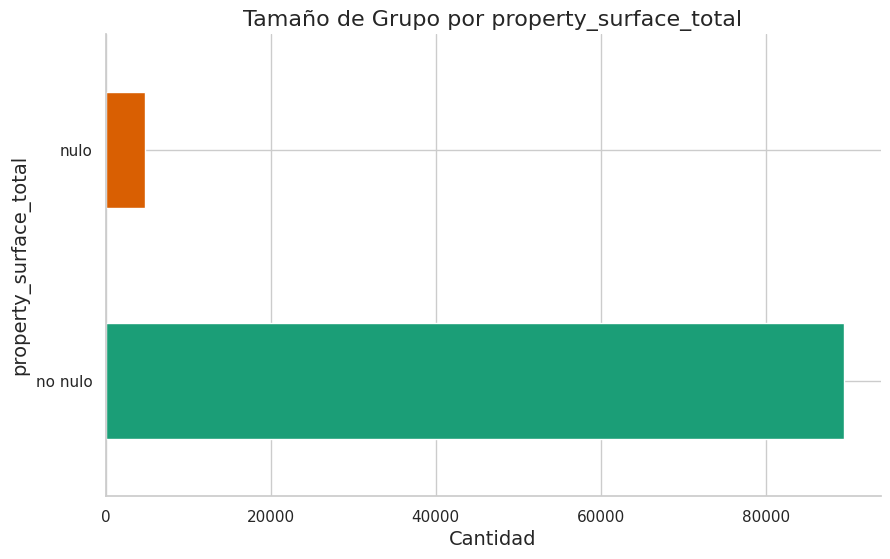

In [309]:
generar_grafico(sup_total_cubierta,'property_surface_total')

In [310]:
imprimir_cantidades(sup_total_cubierta.value_counts()[1], sup_total_cubierta.value_counts()[0], 'property_surface_covered')

Cantidad de datos NULOS en property_surface_covered: 4844
Cantidad de datos NO NULOS en property_surface_covered: 86051


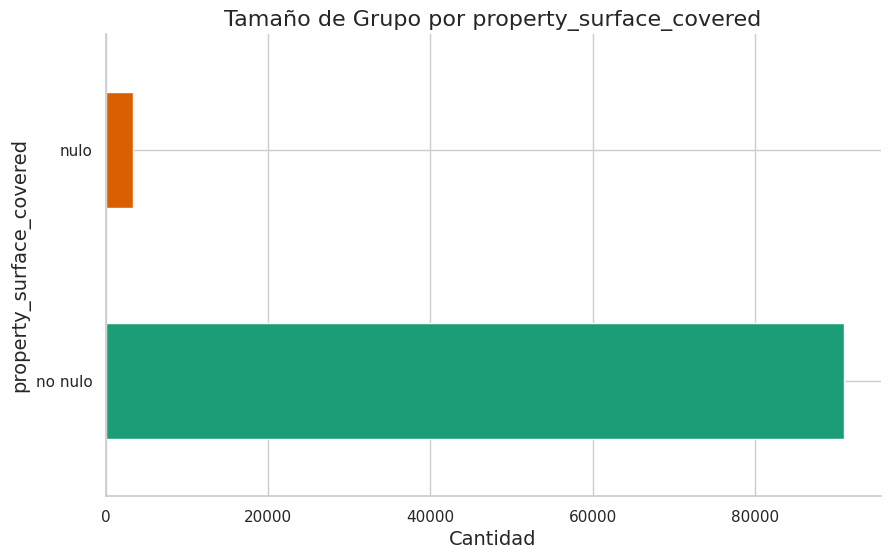

In [311]:
generar_grafico(sup_total_cubierta,'property_surface_covered')

#### Habitaciones y dormitorios (property_rooms, property_bedrooms)

In [312]:
# establezco si son o no nulos
habitaciones_dormis = generar_ds_nulo(['property_rooms','property_bedrooms'])
# creo filtro si son o no nulos
v_filtro_hab = filtrar_nulo('property_rooms',habitaciones_dormis)
f_filtro_hab =  filtrar_no_nulo('property_rooms',habitaciones_dormis)

v_filtro_dormis =  filtrar_nulo('property_bedrooms',habitaciones_dormis)
f_filtro_dormis =  filtrar_no_nulo('property_bedrooms',habitaciones_dormis)

# establezco los nulos y no nulos
habitaciones_dormis = aplicar_filtro(habitaciones_dormis,v_filtro_hab,'property_rooms','nulo')
habitaciones_dormis = aplicar_filtro(habitaciones_dormis,f_filtro_hab,'property_rooms','no nulo')

# establezco los nulos y no nulos
habitaciones_dormis = aplicar_filtro(habitaciones_dormis,v_filtro_dormis,'property_bedrooms','nulo')
habitaciones_dormis = aplicar_filtro(habitaciones_dormis,f_filtro_dormis,'property_bedrooms','no nulo')

habitaciones_dormis.head()

property_rooms property_bedrooms
25        no nulo           no nulo
42        no nulo           no nulo
43        no nulo           no nulo
49        no nulo           no nulo
51        no nulo           no nulo

In [313]:
imprimir_cantidades(habitaciones_dormis.value_counts()[1], habitaciones_dormis.value_counts()[0], 'property_rooms')

Cantidad de datos NULOS en property_rooms: 10555
Cantidad de datos NO NULOS en property_rooms: 82650


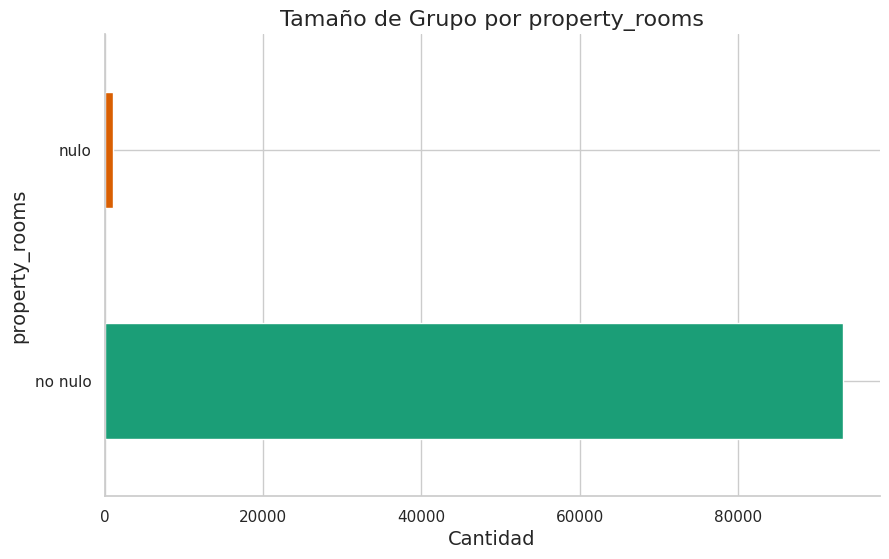

In [314]:
generar_grafico(habitaciones_dormis,'property_rooms')

In [315]:
imprimir_cantidades(habitaciones_dormis.value_counts()[1], habitaciones_dormis.value_counts()[0], 'property_bedrooms')

Cantidad de datos NULOS en property_bedrooms: 10555
Cantidad de datos NO NULOS en property_bedrooms: 82650


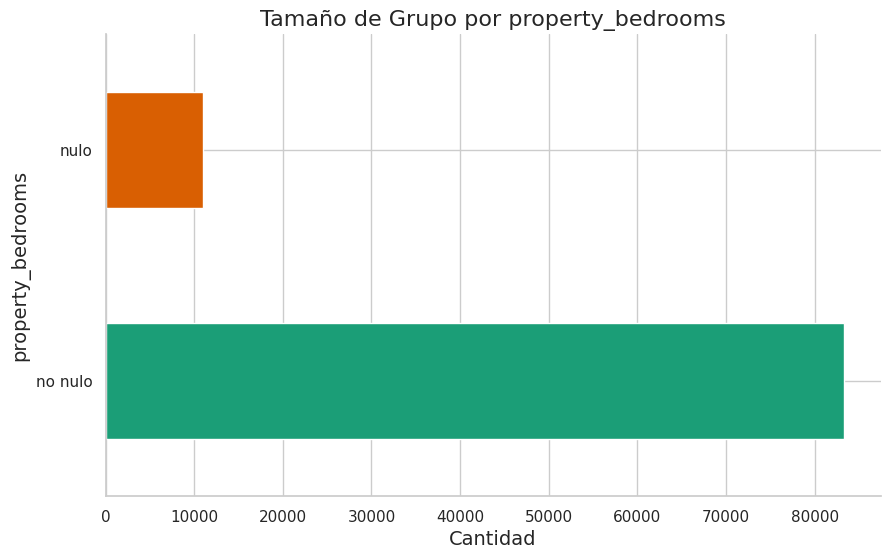

In [316]:
generar_grafico(habitaciones_dormis,'property_bedrooms')

#### Barrio (place_l3)

In [317]:
# establezco si son o no nulos
barrio = generar_ds_nulo('place_l3')
# creo filtro si son o no nulos
v_filtro_barrio =  barrio == True
f_filtro_barrio =  barrio == False
# establezco los nulos y no nulos
barrio.loc[v_filtro_barrio] = 'nulo'
barrio.loc[f_filtro_barrio] = 'no nulo'

barrio.head()

25       nulo
42    no nulo
43    no nulo
49    no nulo
51    no nulo
Name: place_l3, dtype: object

In [318]:
imprimir_cantidades(barrio.value_counts()[1], barrio.value_counts()[0], 'place_l3')

Cantidad de datos NULOS en place_l3: 417
Cantidad de datos NO NULOS en place_l3: 93832


<Axes: title={'center': 'Gráfico de barras: Cantidad de nulos en la variable place_l3'}, xlabel='tipo de dato', ylabel='cantidad de filas'>

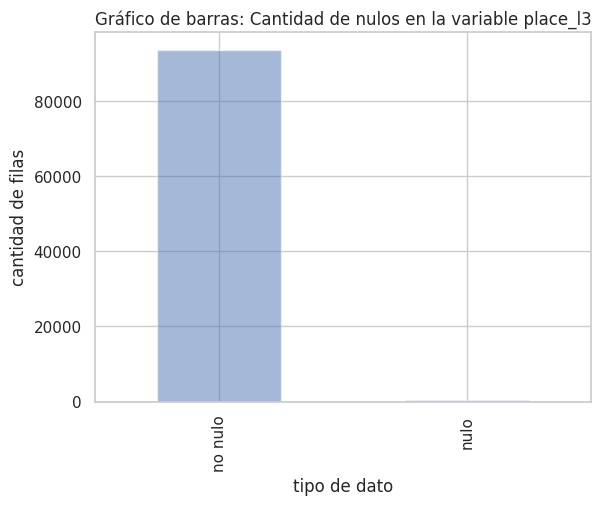

In [319]:
barrio.value_counts().plot.bar(alpha=0.5,title="Gráfico de barras: Cantidad de nulos en la variable place_l3", xlabel="tipo de dato" , ylabel="cantidad de filas")

#### Precio

In [320]:
precio = generar_ds_nulo('property_price')
# creo filtro si son o no nulos
v_filtro_precio =  precio == True
f_filtro_precio =  precio == False
# establezco los nulos y no nulos
precio.loc[v_filtro_precio] = 'nulo'
precio.loc[f_filtro_precio] = 'no nulo'

precio.head()

25    no nulo
42    no nulo
43    no nulo
49    no nulo
51    no nulo
Name: property_price, dtype: object

In [321]:
print("Cantidad de datos NO NULOS en property_price: {}".format(precio.value_counts()))

Cantidad de datos NO NULOS en property_price: property_price
no nulo    94249
Name: count, dtype: int64


<Axes: title={'center': 'Gráfico de barras: Cantidad de nulos en la variable property_price'}, xlabel='tipo de dato', ylabel='cantidad de filas'>

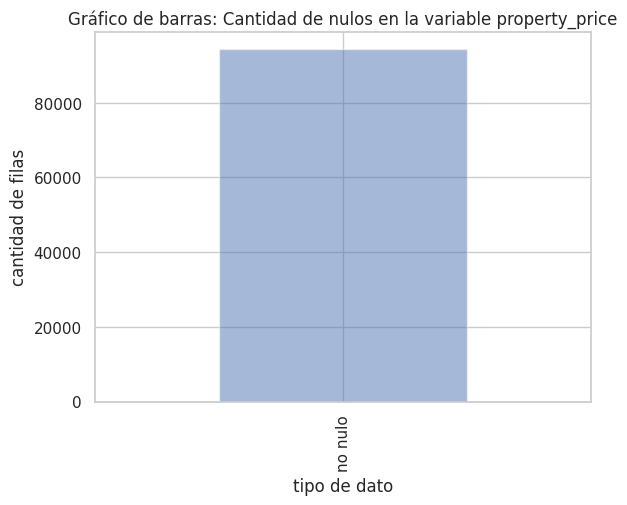

In [322]:
precio.value_counts().plot.bar(alpha=0.5,title="Gráfico de barras: Cantidad de nulos en la variable property_price", xlabel="tipo de dato" , ylabel="cantidad de filas")

### Análisis de datos faltantes a nivel fila

Realizar un análisis de datos faltantes a nivel de fila. Calcular el porcentaje de datos
faltantes de cada registro. Realizar un gráfico que permita conocer la proporción de
faltantes por fila en el dataset.


In [323]:
# Calcular la cantidad de filas nulas
cantidad_filas_nulas = ds_propiedades_filtradas.isna().sum(axis=1)
filtro = cantidad_filas_nulas > 0
cantidad_filas_nulas = cantidad_filas_nulas[filtro]
print("La cantidad de filas que tienen al menos un dato nulo es: ",len(cantidad_filas_nulas))

La cantidad de filas que tienen al menos un dato nulo es:  21386


<Axes: title={'center': 'Gráfico de barras: Cantidad de filas nulas en el ds'}, xlabel='cantidad de nulos', ylabel='cantidad de filas'>

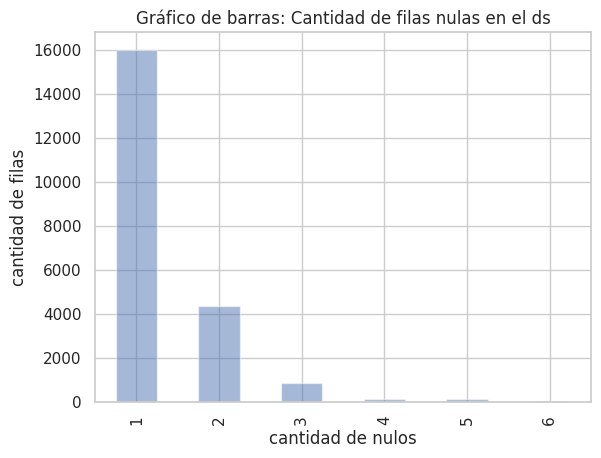

In [324]:
cantidad_filas_nulas.value_counts().plot.bar(alpha=0.5,title="Gráfico de barras: Cantidad de filas nulas en el ds", xlabel="cantidad de nulos" , ylabel="cantidad de filas")

### Revisión de datos faltantes o mal ingresados

Revisar los datos faltantes o mal ingresados y tomar una decisión sobre estos: reemplazo de
valores, eliminación de registros incompletos, etc.

Recordemos los datos nulos que tenemos en ds_propiedades_filtradas

In [325]:
obtener_cantidad_nulos(ds_propiedades_filtradas)

property_bedrooms           11.657418
property_surface_total       5.139577
latitud                      3.957602
longitud                     3.957602
property_surface_covered     3.558658
property_rooms               1.107704
place_l3                     0.442445
dtype: float64

Veremos unas de las estrategias para para trabajar con datos faltantes. Procederemos a imputar datos

#### Imputación Cold Deck
Vamos a trabajar con los datos ```latitud``` y ```longitud``` para completar la variable ```place_l3```.
Para ello vamos a utilizar el csv ```barrios.csv``` provisto por [GCBA](https://data.buenosaires.gob.ar/dataset/barrios/resource/juqdkmgo-191-resource) que nos da la localización y límites geográficos de los barrios de la Ciudad.

Antes de imputar vamos a hacer una copia para analizar la imputación en el siguiente punto.

In [326]:
ds_pre_imputacion = ds_propiedades_filtradas.copy()

Para ello vamos a usar Geopandas correspondiente a la documentación wkt

In [327]:
ds_barrios = pd.read_csv(barrios_file, header=0,sep=';')
def completar_barrios(ds):
  for index, propiedad in ds.iterrows():
    if isinstance(propiedad["place_l3"], str):
      continue

    for index,barrio in ds_barrios.iterrows():
      barrio_aux = barrio['BARRIO']
      if barrio_aux == '' or barrio_aux is None:
        continue
      coordenada = Point(propiedad['longitud'],propiedad['latitud'])
      # uso wkt Para deserializar una cadena y obtener un nuevo objeto geométrico del tipo apropiado
      # uso covers para ver si está cubierta la coordenada de ds_barrios por lo que tiene mi ds
      if wkt.loads(barrio['WKT']).covers(coordenada):
        ds.loc[index,'place_l3'] = barrio_aux

  return

completar_barrios(ds_propiedades_filtradas)

Visualizamos el dataset para ver si podemos ver algún nulo rápido.

In [328]:
# Ordenar el DataFrame por 'place_l3'
ds_sorted = ds_propiedades_filtradas.sort_values(by='place_l3')

# Extraer la columna 'place_l3'
place_l3_column = ds_sorted['place_l3']

# Elimino la columna 'place_l3' del DataFrame
ds_sorted.drop(columns=['place_l3'], inplace=True)

# Inserto la columna 'place_l3' en la primera posición
ds_sorted.insert(0, 'place_l3', place_l3_column)

# Ahora ds_sorted tiene 'place_l3' como la primera columna
# para visualizarlo mejor
ds_sorted

place_l3                        id start_date    end_date    latitud  \
27      AGRONOMIA                       NaN        NaT         NaN        NaN   
4         ALMAGRO                       NaN        NaT         NaN        NaN   
238099     Abasto  ImFxUxZ/Adwif99ssEnkQA== 2021-02-27  2021-06-05 -34.602294   
293040     Abasto  /KT4ewEmlVgjHJ3Vl2MGJQ== 2021-02-23  2021-06-04 -34.605274   
290416     Abasto  eU3zFc4TC08khKb7a6RXZQ== 2021-10-20  2022-01-27 -34.605036   
...           ...                       ...        ...         ...        ...   
458690        NaN  uzOE5TSle78c4dgqiJ8hYg== 2021-01-05  2021-03-01        NaN   
458696        NaN  UxrImoZVU0nEah53uM/NSg== 2021-01-05  2021-03-01        NaN   
459187        NaN  eKBe4k1ocBLyz6ntXQfPiQ== 2021-01-05  2021-03-01        NaN   
459195        NaN  E8hNlBjeRdD9Cr759qVghQ== 2021-01-05  2021-03-01        NaN   
459199        NaN  oYcjmcAXiY+MSWKw0iU28Q== 2021-01-05  2021-03-01        NaN   

         longitud property_type  property_rooms  property_bedrooms  \
27            NaN           NaN             NaN                NaN   
4             NaN           NaN             NaN                NaN   
238099 -58.409571  Departamento             2.0                1.0   
293040 -58.410103  Departamento             3.0                2.0   
290416 -58.406944  Departamento             3.0                2.0   
...           ...           ...             ...                ...   
458690        NaN          Casa             NaN                2.0   
458696        NaN          Casa             NaN                2.0   
459187        NaN  Departamento             2.0                1.0   
459195        NaN  Departamento             2.0                1.0   
459199        NaN  Departamento             3.0                2.0   

        property_surface_total  property_surface_covered  property_price  
27                         NaN                       NaN             NaN  
4                          NaN                       NaN             NaN  
238099                    43.0                      40.0        125000.0  
293040                    58.0                      52.0         82000.0  
290416                    53.0                      53.0         85000.0  
...                        ...                       ...             ...  
458690                     NaN                      80.0        120000.0  
458696                    60.0                      60.0         75000.0  
459187                    41.0                      41.0         75000.0  
459195                    44.0                      44.0        128000.0  
459199                    70.0                      70.0        155000.0  

[94269 rows x 12 columns]

Vemos que hay datos NaN en el barrio

In [329]:
ds_propiedades_filtradas['place_l3'].isna().value_counts()

place_l3
False    93852
True       417
Name: count, dtype: int64

Estos datos en NaN pueden ser datos mal ingresados. Se ingresó mal la coordenada de la propiedad y se la clasificó como Capital Federal. Lo mismo puede suceder de que no tengan latitud ni longitud. Procedo a eliminar dichos datos

In [330]:
columnas_a_eliminar = ['latitud','longitud','place_l3']
ds_propiedades_filtradas = ds_propiedades_filtradas.dropna(subset=columnas_a_eliminar)

Verifico mis datos_nulos en mi dataset

In [331]:
obtener_cantidad_nulos(ds_propiedades_filtradas)

property_bedrooms           11.550647
property_surface_total       5.039215
property_surface_covered     3.529334
property_rooms               0.962646
dtype: float64

#### Análisis de property's
Ahora vamos a seguir con el análisis de las siguientes variables:
*     property_bedrooms
*     property_rooms
*     property_surface_total
*     property_surface_covered

Podemos identificar que estas variables son tipos de datos faltantes MAR.

##### Análisis de ceros

Para empezar verifico si alguno de estos datos es negativo. Pues valores negativos para alguno de estos atributos no tiene sentido.

In [332]:
columnas_con_numeros = ['property_bedrooms','property_rooms','property_surface_total','property_surface_covered']
(ds_propiedades_filtradas[columnas_con_numeros] <= 0).any().to_frame("Menor o igual que 0 ?")

Menor o igual que 0 ?
property_bedrooms                          True
property_rooms                            False
property_surface_total                    False
property_surface_covered                  False

Vemos que existen valores menores o iguales que 0 en el atributo ```property_bedrooms```. Procedo a ver cuantos registros cumplen con esta condición.

In [333]:
filtro = ds_propiedades_filtradas['property_bedrooms'] < 1
ds_propiedades_filtradas[filtro]

id start_date    end_date    latitud   longitud  \
406880  3WI+zCCMeb9TR5kOBm7rhg== 2021-01-07  2021-03-18 -34.577595 -58.495185   

             place_l3 property_type  property_rooms  property_bedrooms  \
406880  Villa Urquiza  Departamento             2.0               -1.0   

        property_surface_total  property_surface_covered  property_price  
406880                    61.0                      43.0        125000.0

Como hay un registro, procederemos a asignarlo nulo.

In [334]:
ds_propiedades_filtradas.loc[ds_propiedades_filtradas['property_bedrooms'] < 1,'property_bedrooms'] = np.nan

Se verifica si hay valores menores o iguales que cero.

In [335]:
columnas_con_numeros = ['property_bedrooms','property_rooms','property_surface_total','property_surface_covered']
(ds_propiedades_filtradas[columnas_con_numeros] <= 0).any().to_frame("Menor o igual que 0 ?")

Menor o igual que 0 ?
property_bedrooms                         False
property_rooms                            False
property_surface_total                    False
property_surface_covered                  False

##### Análisis de duplicados

Verificamos si hay datos duplicados en estas columnas

In [336]:
ds_propiedades_filtradas[ds_propiedades_filtradas.duplicated(keep=False)]

Empty DataFrame
Columns: [id, start_date, end_date, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

Procederemos a eliminar filas duplicadas

In [337]:
size_antes = len(ds_propiedades_filtradas)
ds_propiedades_filtradas_sin_dup = ds_propiedades_filtradas.drop_duplicates()
size_despues = len(ds_propiedades_filtradas_sin_dup)
print(f"Se eliminaron: {size_antes-size_despues} filas duplicadas del ds")

Se eliminaron: 0 filas duplicadas del ds


In [338]:
ds_propiedades_filtradas_sin_dup.reset_index(drop=True, inplace=True)

##### Completacion de las columnas de forma multivariada

Como las variables faltantes son datos de tipo MAR (Missing At Random), elijiremos el proceso de imputación de datos MICE (Multivariate Imputation by Chained Equations)

In [339]:
# la variable columnas_con_numeros tiene las columnas a analizar
lr = LinearRegression()
imp = IterativeImputer(
    estimator=lr,
    missing_values = np.nan,
    max_iter = 20,
    verbose = 0,
    random_state = 0,
    min_value = 1
)


def rellenar_variables(ds,columnas):
  df_eliminar_nans_op3_completo = ds[columnas].copy()
  ds[columnas] = imp.fit_transform(df_eliminar_nans_op3_completo)

rellenar_variables(ds_propiedades_filtradas,columnas_con_numeros)

ds_propiedades_filtradas[columnas_con_numeros] = ds_propiedades_filtradas[columnas_con_numeros].round()

In [340]:
obtener_promedio_nulos(ds_propiedades_filtradas)

id                          0.0
start_date                  0.0
end_date                    0.0
latitud                     0.0
longitud                    0.0
place_l3                    0.0
property_type               0.0
property_rooms              0.0
property_bedrooms           0.0
property_surface_total      0.0
property_surface_covered    0.0
property_price              0.0
dtype: float64

In [341]:
obtener_cantidad_nulos(ds_propiedades_filtradas)

'No existen valores NaN'

### Comparación de distribuciones
En caso de realizar imputaciones comparar las distribuciones de cada atributo reparado con
la distribución anterior a la imputación de los datos faltantes.

Para ello veamos nuestro ```ds_pre_imputacion```

In [342]:
ds_pre_imputacion.head()

id start_date    end_date    latitud   longitud  \
25  CyZu6IaZgmQYGk8jmPajCg== 2021-09-09  2021-09-26        NaN        NaN   
42  d3Z0MblSb2IMBoOBMGJEEQ== 2021-09-09  2021-09-26 -34.637319 -58.361124   
43  rL7qPkQnomsMGu2ViS3sBw== 2021-09-09  2021-09-28 -34.628647 -58.361871   
49  vuX/ccLAMVml4qWRFcOJUA== 2021-09-09  2022-01-05 -34.610027 -58.401934   
51  ZTtSCeqZ3HUgf5jjwEzRcw== 2021-09-09  2022-03-09 -34.631621 -58.416825   

   place_l3 property_type  property_rooms  property_bedrooms  \
25      NaN          Casa             4.0                3.0   
42     Boca  Departamento             3.0                2.0   
43     Boca  Departamento             4.0                3.0   
49     Once  Departamento             4.0                2.0   
51    Boedo            PH             4.0                2.0   

    property_surface_total  property_surface_covered  property_price  
25                   171.0                     133.0        210000.0  
42                    58.0                      55.0         82900.0  
43                    70.0                      70.0         99000.0  
49                     NaN                     104.0        146000.0  
51                     NaN                      73.0        250000.0

Recordemos que datos imputamos

In [343]:
nulos_preimputacion

property_bedrooms           11.657418
property_surface_total       5.139577
latitud                      3.957602
longitud                     3.957602
property_surface_covered     3.558658
property_rooms               1.107704
place_l3                     0.442445
dtype: float64

In [344]:
nulos_preimputacion.index.tolist()

['property_bedrooms',
 'property_surface_total',
 'latitud',
 'longitud',
 'property_surface_covered',
 'property_rooms',
 'place_l3']

Para ver la distribuciones de las variables imputadas vamos a utilizar un gráfico de distribución continua BoxPlot. El cual nos va a ayudar a visualizar la distribución de los datos y la asimetría de los mismos mediante la visualización de cuartiles y promedios de los datos.

#### Funciones de distribución

In [345]:
def generar_distribucion(variable):
  # Configuración de estilo y colores
  sns.set(style="whitegrid")
  sns.set_palette("pastel")

  # Creo la cuadrícula de subgráficos con una fila y dos columnas
  fig, axes = plt.subplots(1, 2, figsize=(12, 12))

  # Genero boxplot para ds_pre_imputacion en el primer subgráfico
  sns.boxplot(y=variable, data=ds_pre_imputacion, ax=axes[0], width=0.5)
  axes[0].set_title("Boxplot {} pre-imputación".format(variable), fontsize=14)
  axes[0].set_ylabel("Valor", fontsize=12)
  axes[0].set_xlabel("", fontsize=12)

  # Genero boxplot para ds_propiedades_filtradas en el segundo subgráfico
  sns.boxplot(y=variable, data=ds_propiedades_filtradas, ax=axes[1], width=0.5)
  axes[1].set_title("Boxplot {} post-imputación".format(variable), fontsize=14)
  axes[1].set_ylabel("Valor", fontsize=12)
  axes[1].set_xlabel("", fontsize=12)

  # Ajusto el diseño
  plt.tight_layout()

  plt.show()

  return

In [346]:
def generar_distribucion_zoom(variable):
  fig, axes = plt.subplots(1, 2, figsize=(12, 12))

  # Genero boxplot para ds_pre_imputacion en el primer subgráfico
  sns.boxplot(y=variable, data=ds_pre_imputacion, ax=axes[0])
  axes[0].set_title("Boxplot {} pre-imputacion".format(variable))
  axes[0].set_ylim(0, 10)  # Ajustar el rango del eje y

  # Genero boxplot para ds_propiedades_filtradas en el segundo subgráfico
  sns.boxplot(y=variable, data=ds_propiedades_filtradas, ax=axes[1])
  axes[1].set_title("Boxplot {} post-imputacion".format(variable))
  axes[1].set_ylim(0, 10)  # Ajustar el rango del eje y

  # Ajustar el diseño
  plt.tight_layout()

  plt.show()
  return

In [347]:
def obtener_cantidad_variables(ds,columna):
  analisis = ds[columna].value_counts().reset_index()
  analisis.columns = [columna, 'cantidad']
  return analisis

In [348]:
def comparar_imputacion(pre, post, columna):
    longitud_post = len(post)
    longitud_pre = len(pre)

    for i in range(longitud_post):
        # Verificar si i es mayor que la longitud de pre
        if i >= longitud_pre:
            print("i es mayor que la longitud de pre. Se corta el bucle.")
            break

        registros_imputados = post['cantidad'][i] - pre['cantidad'][i]
        registros_imputados = abs(registros_imputados)  # Tomar el valor absoluto
        print("{} registros se imputaron con el valor de {} {}".format(registros_imputados, post[columna][i], columna))

    return

#### Comparación property_bedrooms

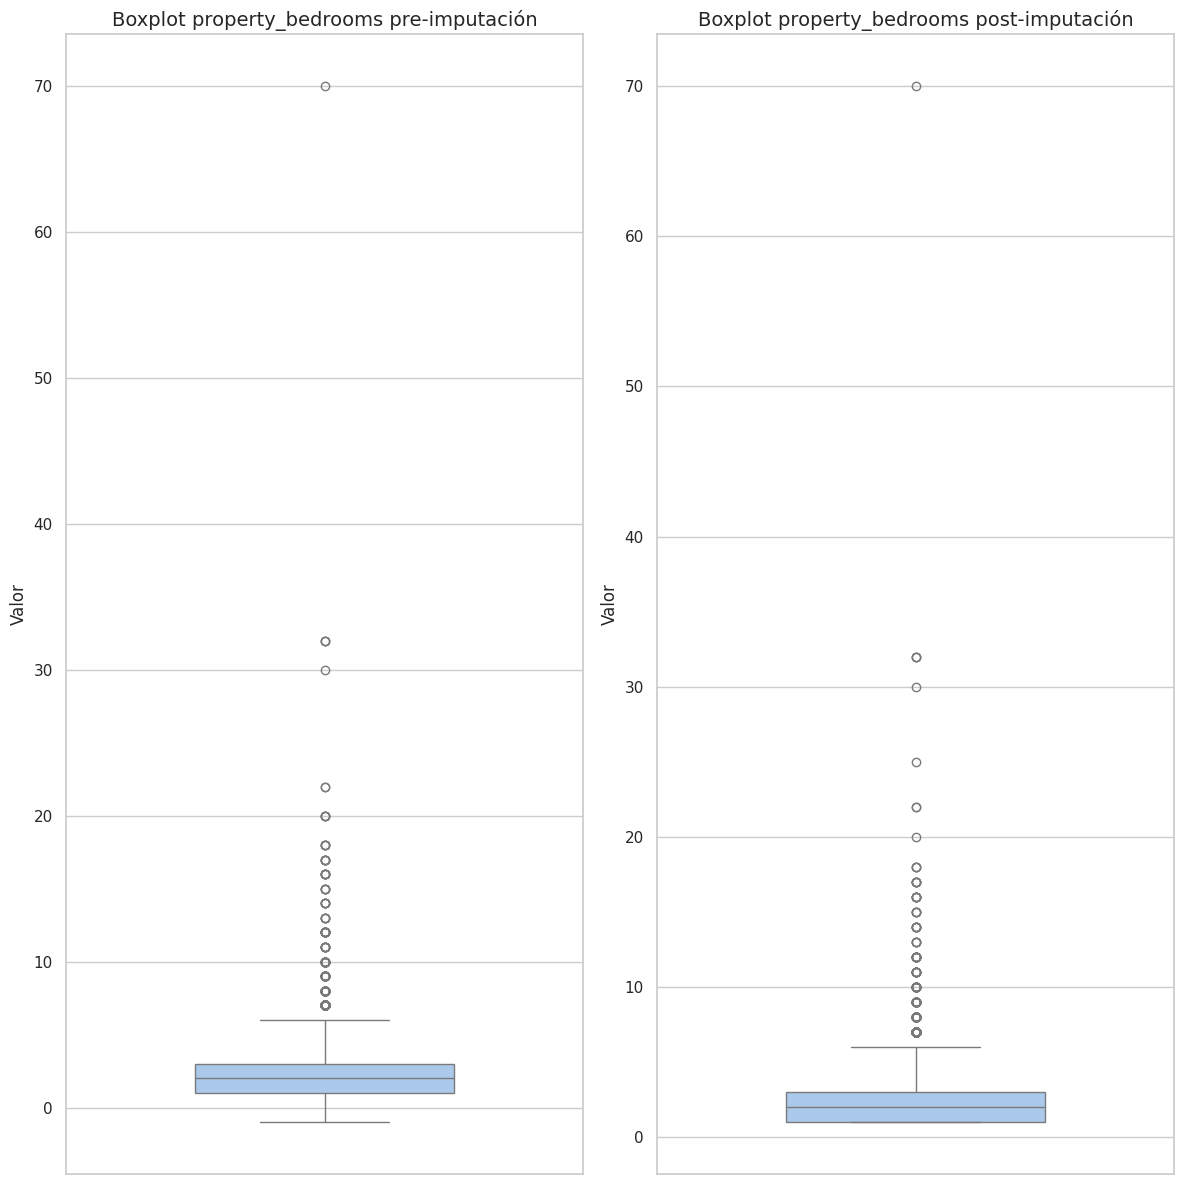

In [349]:
generar_distribucion("property_bedrooms")

Un poco de zoom

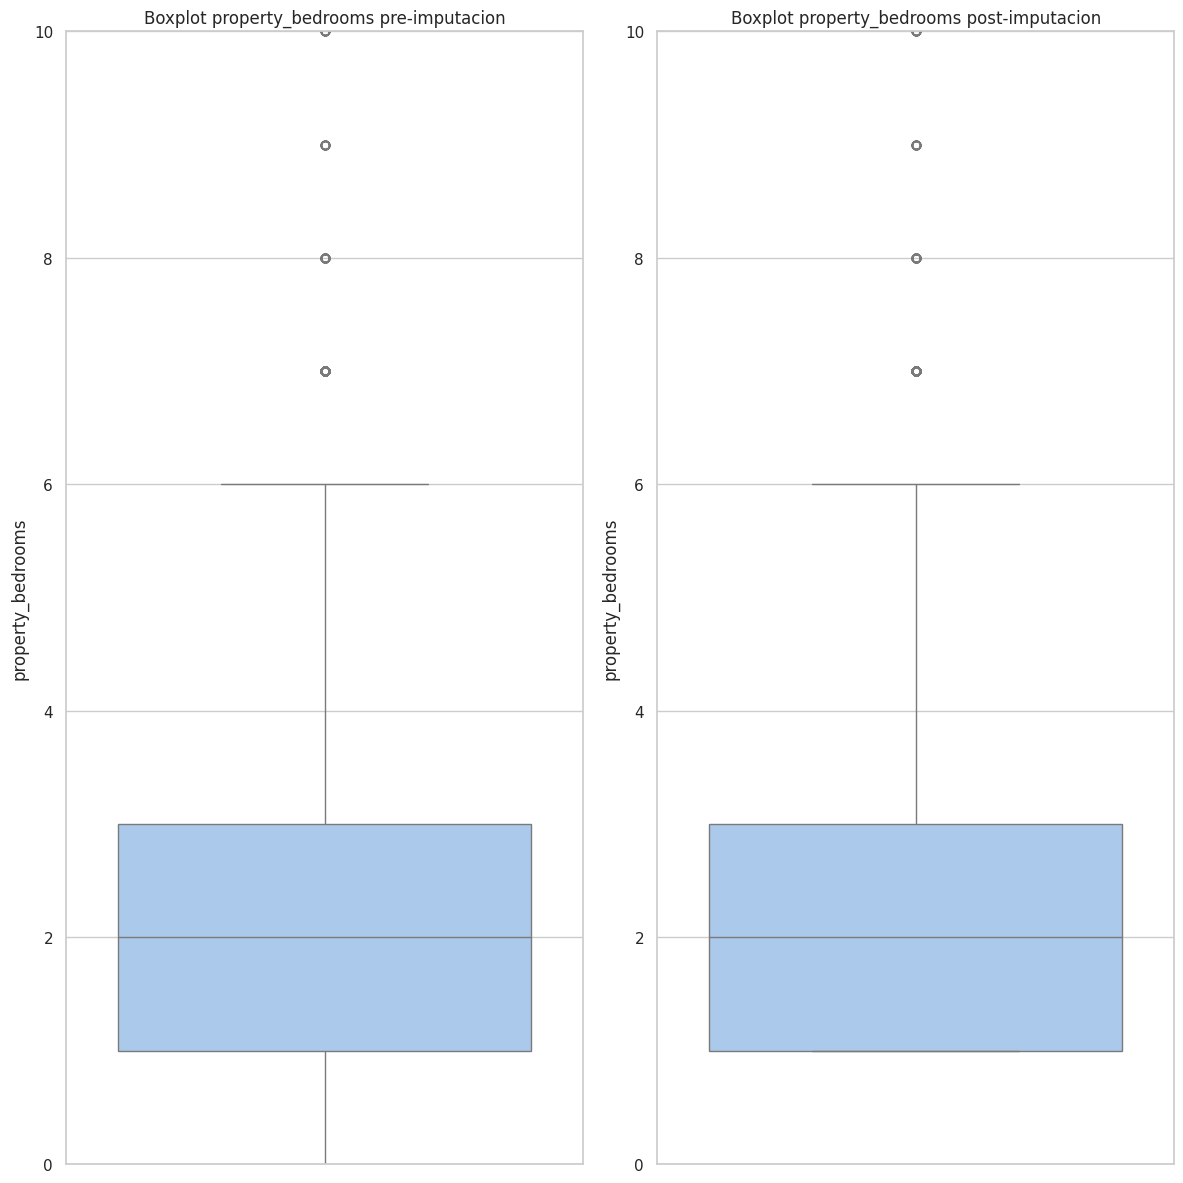

In [350]:
generar_distribucion_zoom("property_bedrooms")

La comparación de los boxplots revela una gran coherencia en la distribución de la variable entre los conjuntos de datos antes y después de la imputación. Aunque se observa una discrepancia leve entre los valores de aproximadamente 20 y 30, esta diferencia es mínima en comparación con la totalidad de los datos. Esto sugiere que las imputaciones se realizaron de manera consistente y dentro de los límites razonables de la variable, sin introducir valores atípicos o extremos.

Vamos a analizar cada property_bedrooms

In [351]:
pre_bedrooms = obtener_cantidad_variables(ds_pre_imputacion,'property_bedrooms')
pre_bedrooms.head()

property_bedrooms  cantidad
0                1.0     31947
1                2.0     27414
2                3.0     17656
3                4.0      4797
4                5.0       928

In [352]:
post_bedrooms = obtener_cantidad_variables(ds_propiedades_filtradas,'property_bedrooms')
post_bedrooms.head()

property_bedrooms  cantidad
0                1.0     40258
1                2.0     27018
2                3.0     17038
3                4.0      4566
4                5.0       873

Con esto podemos ver la cantidad de imputaciones que se hicieron gracias al método MICE.

In [353]:
comparar_imputacion(pre_bedrooms,post_bedrooms,'property_bedrooms')

8311 registros se imputaron con el valor de 1.0 property_bedrooms
396 registros se imputaron con el valor de 2.0 property_bedrooms
618 registros se imputaron con el valor de 3.0 property_bedrooms
231 registros se imputaron con el valor de 4.0 property_bedrooms
55 registros se imputaron con el valor de 5.0 property_bedrooms
11 registros se imputaron con el valor de 6.0 property_bedrooms
6 registros se imputaron con el valor de 7.0 property_bedrooms
0 registros se imputaron con el valor de 8.0 property_bedrooms
3 registros se imputaron con el valor de 9.0 property_bedrooms
1 registros se imputaron con el valor de 10.0 property_bedrooms
0 registros se imputaron con el valor de 12.0 property_bedrooms
3 registros se imputaron con el valor de 11.0 property_bedrooms
0 registros se imputaron con el valor de 14.0 property_bedrooms
1 registros se imputaron con el valor de 16.0 property_bedrooms
0 registros se imputaron con el valor de 17.0 property_bedrooms
0 registros se imputaron con el valor 

Podemos concluir que la mayoría de los datos nulos en la variable property_bedrooms fueron llenados con la cantidad de un dormitorio

#### Comparación property_rooms

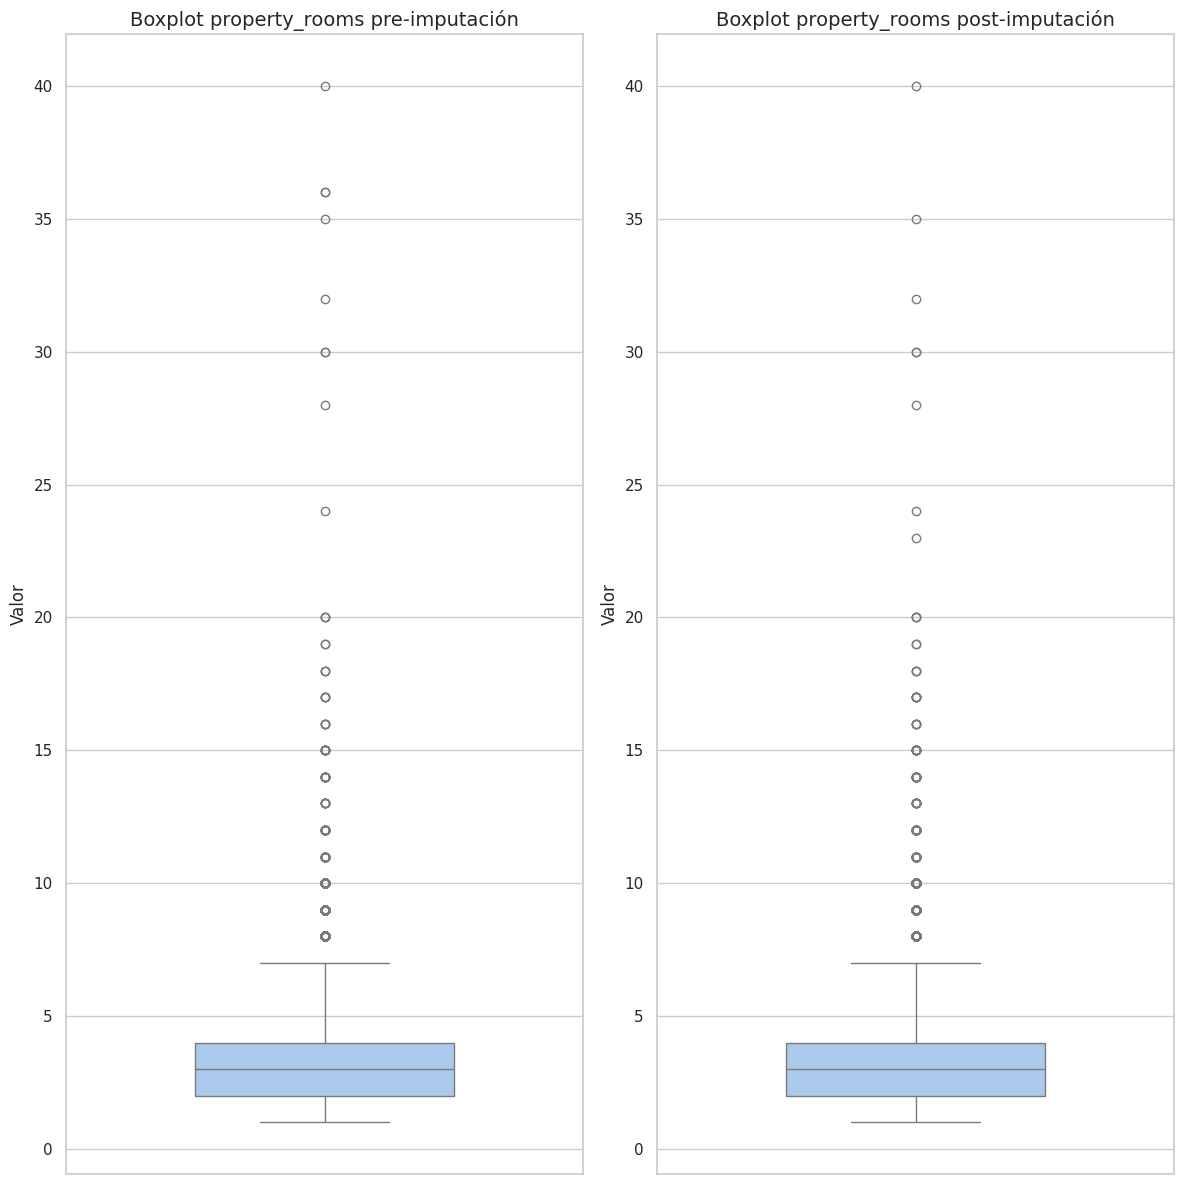

In [354]:
generar_distribucion("property_rooms")

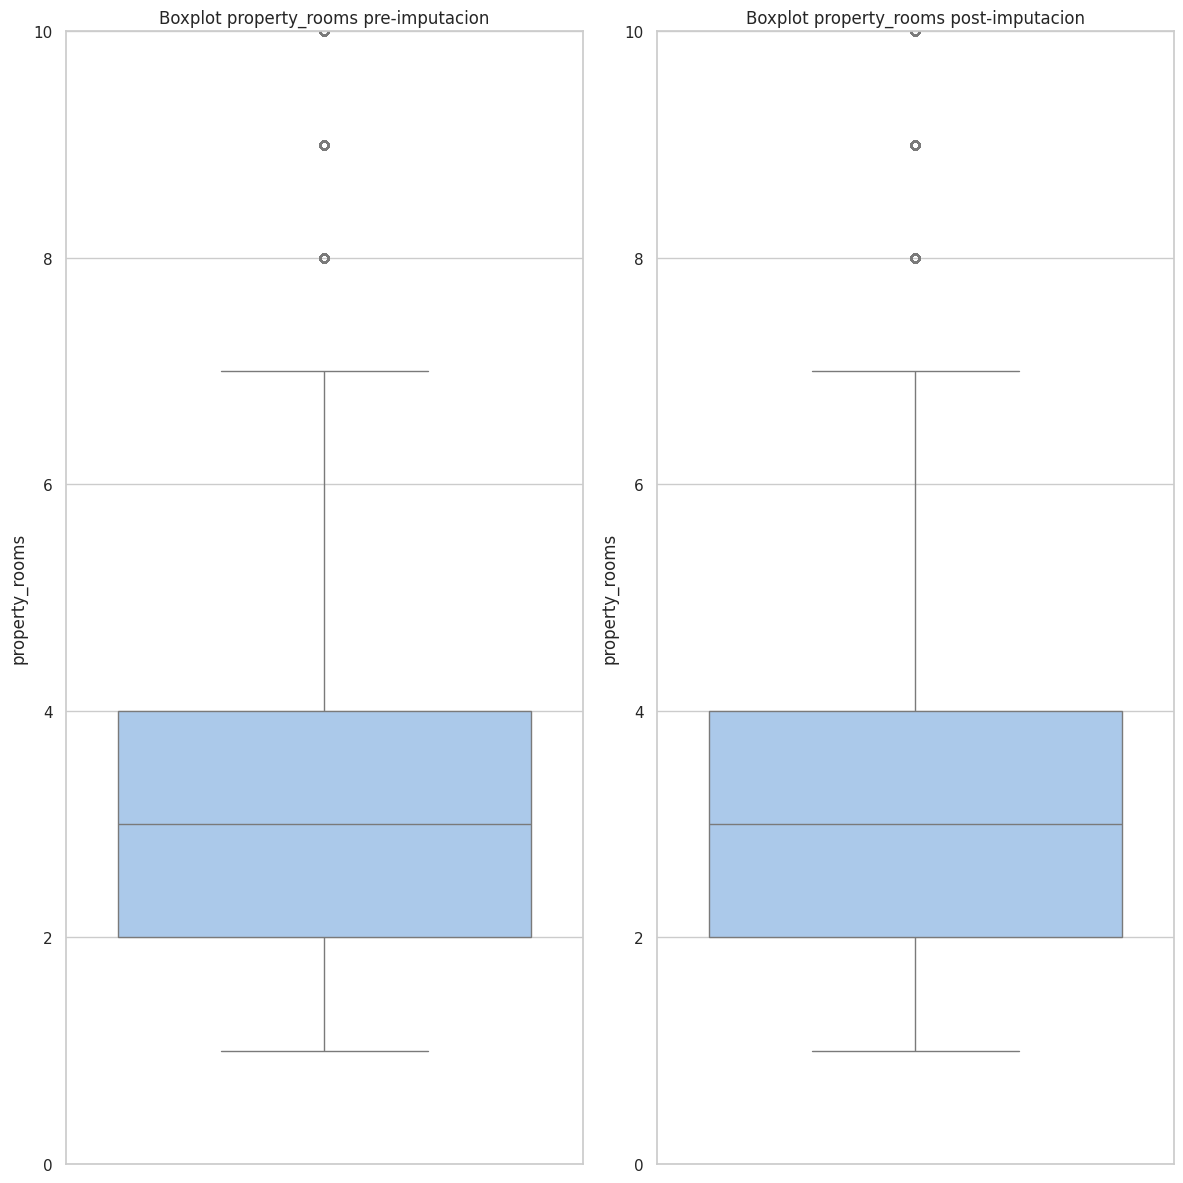

In [355]:
generar_distribucion_zoom("property_rooms")

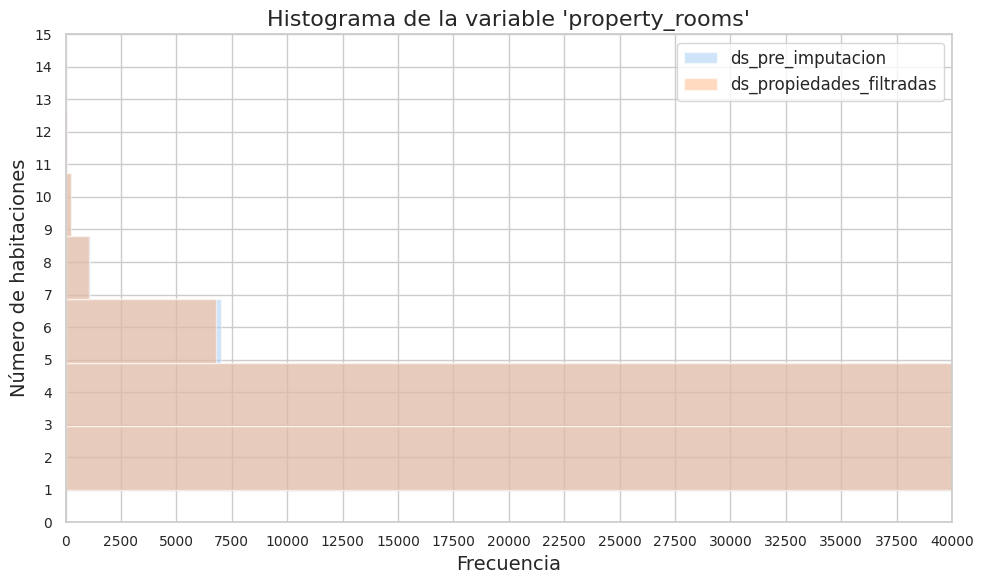

In [356]:
# Configuración de estilo y colores
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Crear la figura y los ejes
plt.figure(figsize=(10, 6))

# Histograma para ds_pre_imputacion en el eje y (invertido)
plt.hist(ds_pre_imputacion['property_rooms'], bins=20, alpha=0.5, orientation='horizontal', label='ds_pre_imputacion')

# Histograma para ds_propiedades_filtradas en el eje y (invertido)
plt.hist(ds_propiedades_filtradas['property_rooms'], bins=20, alpha=0.5, orientation='horizontal', label='ds_propiedades_filtradas')

# Ajustes de título y etiquetas
plt.title("Histograma de la variable 'property_rooms'", fontsize=16)
plt.xlabel("Frecuencia", fontsize=14)
plt.ylabel("Número de habitaciones", fontsize=14)

# Ajustes de límites de los ejes (zoom)
plt.ylim(0, 15)
plt.xlim(0, 40000)

# Establecer intervalos del eje x
plt.xticks(np.arange(0, 40001, 2500), fontsize=10)

# Añadir leyenda
plt.legend(fontsize=12)

# Establecer intervalos del eje y
plt.yticks(np.arange(16), fontsize=10)

plt.tight_layout()
plt.show()

<Axes: xlabel='property_rooms'>

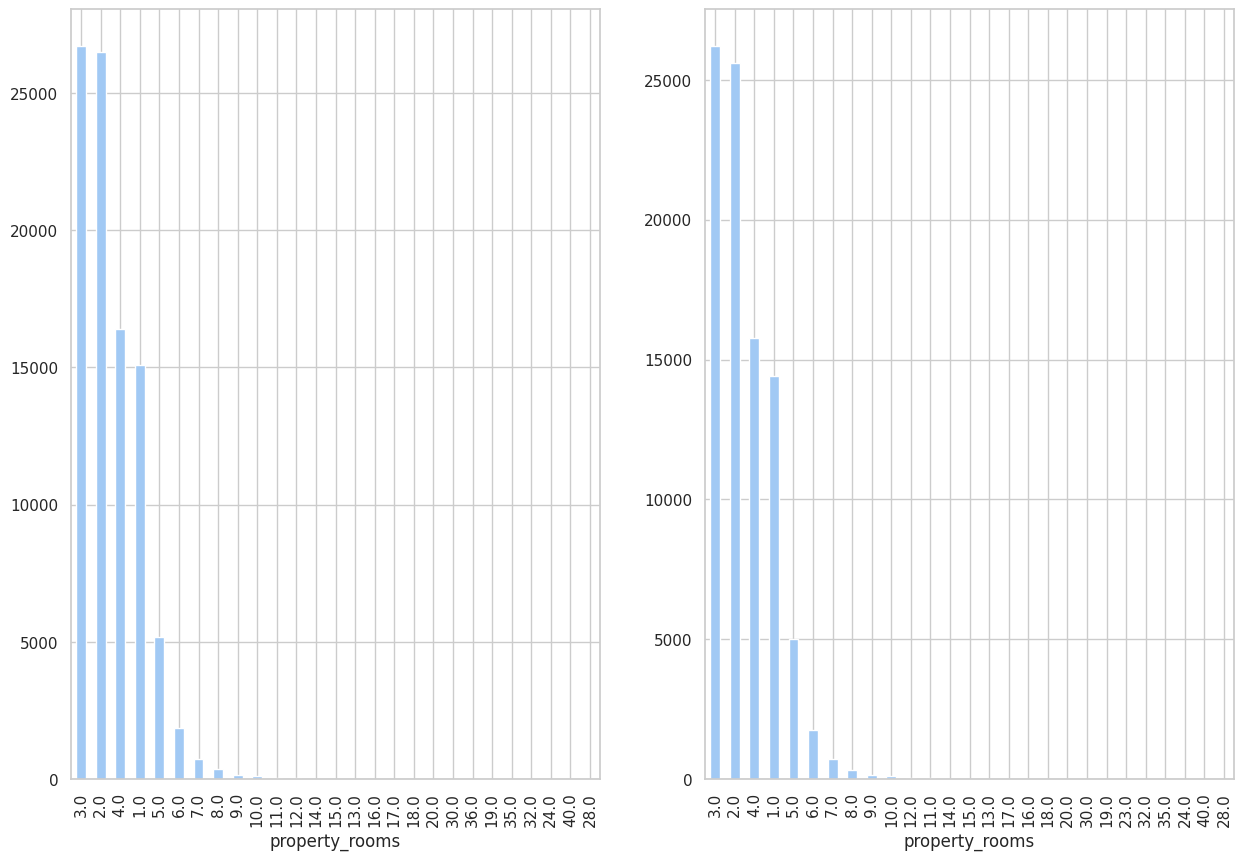

In [357]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15,10)
ds_pre_imputacion["property_rooms"].value_counts().plot.bar(ax=axes[0])
ds_propiedades_filtradas["property_rooms"].round().value_counts().plot.bar(ax=axes[1])

A través de estos gráficos, se observan sutiles discrepancias al asignar la cantidad de habitaciones a la hora de realizar la imputación.

In [358]:
pre_rooms = obtener_cantidad_variables(ds_pre_imputacion,'property_rooms')
pre_rooms.head()

property_rooms  cantidad
0             3.0     26714
1             2.0     26496
2             4.0     16405
3             1.0     15084
4             5.0      5171

In [359]:
post_rooms = obtener_cantidad_variables(ds_propiedades_filtradas,'property_rooms')
post_rooms.head()

property_rooms  cantidad
0             3.0     26211
1             2.0     25617
2             4.0     15779
3             1.0     14428
4             5.0      5015

In [360]:
comparar_imputacion(pre_rooms,post_rooms,'property_rooms')

503 registros se imputaron con el valor de 3.0 property_rooms
879 registros se imputaron con el valor de 2.0 property_rooms
626 registros se imputaron con el valor de 4.0 property_rooms
656 registros se imputaron con el valor de 1.0 property_rooms
156 registros se imputaron con el valor de 5.0 property_rooms
86 registros se imputaron con el valor de 6.0 property_rooms
33 registros se imputaron con el valor de 7.0 property_rooms
17 registros se imputaron con el valor de 8.0 property_rooms
8 registros se imputaron con el valor de 9.0 property_rooms
2 registros se imputaron con el valor de 10.0 property_rooms
8 registros se imputaron con el valor de 12.0 property_rooms
3 registros se imputaron con el valor de 11.0 property_rooms
2 registros se imputaron con el valor de 14.0 property_rooms
1 registros se imputaron con el valor de 15.0 property_rooms
2 registros se imputaron con el valor de 13.0 property_rooms
2 registros se imputaron con el valor de 17.0 property_rooms
0 registros se imput

Podemos inferir que la mayoría de los valores faltantes en la variable "property_rooms" fueron sustituidos por la cantidad de dos habitaciones.

#### Comparación property_surface_total

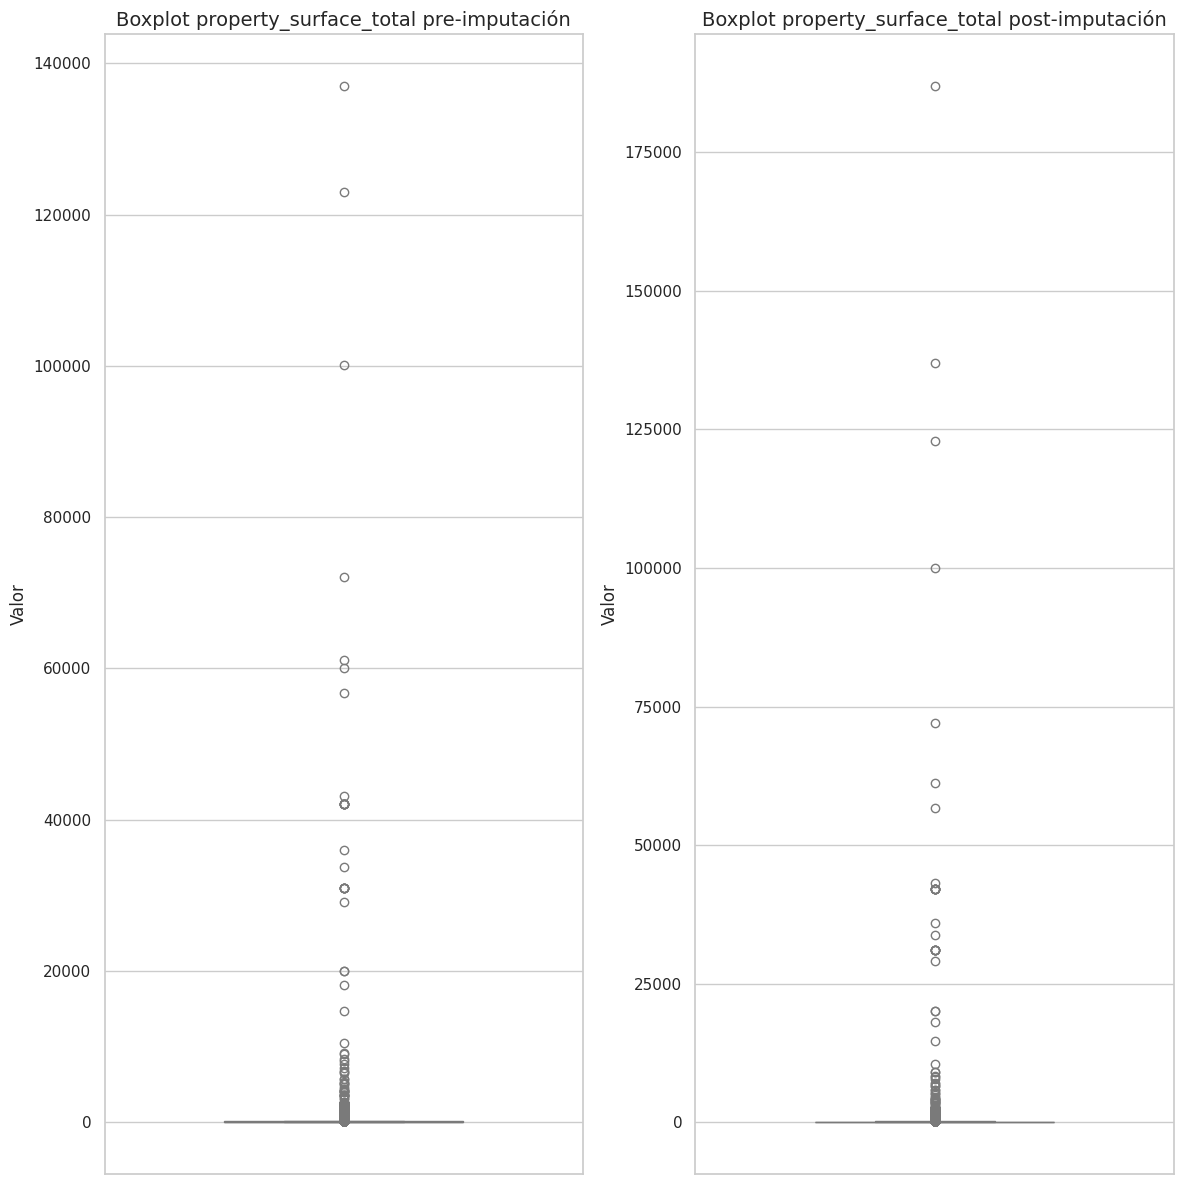

In [361]:
generar_distribucion("property_surface_total")

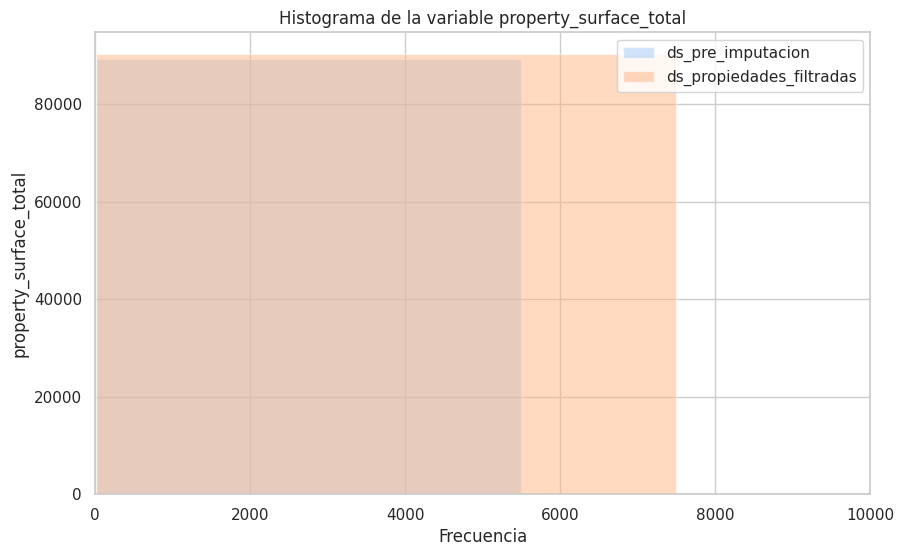

In [362]:
plt.figure(figsize=(10, 6))

plt.hist(ds_pre_imputacion['property_surface_total'], bins=25, alpha=0.5, label='ds_pre_imputacion')

plt.hist(ds_propiedades_filtradas['property_surface_total'], bins=25, alpha=0.5, label='ds_propiedades_filtradas')

plt.title("Histograma de la variable property_surface_total")
plt.xlabel("Frecuencia")
plt.ylabel("property_surface_total")

plt.xlim(0, 10000)

plt.legend()

plt.show()

Observamos una notable disparidad en la cantidad de datos faltantes antes de la imputación de la variable "superficie total".

In [363]:
pre_total = obtener_cantidad_variables(ds_pre_imputacion,'property_surface_total')
pre_total.head()

property_surface_total  cantidad
0                    50.0      1799
1                    40.0      1725
2                    45.0      1586
3                    42.0      1561
4                    60.0      1506

In [364]:
post_total = obtener_cantidad_variables(ds_propiedades_filtradas,'property_surface_total')
post_total.head()

property_surface_total  cantidad
0                    50.0      1867
1                    40.0      1754
2                    45.0      1581
3                    42.0      1546
4                    60.0      1477

In [365]:
comparar_imputacion(pre_total,post_total,'property_surface_total')

68 registros se imputaron con el valor de 50.0 property_surface_total
29 registros se imputaron con el valor de 40.0 property_surface_total
5 registros se imputaron con el valor de 45.0 property_surface_total
15 registros se imputaron con el valor de 42.0 property_surface_total
29 registros se imputaron con el valor de 60.0 property_surface_total
39 registros se imputaron con el valor de 35.0 property_surface_total
22 registros se imputaron con el valor de 55.0 property_surface_total
38 registros se imputaron con el valor de 38.0 property_surface_total
13 registros se imputaron con el valor de 44.0 property_surface_total
7 registros se imputaron con el valor de 37.0 property_surface_total
11 registros se imputaron con el valor de 43.0 property_surface_total
5 registros se imputaron con el valor de 36.0 property_surface_total
6 registros se imputaron con el valor de 47.0 property_surface_total
15 registros se imputaron con el valor de 48.0 property_surface_total
10 registros se imputaro

Podemos concluir que la mayoría de los valores faltantes en la variable "property_surface_total" fueron reemplazados con una superficie total de 33 m²


#### Comparación property_surface_covered

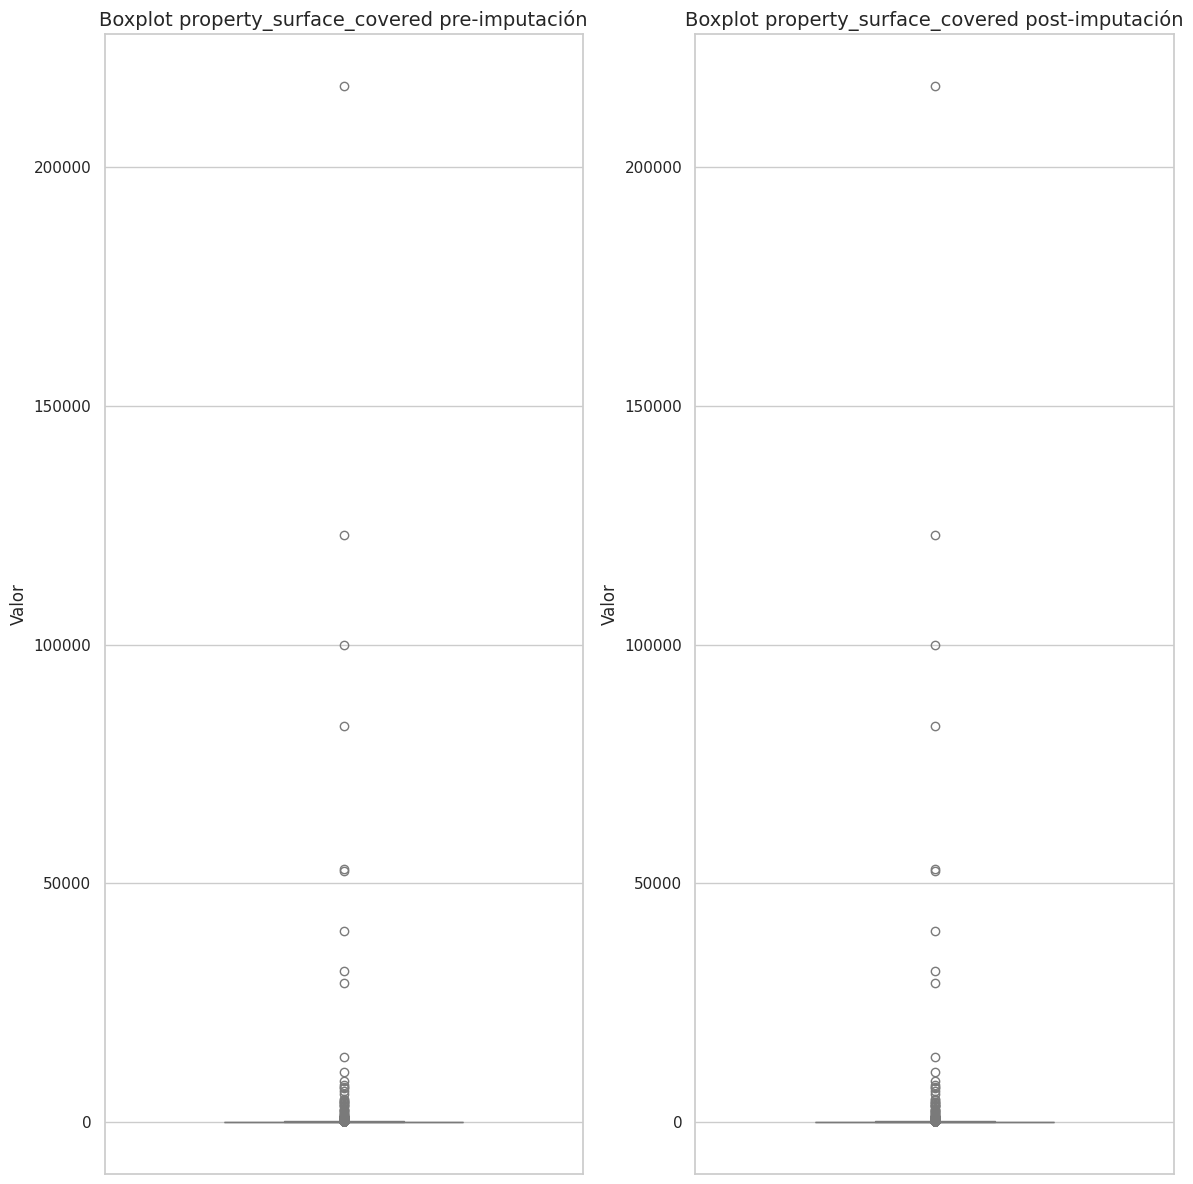

In [366]:
generar_distribucion("property_surface_covered")

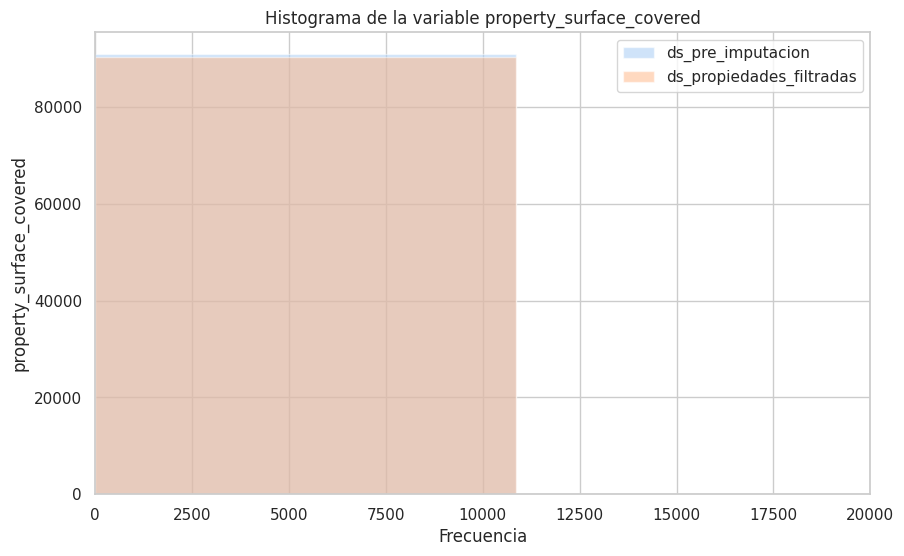

In [367]:
plt.figure(figsize=(10, 6))

plt.hist(ds_pre_imputacion['property_surface_covered'], bins=20, alpha=0.5,  label='ds_pre_imputacion')

plt.hist(ds_propiedades_filtradas['property_surface_covered'], bins=20, alpha=0.5,  label='ds_propiedades_filtradas')


plt.title("Histograma de la variable property_surface_covered")
plt.xlabel("Frecuencia")
plt.ylabel("property_surface_covered")


plt.xlim(0,20000)

plt.legend()

plt.show()

Se observa una ligera disparidad en los datos faltantes. Se puede inferir que se imputaron pocos datos para la variable "property_surface_covered", ya que esta variable era la que estaba entre los menos valores nulos.

In [368]:
pre_cubierto = obtener_cantidad_variables(ds_pre_imputacion,'property_surface_covered')
pre_cubierto.head()

property_surface_covered  cantidad
0                      40.0      2394
1                      38.0      2020
2                      50.0      2011
3                      45.0      1946
4                      35.0      1853

In [369]:
post_cubierto = obtener_cantidad_variables(ds_propiedades_filtradas,'property_surface_covered')
post_cubierto.head()

property_surface_covered  cantidad
0                      40.0      2352
1                      50.0      1959
2                      38.0      1949
3                      45.0      1880
4                      35.0      1834

In [370]:
comparar_imputacion(pre_cubierto,post_cubierto,'property_surface_covered')

42 registros se imputaron con el valor de 40.0 property_surface_covered
61 registros se imputaron con el valor de 50.0 property_surface_covered
62 registros se imputaron con el valor de 38.0 property_surface_covered
66 registros se imputaron con el valor de 45.0 property_surface_covered
19 registros se imputaron con el valor de 35.0 property_surface_covered
38 registros se imputaron con el valor de 42.0 property_surface_covered
27 registros se imputaron con el valor de 60.0 property_surface_covered
5 registros se imputaron con el valor de 37.0 property_surface_covered
32 registros se imputaron con el valor de 36.0 property_surface_covered
41 registros se imputaron con el valor de 32.0 property_surface_covered
53 registros se imputaron con el valor de 30.0 property_surface_covered
2 registros se imputaron con el valor de 34.0 property_surface_covered
18 registros se imputaron con el valor de 33.0 property_surface_covered
32 registros se imputaron con el valor de 43.0 property_surface_co

Podemos concluir que la mayoría de los valores faltantes en la variable "property_surface_covered" fueron completados con una superficie cubierta de 45 m²

#### Comparación latitud

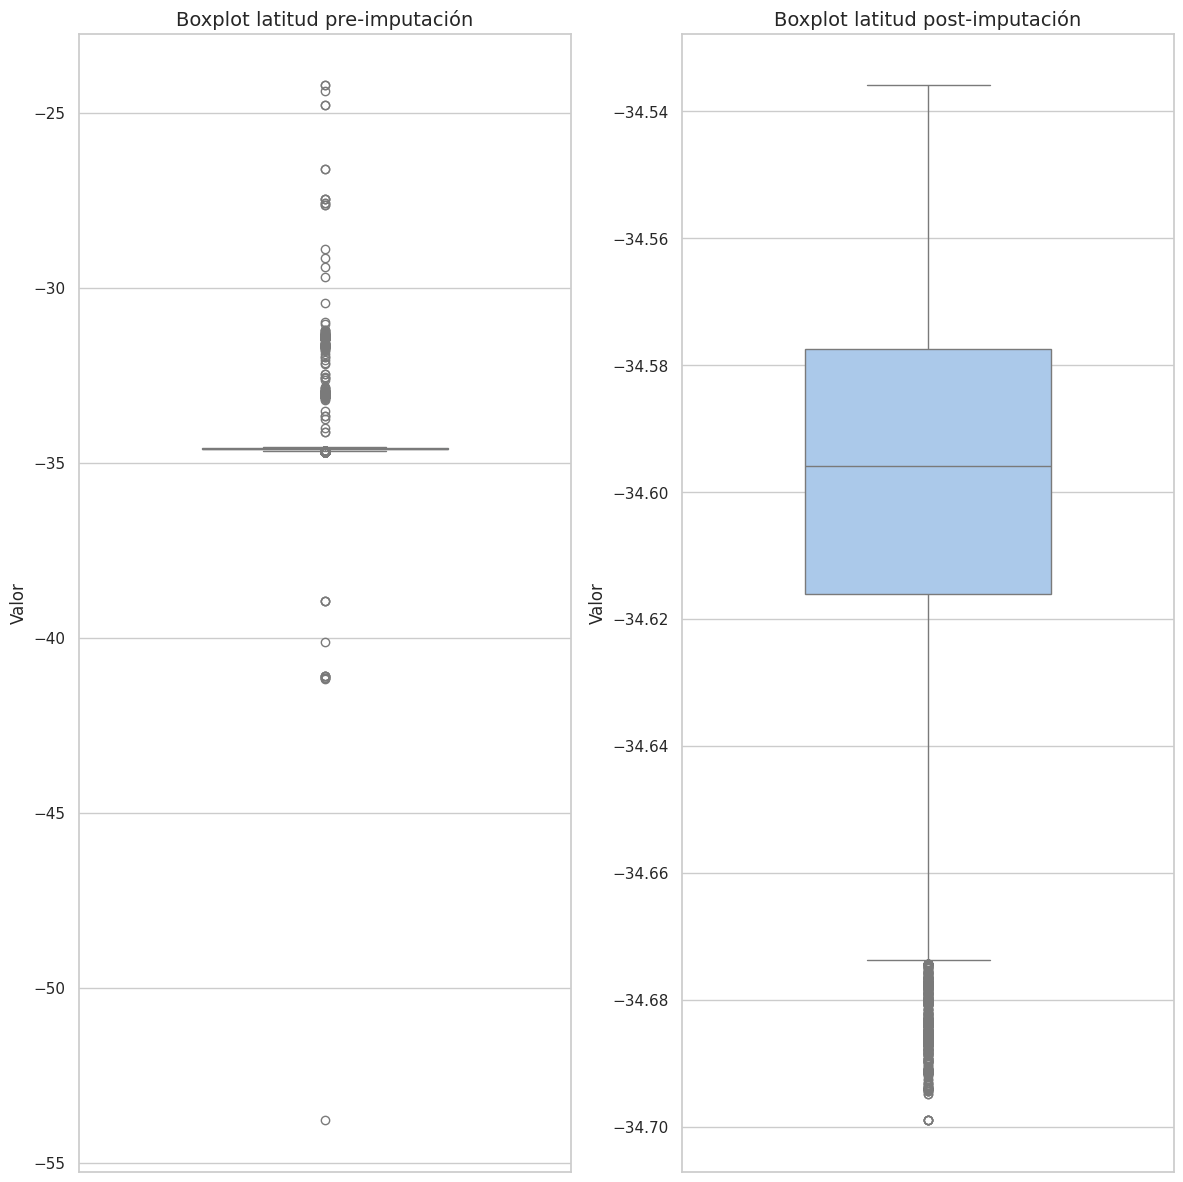

In [371]:
generar_distribucion("latitud")

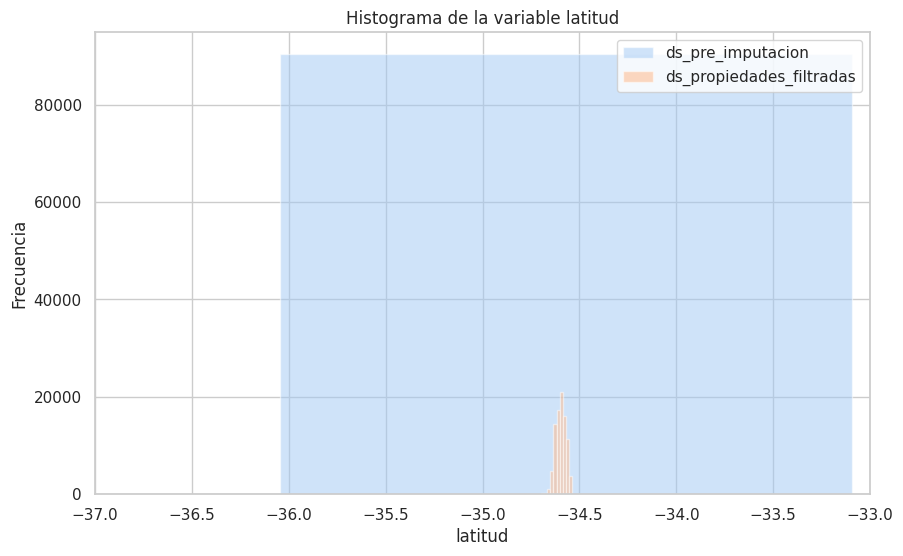

In [372]:
plt.figure(figsize=(10, 6))

plt.hist(ds_pre_imputacion['latitud'], bins=10, alpha=0.5, label='ds_pre_imputacion')

plt.hist(ds_propiedades_filtradas['latitud'], bins=10, alpha=0.5, label='ds_propiedades_filtradas')

plt.xlim(-37, -33)

plt.title("Histograma de la variable latitud")
plt.xlabel("latitud")
plt.ylabel("Frecuencia")

plt.legend()

plt.show()

Se puede observar que antes de la imputación, la latitud tenía una frecuencia constante para todos sus valores. Sin embargo, al imputar los datos, la frecuencia varía más, generando una distribución en forma de campana de Gauss. Se destaca que la latitud aproximada con la máxima cantidad de datos nulos completos es alrededor de -34.58.

In [373]:
pre_latitud = obtener_cantidad_variables(ds_pre_imputacion,'latitud')
pre_latitud

latitud  cantidad
0     -34.541250       150
1     -34.619406       121
2     -34.604538       116
3     -34.541616       106
4     -34.581910        97
...          ...       ...
45346 -34.612044         1
45347 -34.599334         1
45348 -34.645573         1
45349 -34.570205         1
45350 -34.591818         1

[45351 rows x 2 columns]

In [374]:
post_latitud = obtener_cantidad_variables(ds_propiedades_filtradas,'latitud')
post_latitud

latitud  cantidad
0     -34.541250       150
1     -34.619406       121
2     -34.604538       116
3     -34.541616       106
4     -34.581910        97
...          ...       ...
45177 -34.639400         1
45178 -34.612338         1
45179 -34.605377         1
45180 -34.597739         1
45181 -34.616885         1

[45182 rows x 2 columns]

Parecieran ser iguales... pero lo hemos imputado

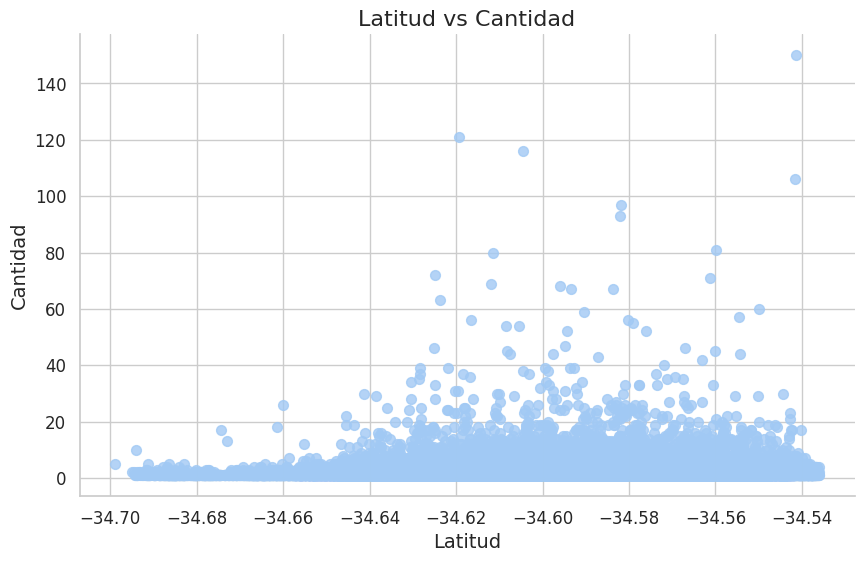

In [375]:
# Configuración de estilo y colores
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(post_latitud['latitud'], post_latitud['cantidad'], s=50, alpha=0.8)

# Ajustes del título y etiquetas
plt.title("Latitud vs Cantidad", fontsize=16)
plt.xlabel("Latitud", fontsize=14)
plt.ylabel("Cantidad", fontsize=14)

# Ocultar los ejes superior y derecho
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajustar tamaño de fuente de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [376]:
pre_latitud.equals(post_latitud)

False

In [377]:
print(len(pre_latitud))
print(len(post_latitud))
print('diferencia: {}'.format(len(pre_latitud)-len(post_latitud)))

45351
45182
diferencia: 169


#### Comparación longitud

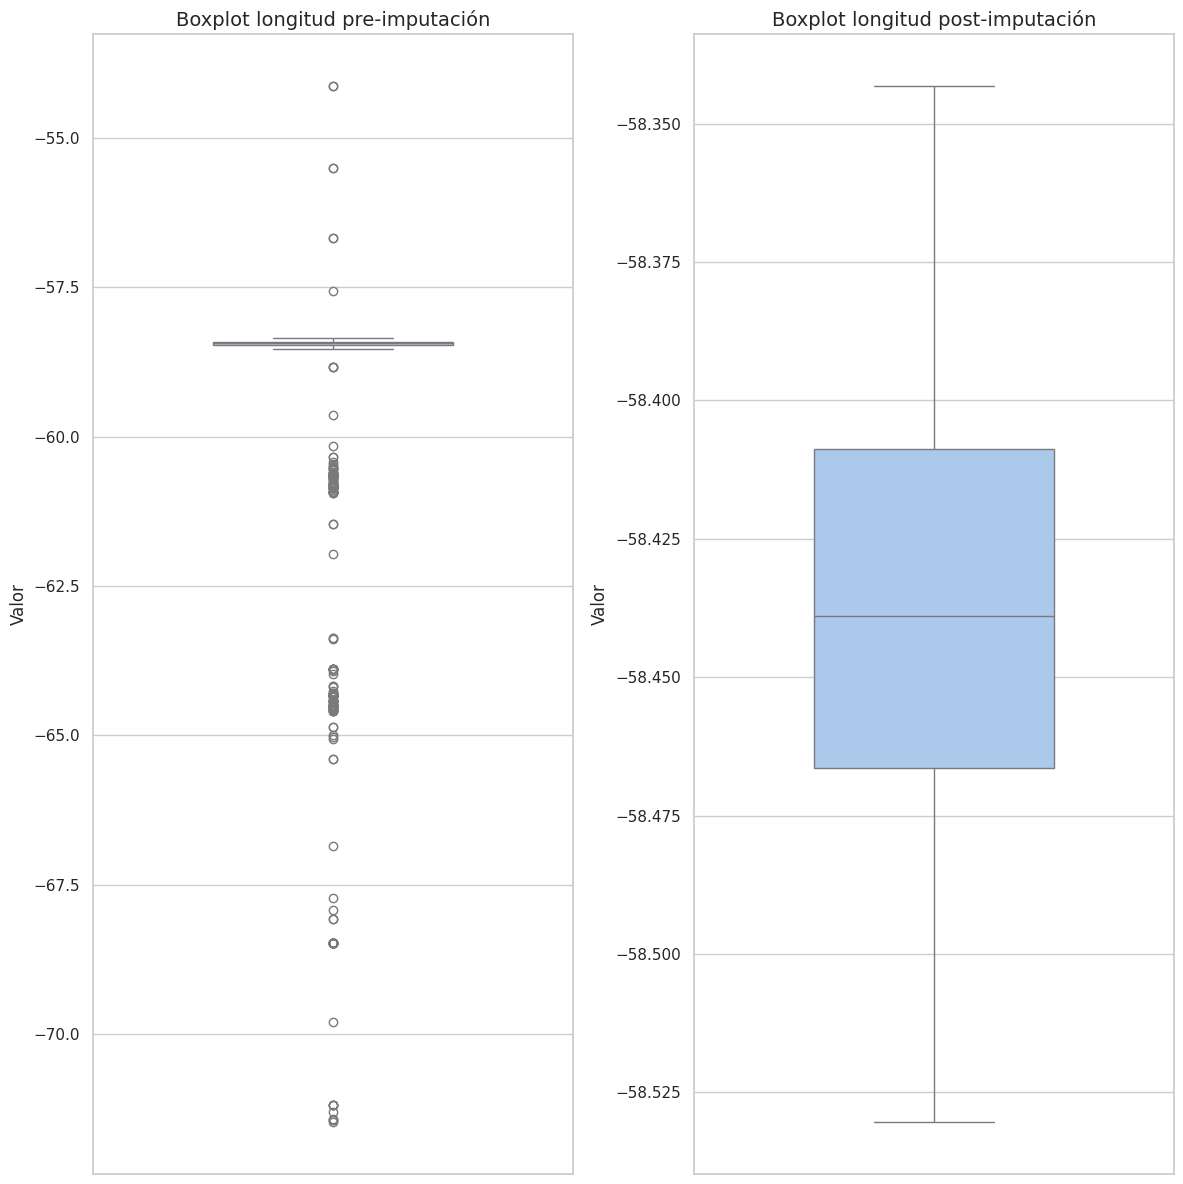

In [378]:
generar_distribucion("longitud")

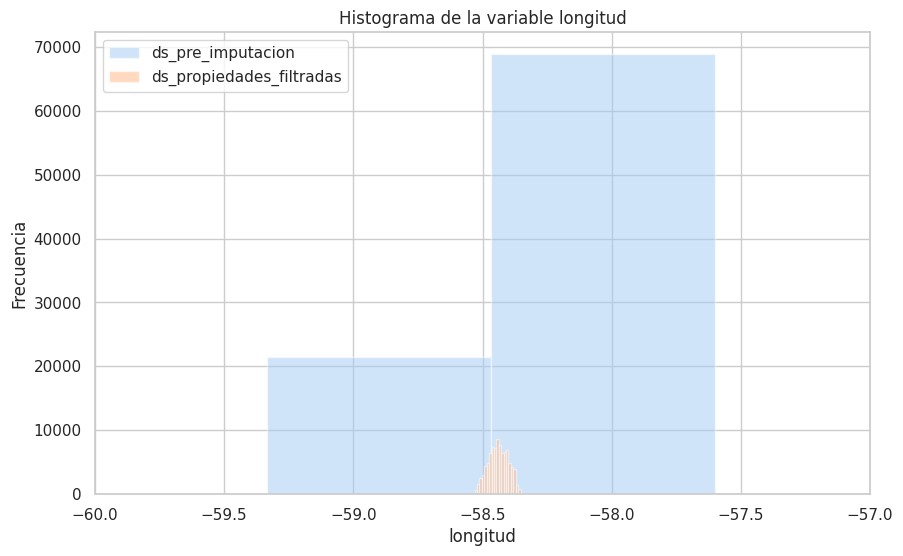

In [379]:
plt.figure(figsize=(10, 6))

plt.hist(ds_pre_imputacion['longitud'], bins=20, alpha=0.5, label='ds_pre_imputacion')

plt.hist(ds_propiedades_filtradas['longitud'], bins=20, alpha=0.5, label='ds_propiedades_filtradas')

plt.title("Histograma de la variable longitud")
plt.xlabel("longitud")
plt.ylabel("Frecuencia")

plt.xlim(-60, -57)

plt.legend()

plt.show()

Todos los valores que se mencionarán en el siguiente párrafo se consideran aproximados.

Antes de la imputación, se observa que la latitud tenía una frecuencia medianamente constante. Desde la latitud -59.3 hasta -58.5, la frecuencia es de aproximadamente 18000, luego aumenta en más de 50000 hasta llegar a la latitud -57.5.

Tras la imputación de los datos, se observa una variación en la frecuencia que genera una distribución en forma de campana de Gauss. La latitud aproximada con la máxima cantidad de datos nulos completos es alrededor de -58.400.

In [380]:
pre_longitud = obtener_cantidad_variables(ds_pre_imputacion,'longitud')
pre_longitud.head()

longitud  cantidad
0 -58.472966       150
1 -58.451999       121
2 -58.424956       116
3 -58.473377       106
4 -58.449381        97

In [381]:
post_longitud = obtener_cantidad_variables(ds_propiedades_filtradas,'longitud')
post_longitud.head()

longitud  cantidad
0 -58.472966       150
1 -58.451999       121
2 -58.424956       116
3 -58.473377       106
4 -58.449381        97

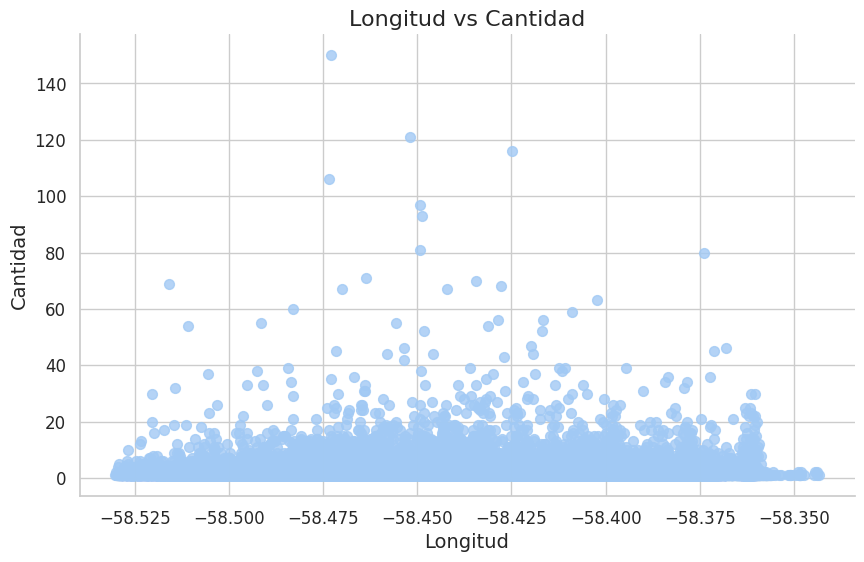

In [382]:
# Configuración de estilo y colores
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(post_longitud['longitud'], post_longitud['cantidad'], s=50, alpha=0.8)

# Ajustes del título y etiquetas
plt.title("Longitud vs Cantidad", fontsize=16)
plt.xlabel("Longitud", fontsize=14)
plt.ylabel("Cantidad", fontsize=14)

# Ocultar los ejes superior y derecho
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajustar tamaño de fuente de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [383]:
pre_longitud.equals(post_longitud)

False

In [384]:
print(len(pre_longitud))
print(len(post_longitud))
print('diferencia: {}'.format(len(pre_longitud)-len(post_longitud)))

45142
44973
diferencia: 169


#### Comparación place_l3

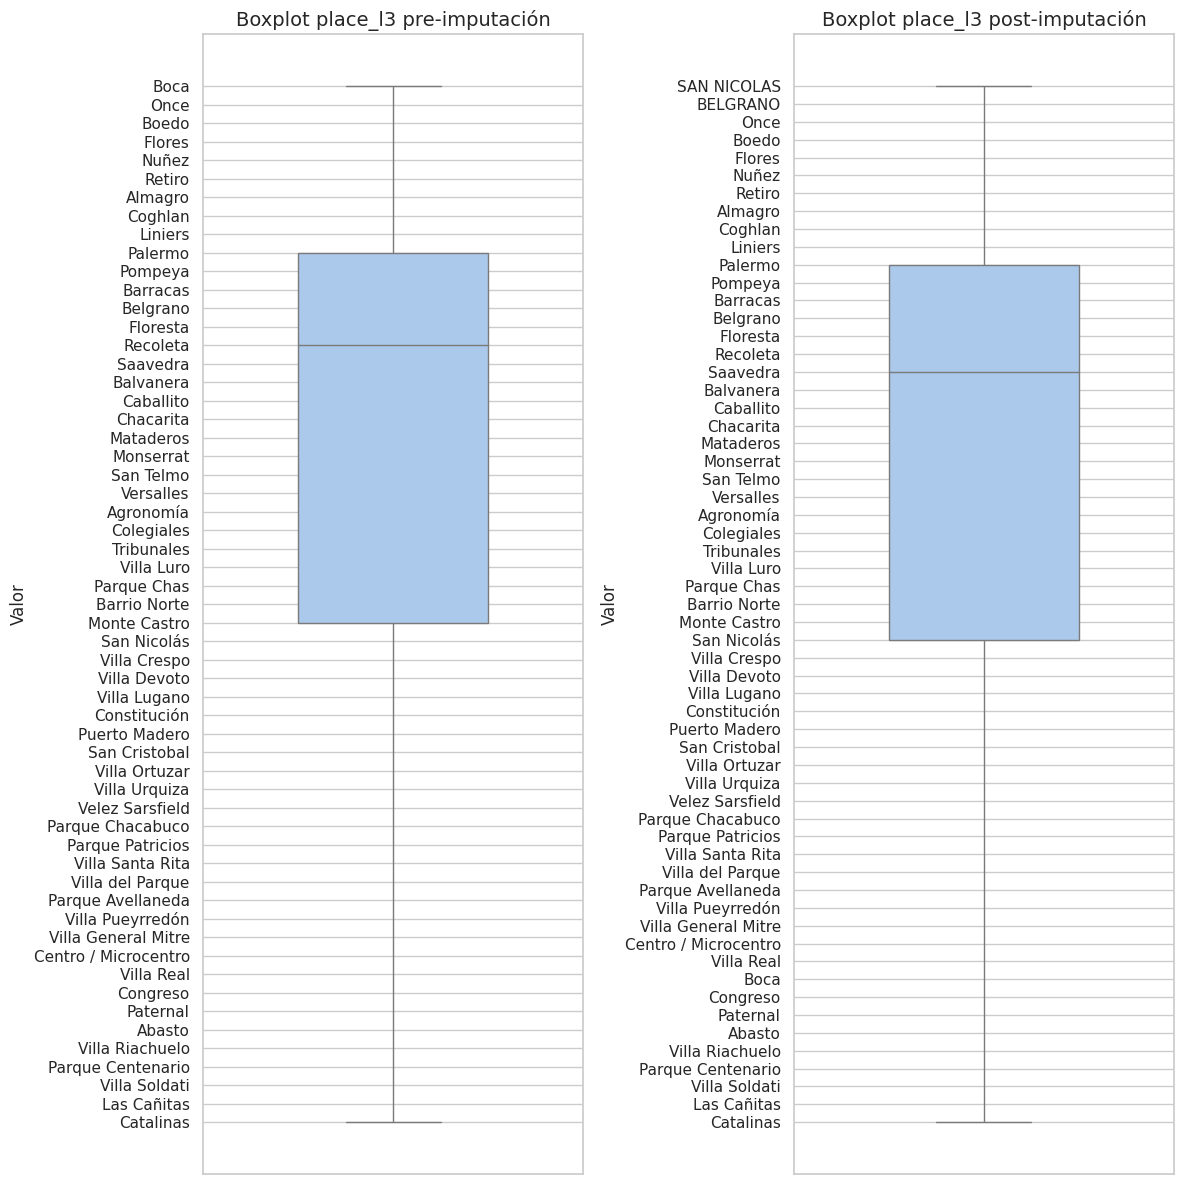

In [385]:
generar_distribucion("place_l3")

Como los datos nulos en la variable place_l3 era de 0.454913. No se observan grandes cambios en el gráfico.
Podemos notar que la media de Palermo se mantiene, lo mismo con Villa del Parque y Belgrano.

In [386]:
pre_barrio = obtener_cantidad_variables(ds_pre_imputacion,'place_l3')
pre_barrio.head()

place_l3  cantidad
0        Palermo     14308
1       Belgrano      8898
2      Caballito      7168
3       Recoleta      6282
4  Villa Urquiza      4673

In [387]:
post_barrio = obtener_cantidad_variables(ds_propiedades_filtradas,'place_l3')
post_barrio.head()

place_l3  cantidad
0        Palermo     13401
1       Belgrano      8247
2      Caballito      6998
3       Recoleta      6055
4  Villa Urquiza      4522

In [388]:
comparar_imputacion(pre_barrio,post_barrio,'place_l3')

907 registros se imputaron con el valor de Palermo place_l3
651 registros se imputaron con el valor de Belgrano place_l3
170 registros se imputaron con el valor de Caballito place_l3
227 registros se imputaron con el valor de Recoleta place_l3
151 registros se imputaron con el valor de Villa Urquiza place_l3
162 registros se imputaron con el valor de Almagro place_l3
229 registros se imputaron con el valor de Nuñez place_l3
111 registros se imputaron con el valor de Villa Crespo place_l3
115 registros se imputaron con el valor de Flores place_l3
185 registros se imputaron con el valor de Barrio Norte place_l3
80 registros se imputaron con el valor de Balvanera place_l3
10 registros se imputaron con el valor de Colegiales place_l3
7 registros se imputaron con el valor de Villa Devoto place_l3
9 registros se imputaron con el valor de Saavedra place_l3
9 registros se imputaron con el valor de Villa del Parque place_l3
69 registros se imputaron con el valor de Puerto Madero place_l3
87 reg

Podemos concluir que la mayoría de los valores faltantes en la variable "place_l3" fueron completados con el nombre del barrio "Palermo".

## Valores atípicos

### *Prefacio*

Recordando lo visto en la sección de variables cualitativas en Exploración inicial.

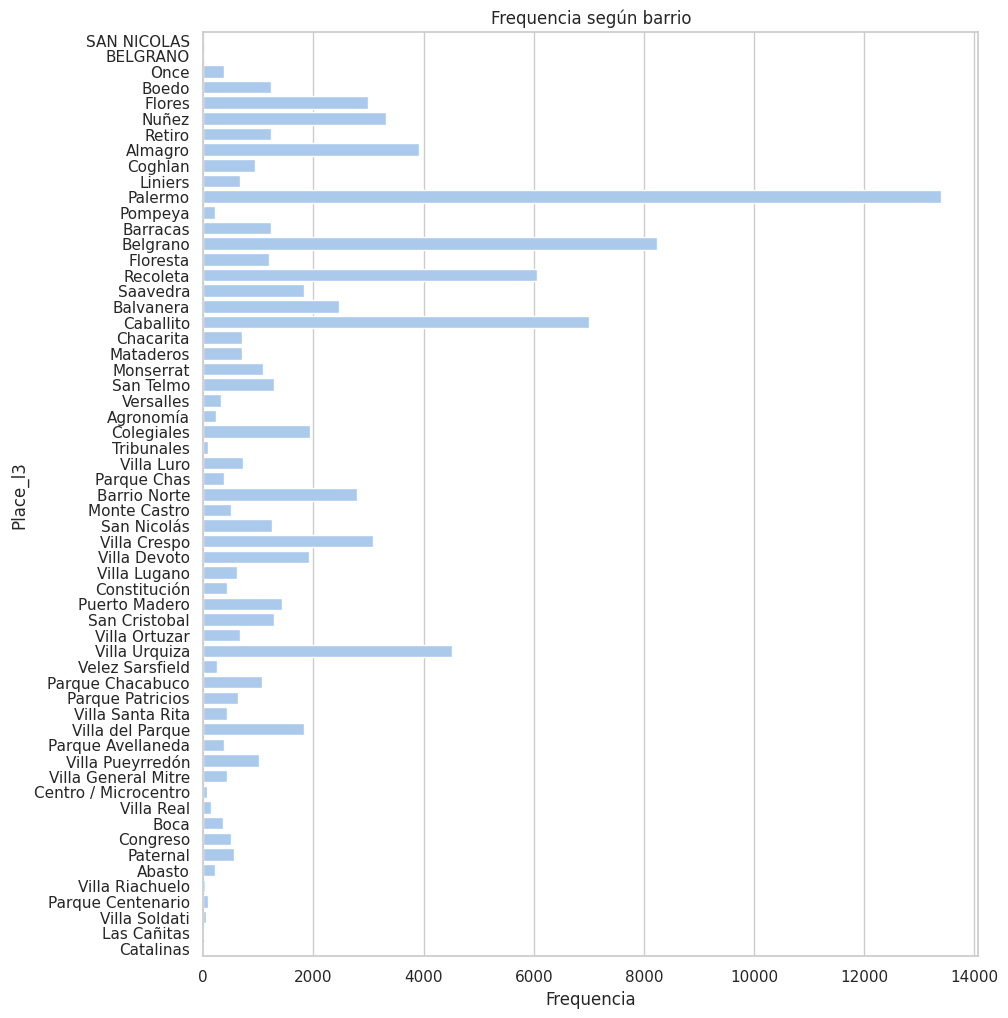

In [389]:
# Hacemos un gráfico de frecuencias de los barrios
plt.figure(figsize=(10, 12))
sns.countplot(y=ds_propiedades_filtradas.place_l3)
plt.xlabel('Frequencia')
plt.ylabel('Place_l3')
plt.title('Frequencia según barrio')
plt.show()

Vemos que Belgrano y San nicolas estan repetidos pero con mayuscula, arreglamos eso cambiando las mayusculas por minusculas.

In [390]:
# Cambiar mayus por minus
ds_propiedades_filtradas.loc[ds_propiedades_filtradas['place_l3'] == 'BELGRANO', 'place_l3'] = 'Belgrano'
ds_propiedades_filtradas.loc[ds_propiedades_filtradas['place_l3'] == 'SAN NICOLAS', 'place_l3'] = 'San Nicolás'

Las Cañitas, Catalinas, San Nicolas tienen una representación nula/casi nula.
Villa Soldati, Microcentro, Parque Centenario, Villa Riachuelo, Tribunales tienen una representación tan pequeña que tenemos que tener en cuenta que los registros pueden ser casos aislados/no representativos de la realidad de las ventas de inmuebles en el barrio.

In [391]:
# Hacemos una copia del dataset hasta el momento
ds_atipicos = ds_propiedades_filtradas.copy()

Funciones auxiliares para el análisis:



In [392]:
#Función para cálculo de limite superior e inferior de outliers según cuartiles
def limite_rango_iq(df, variable):
  # Cuartiles
  Q1 = np.quantile(df[variable], 0.25)
  Q3 = np.quantile(df[variable], 0.75)

  # Rango intercuartil
  IQR = Q3 - Q1

  # Limite inferior Outliers
  out_inf = Q1 - 1.5 * IQR

  # Limite superior Outliers
  out_sup = Q1 + 1.5 * IQR

  return out_inf, out_sup

# Funcion para cálculo de Z Score normal
def calculo_z_score(serie):
  media = np.mean(serie)
  std = np.std(serie)
  return (serie - media) / std

#Función para calculo de Z Score modificado
def calculo_z_mod(serie):
  median = np.median(serie)
  MAD = np.median(np.absolute(serie - median))
  return (serie - median) * 0.6745 / MAD

# Grafico comparativo
def plot_comparativo(df_antes, df_despues, var):

  # Create subplots
  fig, axs = plt.subplots(1, 2, figsize=(12, 6))

  # Plot for df_antes
  sns.boxplot(y=df_antes[var], ax=axs[0])
  axs[0].set_title('Antes')

  # Plot for df_despues
  sns.boxplot(y=df_despues[var], ax=axs[1])
  axs[1].set_title('Después')

  # Show plots
  plt.tight_layout()
  plt.show()
  return

# Boxplot por barrio de la variable a evaluar
def plot_por_barrio(df, var):
  # Lista de barrios
  barrios = ['Coghlan','Colegiales','Abasto','Nuñez','Constitución',
             'Boedo', 'San Nicolás', 'Retiro', 'Liniers', 'Almagro',
             'Boca', 'Palermo', 'Balvanera','Barracas', 'Caballito',
             'Villa Ortuzar', 'Villa Luro', 'Puerto Madero', 'Pompeya', 'Saavedra',
             'Parque Chacabuco', 'Belgrano', 'Recoleta', 'Floresta', 'Monserrat',
             'Villa del Parque', 'San Telmo', 'Villa Crespo', 'Tribunales', 'Once',
             'Barrio Norte', 'Villa Lugano', 'Congreso', 'Villa Urquiza', 'Mataderos',
             'Villa Devoto', 'Recoleta', 'San Cristobal', 'Villa Pueyrredon', 'Congreso']

  # Subplots
  fig, axs = plt.subplots(8, 5, figsize=(16, 24))
  axs = axs.flatten()

  for i, barrio in enumerate(barrios):
      filtered_data = df[df['place_l3'] == barrio]

      sns.boxplot(y=filtered_data[var], ax=axs[i])

      axs[i].set_title(f'{var} en {barrio}')

  # Adjust layout
  plt.tight_layout()
  # Show the plot
  plt.show()
  return



### Análisis univariado

Vamos a intentar identificar los outliers univariados utilizando los IQR y el Z Score.

#### *Análisis según cantidad de habitaciones(property_bedrooms)*

<Axes: ylabel='property_bedrooms'>

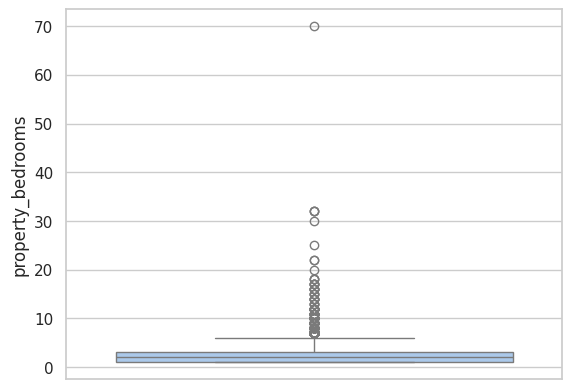

In [393]:
sns.boxplot(y=ds_propiedades_filtradas.property_bedrooms)

In [394]:
limite_rango_iq(ds_propiedades_filtradas, 'property_bedrooms')

(-2.0, 4.0)

Primero analizamos el outlier más notorio y verificamos si es un valor posible.

In [395]:
# Observación anómala
outlier = ds_propiedades_filtradas[ds_propiedades_filtradas['property_bedrooms'] > 40]
outlier

id start_date    end_date    latitud   longitud  \
94998  4TbEkLoqy/0c3zakd66/FQ== 2021-09-24  2022-01-27 -34.646632 -58.497902   

         place_l3 property_type  property_rooms  property_bedrooms  \
94998  Villa Luro  Departamento             3.0               70.0   

       property_surface_total  property_surface_covered  property_price  
94998                  1083.0                      70.0        135000.0

Es un departamento de 3 ambientes con 70 habitaciones, lo cual no es posible. Tampoco podemos asumir que es un error de tipeo. A su vez, la superficie total es exagerada en comparación de la superficie cubierta y el precio de la propiedad.  Vamos a eliminar el outlier y visualizar nuevamente el código.  

<Axes: ylabel='property_bedrooms'>

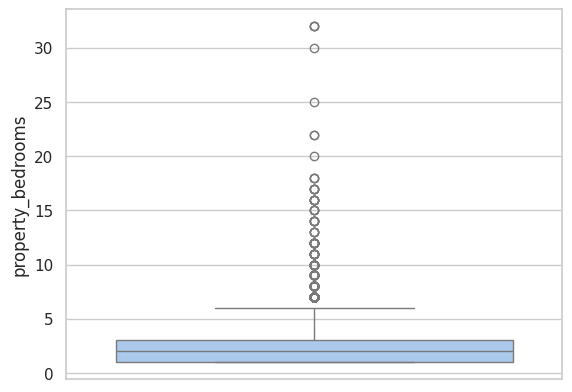

In [396]:
# Eliminamos outlier por indice
id_outlier = ds_propiedades_filtradas[ds_propiedades_filtradas['property_bedrooms'] > 40].index
ds_propiedades_filtradas.drop(id_outlier,inplace=True)

# Visualizamos
sns.boxplot(y=ds_propiedades_filtradas.property_bedrooms)

Existen muchos valores atípicos por sobre el umbral marcado por los cuartiles, pero teniendo en cuenta que estamos trabajando con casas, PH y departamentos unicamente, revisaremos las anomalías mayores a 15, a partir de donde no hay muchas ocurrencias.



In [397]:
# Observación anómala
outlier = ds_propiedades_filtradas[ds_propiedades_filtradas['property_bedrooms'] > 15]
outlier

id start_date    end_date    latitud   longitud  \
1932    eQ/SiyES/mXWsSyAzb3k3A== 2021-12-17  9999-12-31 -34.637026 -58.426283   
32758   KA441xdi8PtuWBvjcAbGOQ== 2021-02-08  2021-03-01 -34.632698 -58.360514   
36421   VoyodCc8rftOZHr4TeYcpw== 2021-09-21  2022-02-03 -34.576061 -58.421289   
48279   r3sXlEIiCgBG5TtUkN93mw== 2021-03-14  2021-06-05 -34.608645 -58.485619   
49960   O/JMW/VVo7OmWF7SkXtBuA== 2021-10-16  2021-12-24 -34.630186 -58.389156   
86014   pVG9sES9De/1eQ+tB90NjQ== 2021-03-26  2021-06-05 -34.591110 -58.400685   
90004   TEs1aRnhJPwR0jRMq/Vzdg== 2021-08-03  9999-12-31 -34.633236 -58.480313   
115403  VuF9cBcZ03aoEcEWAsWGjA== 2021-12-07  2022-01-27 -34.598070 -58.444686   
140832  2aHER3AXQs3zb3EegLhmgg== 2021-12-08  2022-01-27 -34.588454 -58.385257   
150885  X3WGOe/PrGS1u+xozM5elA== 2021-03-24  2021-06-05 -34.642037 -58.438995   
208593  CtbHDgBLf3+kTc20y2iVhw== 2021-11-29  2022-01-14 -34.629796 -58.363928   
285222  WHu8kgA8Vu692UM8Dz3gnA== 2021-02-24  2022-02-09 -34.638432 -58.369712   
292167  CxZv3EmTnK+m6EJD2uQ5fw== 2021-02-23  2021-03-03 -34.616487 -58.371596   
307211  uqM9/WXFJkEJnXEQefcpRQ== 2021-09-19  2021-09-19 -34.611905 -58.382384   
332857  760pAR/aW7whZAZRLML/ZA== 2021-09-17  2022-02-25 -34.611905 -58.382384   
346602  yzI9zylc11wllHX16av6jA== 2021-09-30  2021-11-02 -34.632537 -58.360577   
354668  +SPkA/Y4DHEHf+HIppYFKg== 2021-03-31  2021-04-16 -34.611905 -58.382384   
362676  Gj3g5KCtRbYcwZIuh/wJGg== 2021-01-16  2021-08-06 -34.618485 -58.377993   
362696  KuzGWi8jCNPL9nvKAUqLKw== 2021-01-16  2021-08-06 -34.618485 -58.377993   
366101  8o3ZwoXgOddHoex/irib7g== 2021-04-10  2021-06-05 -34.648922 -58.380522   
389282  +xTrflFUv4fEGjwpwhP68w== 2021-05-05  2021-06-05 -34.570959 -58.458106   
402448  9OrT+9jZlW4rMGyZYsmNPA== 2021-09-07  2022-02-09 -34.611413 -58.389221   

                place_l3 property_type  property_rooms  property_bedrooms  \
1932    Parque Chacabuco          Casa            23.0               18.0   
32758               Boca            PH            19.0               18.0   
36421            Palermo  Departamento             3.0               20.0   
48279   Villa del Parque  Departamento             4.0               32.0   
49960   Parque Patricios  Departamento             1.0               32.0   
86014           Recoleta  Departamento             4.0               30.0   
90004           Floresta            PH            32.0               32.0   
115403      Villa Crespo            PH            17.0               17.0   
140832          Recoleta  Departamento             5.0               22.0   
150885  Parque Chacabuco  Departamento            35.0               25.0   
208593              Boca            PH            18.0               17.0   
285222          Barracas            PH            20.0               17.0   
292167         San Telmo            PH            24.0               22.0   
307211         Monserrat            PH            15.0               16.0   
332857         Monserrat  Departamento            18.0               17.0   
346602              Boca  Departamento            19.0               18.0   
354668         Monserrat            PH            15.0               16.0   
362676         San Telmo          Casa            16.0               16.0   
362696         San Telmo  Departamento            16.0               16.0   
366101          Barracas          Casa            18.0               17.0   
389282          Belgrano          Casa            28.0               16.0   
402448         Monserrat          Casa            17.0               16.0   

        property_surface_total  property_surface_covered  property_price  
1932                  186956.0                  217000.0        250000.0  
32758                    372.0                     318.0        159000.0  
36421                    127.0                     117.0        650000.0  
48279                     83.0                      75.0        189000.0  
49960              

Tenemos 230 anomalías. Los casos donde el número de ambientes es razonable, parece error de tipeo. Lo corregimos

In [398]:
condition = (ds_propiedades_filtradas['property_bedrooms'] > 15) & (ds_propiedades_filtradas['property_rooms'] < 10)
ds_propiedades_filtradas.loc[condition, 'property_surface_covered'] /= 10

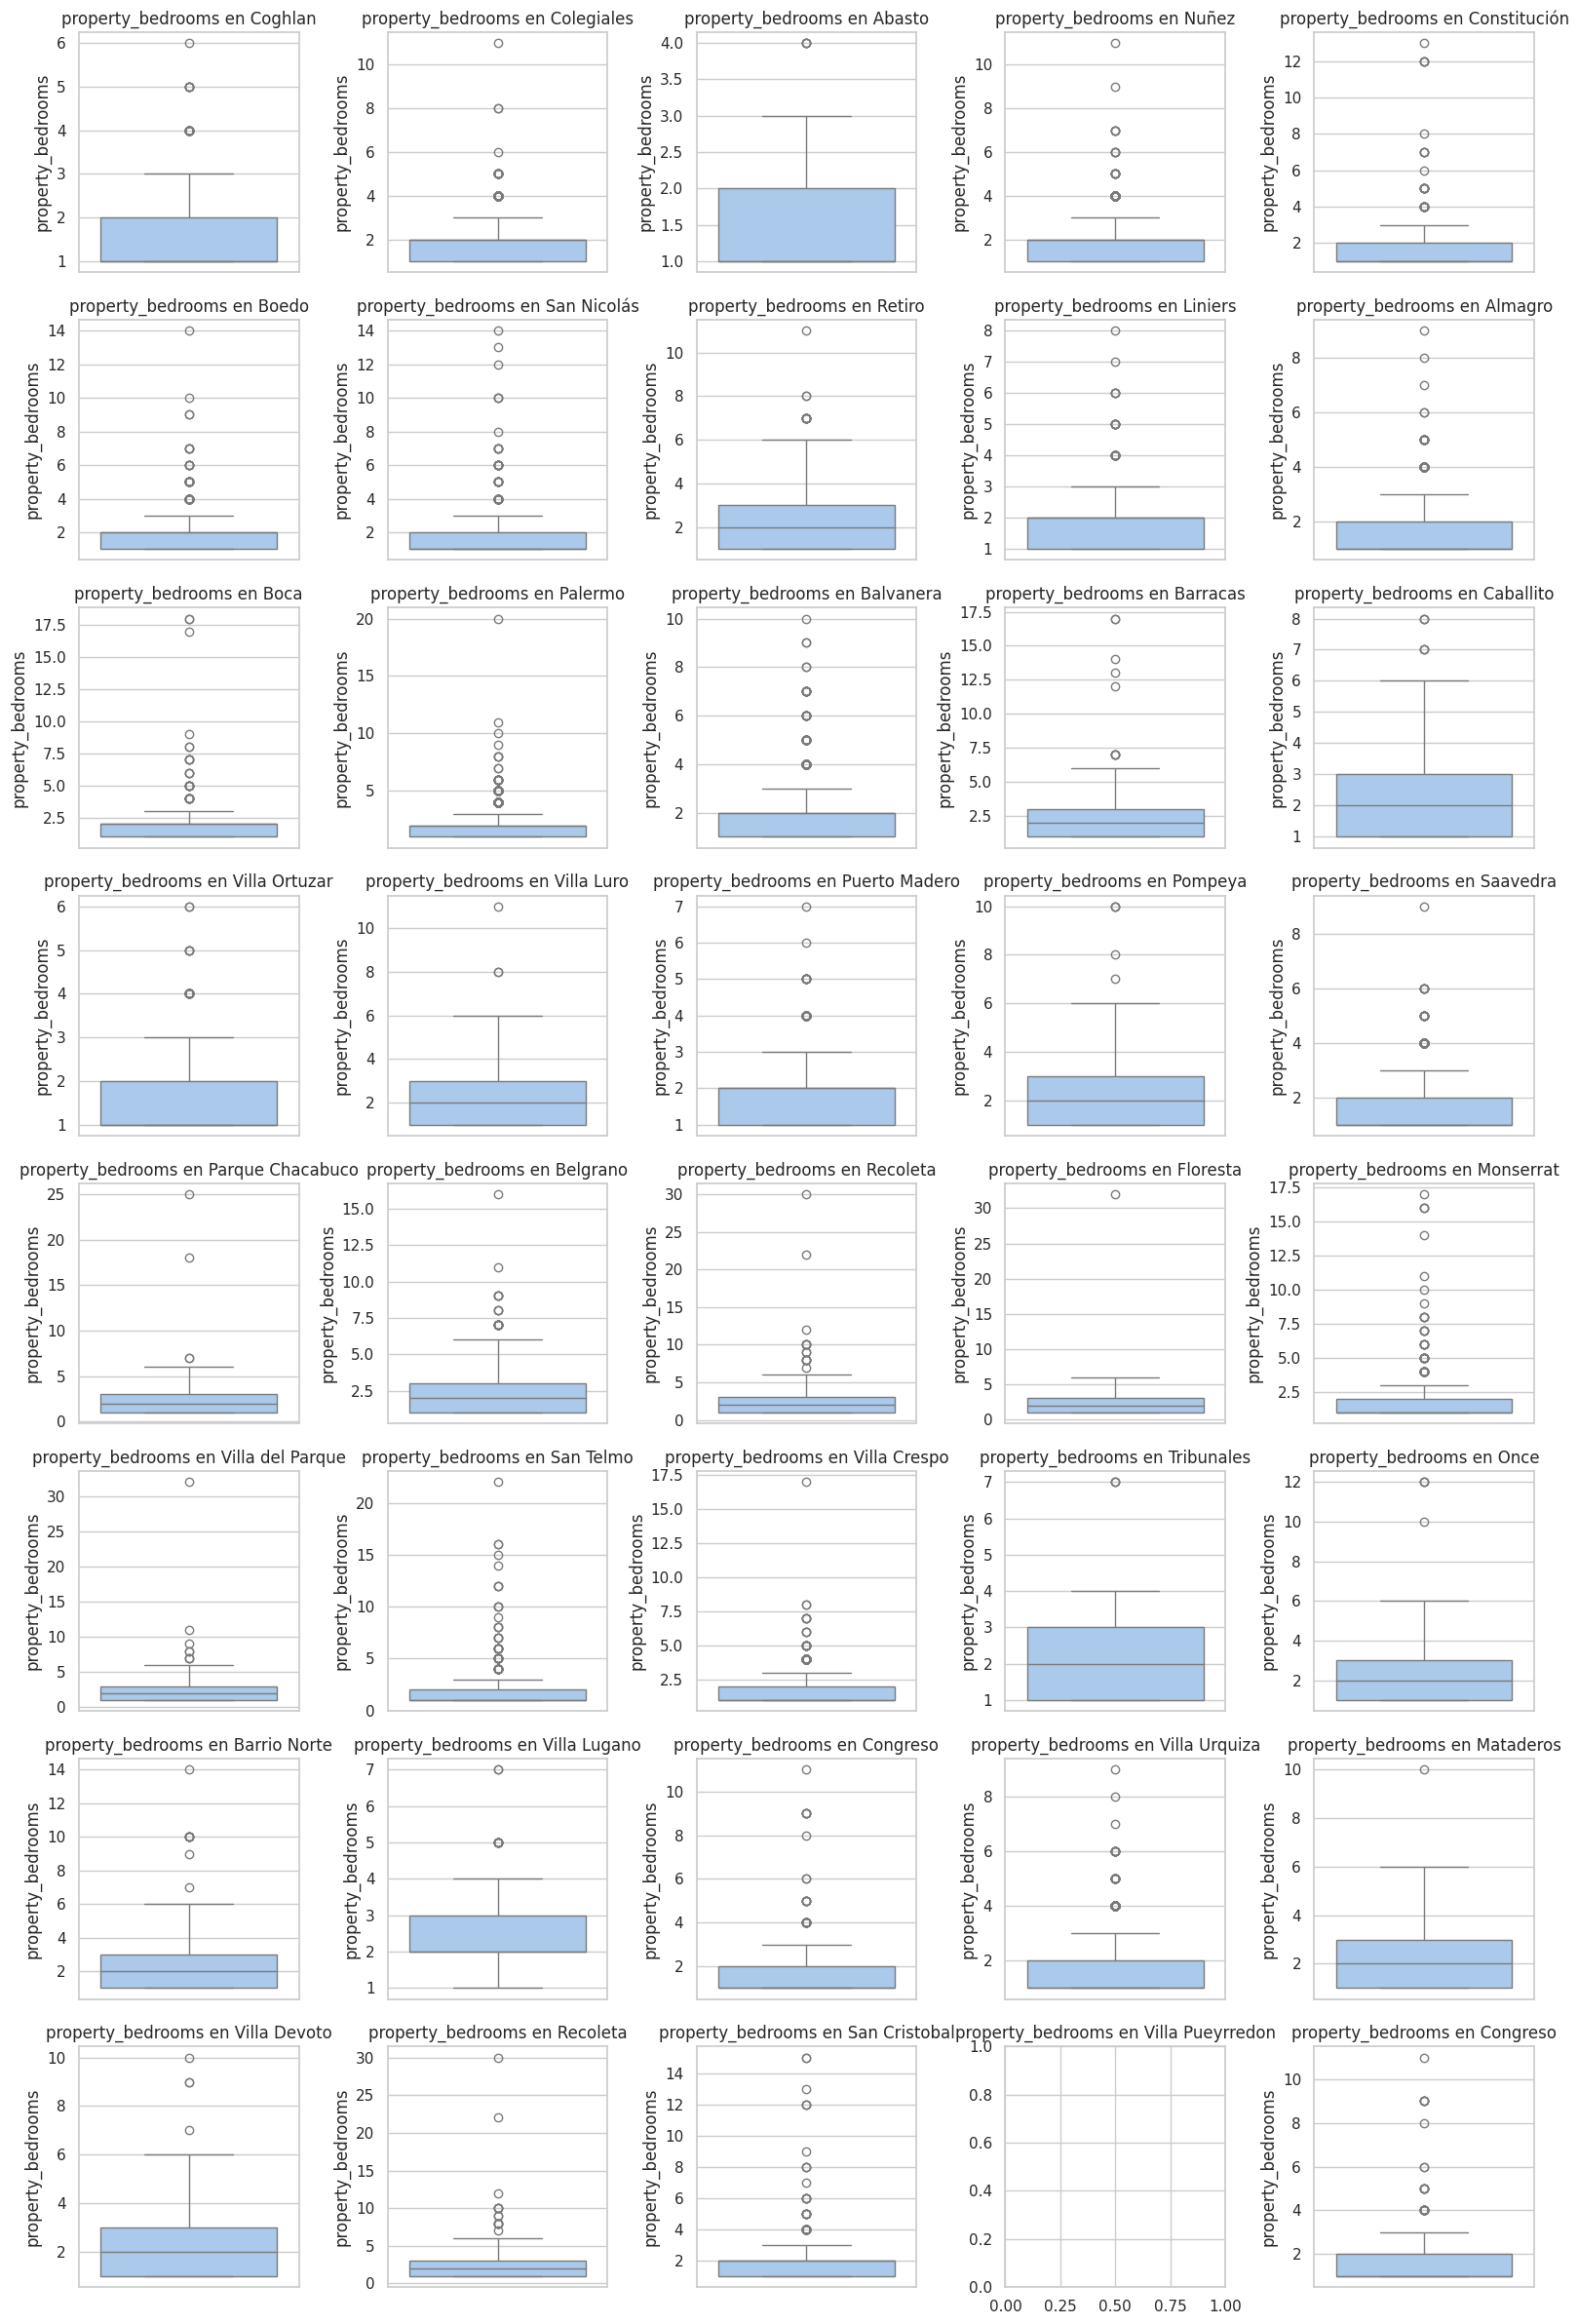

In [399]:
plot_por_barrio(ds_propiedades_filtradas, 'property_bedrooms')

Analizando los boxplot de la cantidad de habitaciones pero dividido según el barrio en el que se encuentra la propiedad, podemos ver aún teniendo en cuenta las variaciones, que aquellos casos de casas con más de 8 habitaciones son outliers extremos y decidimos normalizarlas utilizando una transformación logaritmica.

Nota: el limite intercuartil en general para la zona de CABA era 4, pero como vemos en barrios como Caballito esto se encuentra totalmente dentro de la norma.

In [400]:
ds_propiedades_filtradas.loc[ds_propiedades_filtradas['property_bedrooms'] > 7.0, 'property_bedrooms'] = np.log(ds_propiedades_filtradas['property_bedrooms'])

In [401]:
ds_propiedades_filtradas[ds_propiedades_filtradas['property_bedrooms'] > 6]

id start_date    end_date    latitud   longitud  \
1800    xOxObQG9UHaTxLPYGOtK4w== 2021-12-17  2022-02-09 -34.616128 -58.394715   
6869    vtFpL0vRYrdtMyLuHCrhkQ== 2021-02-09  9999-12-31 -34.631952 -58.373878   
6871    FQeAbzRt++H2i0sij+/h7g== 2021-02-09  2021-02-11 -34.633226 -58.376409   
6873    +Omoo5u2h83gqiMY2Xi68A== 2021-02-09  2021-02-11 -34.633226 -58.376409   
14283   zX5pLInR+6XVkqbVZjdxzA== 2021-07-31  9999-12-31 -34.553144 -58.448612   
...                          ...        ...         ...        ...        ...   
448242  DtvwUdyN8mhShkCjkovMfg== 2021-12-16  2022-02-09 -34.635382 -58.355539   
449071  o2xzCwXzVpbeYQv+JDXvZg== 2021-12-16  2022-02-09 -34.621588 -58.455720   
449622  YxjhWpsXv+4ySaNcSmtSxw== 2021-12-16  2022-02-09 -34.546268 -58.459154   
457063  D2v8pvBdj56lpVuQPiSbQA== 2021-05-08  2021-05-20 -34.572554 -58.469842   
457064  rWpwKlxzNHvQYcrs+sBijQ== 2021-05-08  2021-05-20 -34.572554 -58.469842   

         place_l3 property_type  property_rooms  property_bedrooms  \
1800    Balvanera          Casa             8.0                7.0   
6869     Barracas          Casa             9.0                7.0   
6871     Barracas          Casa             9.0                7.0   
6873     Barracas          Casa             9.0                7.0   
14283    Belgrano          Casa             9.0                7.0   
...           ...           ...             ...                ...   
448242       Boca            PH             8.0                7.0   
449071     Flores            PH             8.0                7.0   
449622      Nuñez            PH             8.0                7.0   
457063   Belgrano          Casa             8.0                7.0   
457064   Belgrano          Casa             8.0                7.0   

        property_surface_total  property_surface_covered  property_price  
1800                     164.0                     143.0        215000.0  
6869                     433.0                     350.0        550000.0  
6871                     360.0                     265.0        350000.0  
6873                     360.0                     265.0        350000.0  
14283                    750.0                     485.0       2250000.0  
...                        ...                       ...             ...  
448242                   395.0                     319.0        135000.0  
449071                   433.0                     230.0        590000.0  
449622                   246.0                     172.0        370000.0  
457063                   400.0                     400.0        920000.0  
457064                   400.0                     400.0        920000.0  

[113 rows x 12 columns]

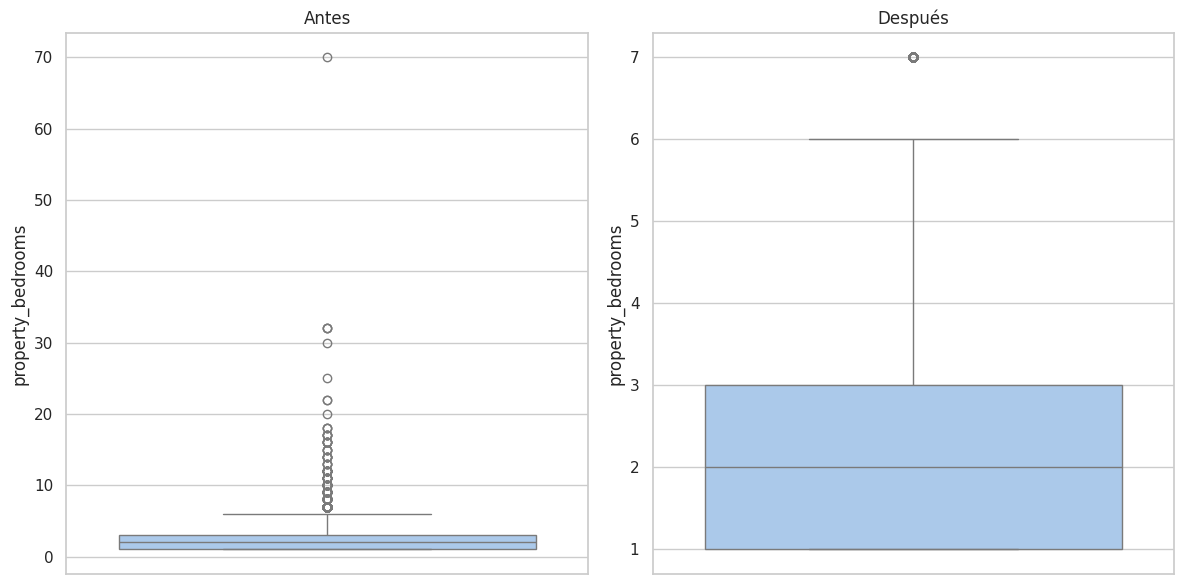

In [402]:
plot_comparativo(ds_atipicos, ds_propiedades_filtradas, 'property_bedrooms')

Podemos ver que se han solucionado la mayoría de las anomalías. Dejaremos las restantes (85 registros) para el análisis multivariado.

#### *Análisis según cantidad de ambientes (property_rooms)*

<Axes: ylabel='property_rooms'>

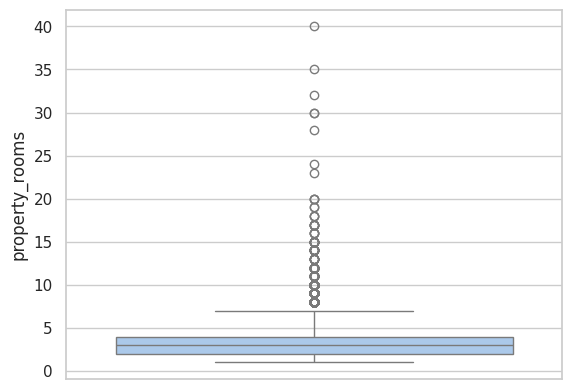

In [403]:
sns.boxplot(y=ds_propiedades_filtradas.property_rooms)

In [404]:
limite_rango_iq(ds_propiedades_filtradas, 'property_rooms')

(-1.0, 5.0)

El limite intercuartil superior es 5.0. Vemos que si bien hay muchos outliers por sobre el limite de 5 ambientes, esto se acentúa una vez que se superan los 20 ambientes.



In [405]:
# Observación anómala
outlier = ds_propiedades_filtradas[ds_propiedades_filtradas['property_rooms'] > 20]
outlier

id start_date    end_date    latitud   longitud  \
1932    eQ/SiyES/mXWsSyAzb3k3A== 2021-12-17  9999-12-31 -34.637026 -58.426283   
21009   bmop3OsDu5kJmbAVgJ5wzA== 2021-03-15  2021-06-05 -34.616391 -58.456038   
52157   HwHiC1DJIxRAjUAOmujXsg== 2021-02-07  2021-06-15 -34.649872 -58.483012   
90004   TEs1aRnhJPwR0jRMq/Vzdg== 2021-08-03  9999-12-31 -34.633236 -58.480313   
150885  X3WGOe/PrGS1u+xozM5elA== 2021-03-24  2021-06-05 -34.642037 -58.438995   
292167  CxZv3EmTnK+m6EJD2uQ5fw== 2021-02-23  2021-03-03 -34.616487 -58.371596   
356618  +e6yeZZqYElYRYq4/cd9qg== 2021-11-18  2021-12-02 -34.588742 -58.422459   
389282  +xTrflFUv4fEGjwpwhP68w== 2021-05-05  2021-06-05 -34.570959 -58.458106   

                 place_l3 property_type  property_rooms  property_bedrooms  \
1932     Parque Chacabuco          Casa            23.0           2.890372   
21009           Caballito  Departamento            30.0           2.000000   
52157   Parque Avellaneda            PH            30.0           2.000000   
90004            Floresta            PH            32.0           3.465736   
150885   Parque Chacabuco  Departamento            35.0           3.218876   
292167          San Telmo            PH            24.0           3.091042   
356618            Palermo  Departamento            40.0           3.000000   
389282           Belgrano          Casa            28.0           2.772589   

        property_surface_total  property_surface_covered  property_price  
1932                  186956.0                  217000.0        250000.0  
21009                     79.0                      79.0        230000.0  
52157                     72.0                      60.0        123500.0  
90004                    535.0                     435.0        300000.0  
150885                    37.0                      33.0         67000.0  
292167                   800.0                     650.0        350000.0  
356618                    75.0                      68.0        145000.0  
389282                   845.0                     845.0        950000.0

Si bien los datos de habitaciones y ambientes no son posibles, por ahora no serán borrados ya que el resto (superficie cubierta, precio) parecen coherentes con el resto del dataset y pueden ser útiles.

Controlaremos según barrio.

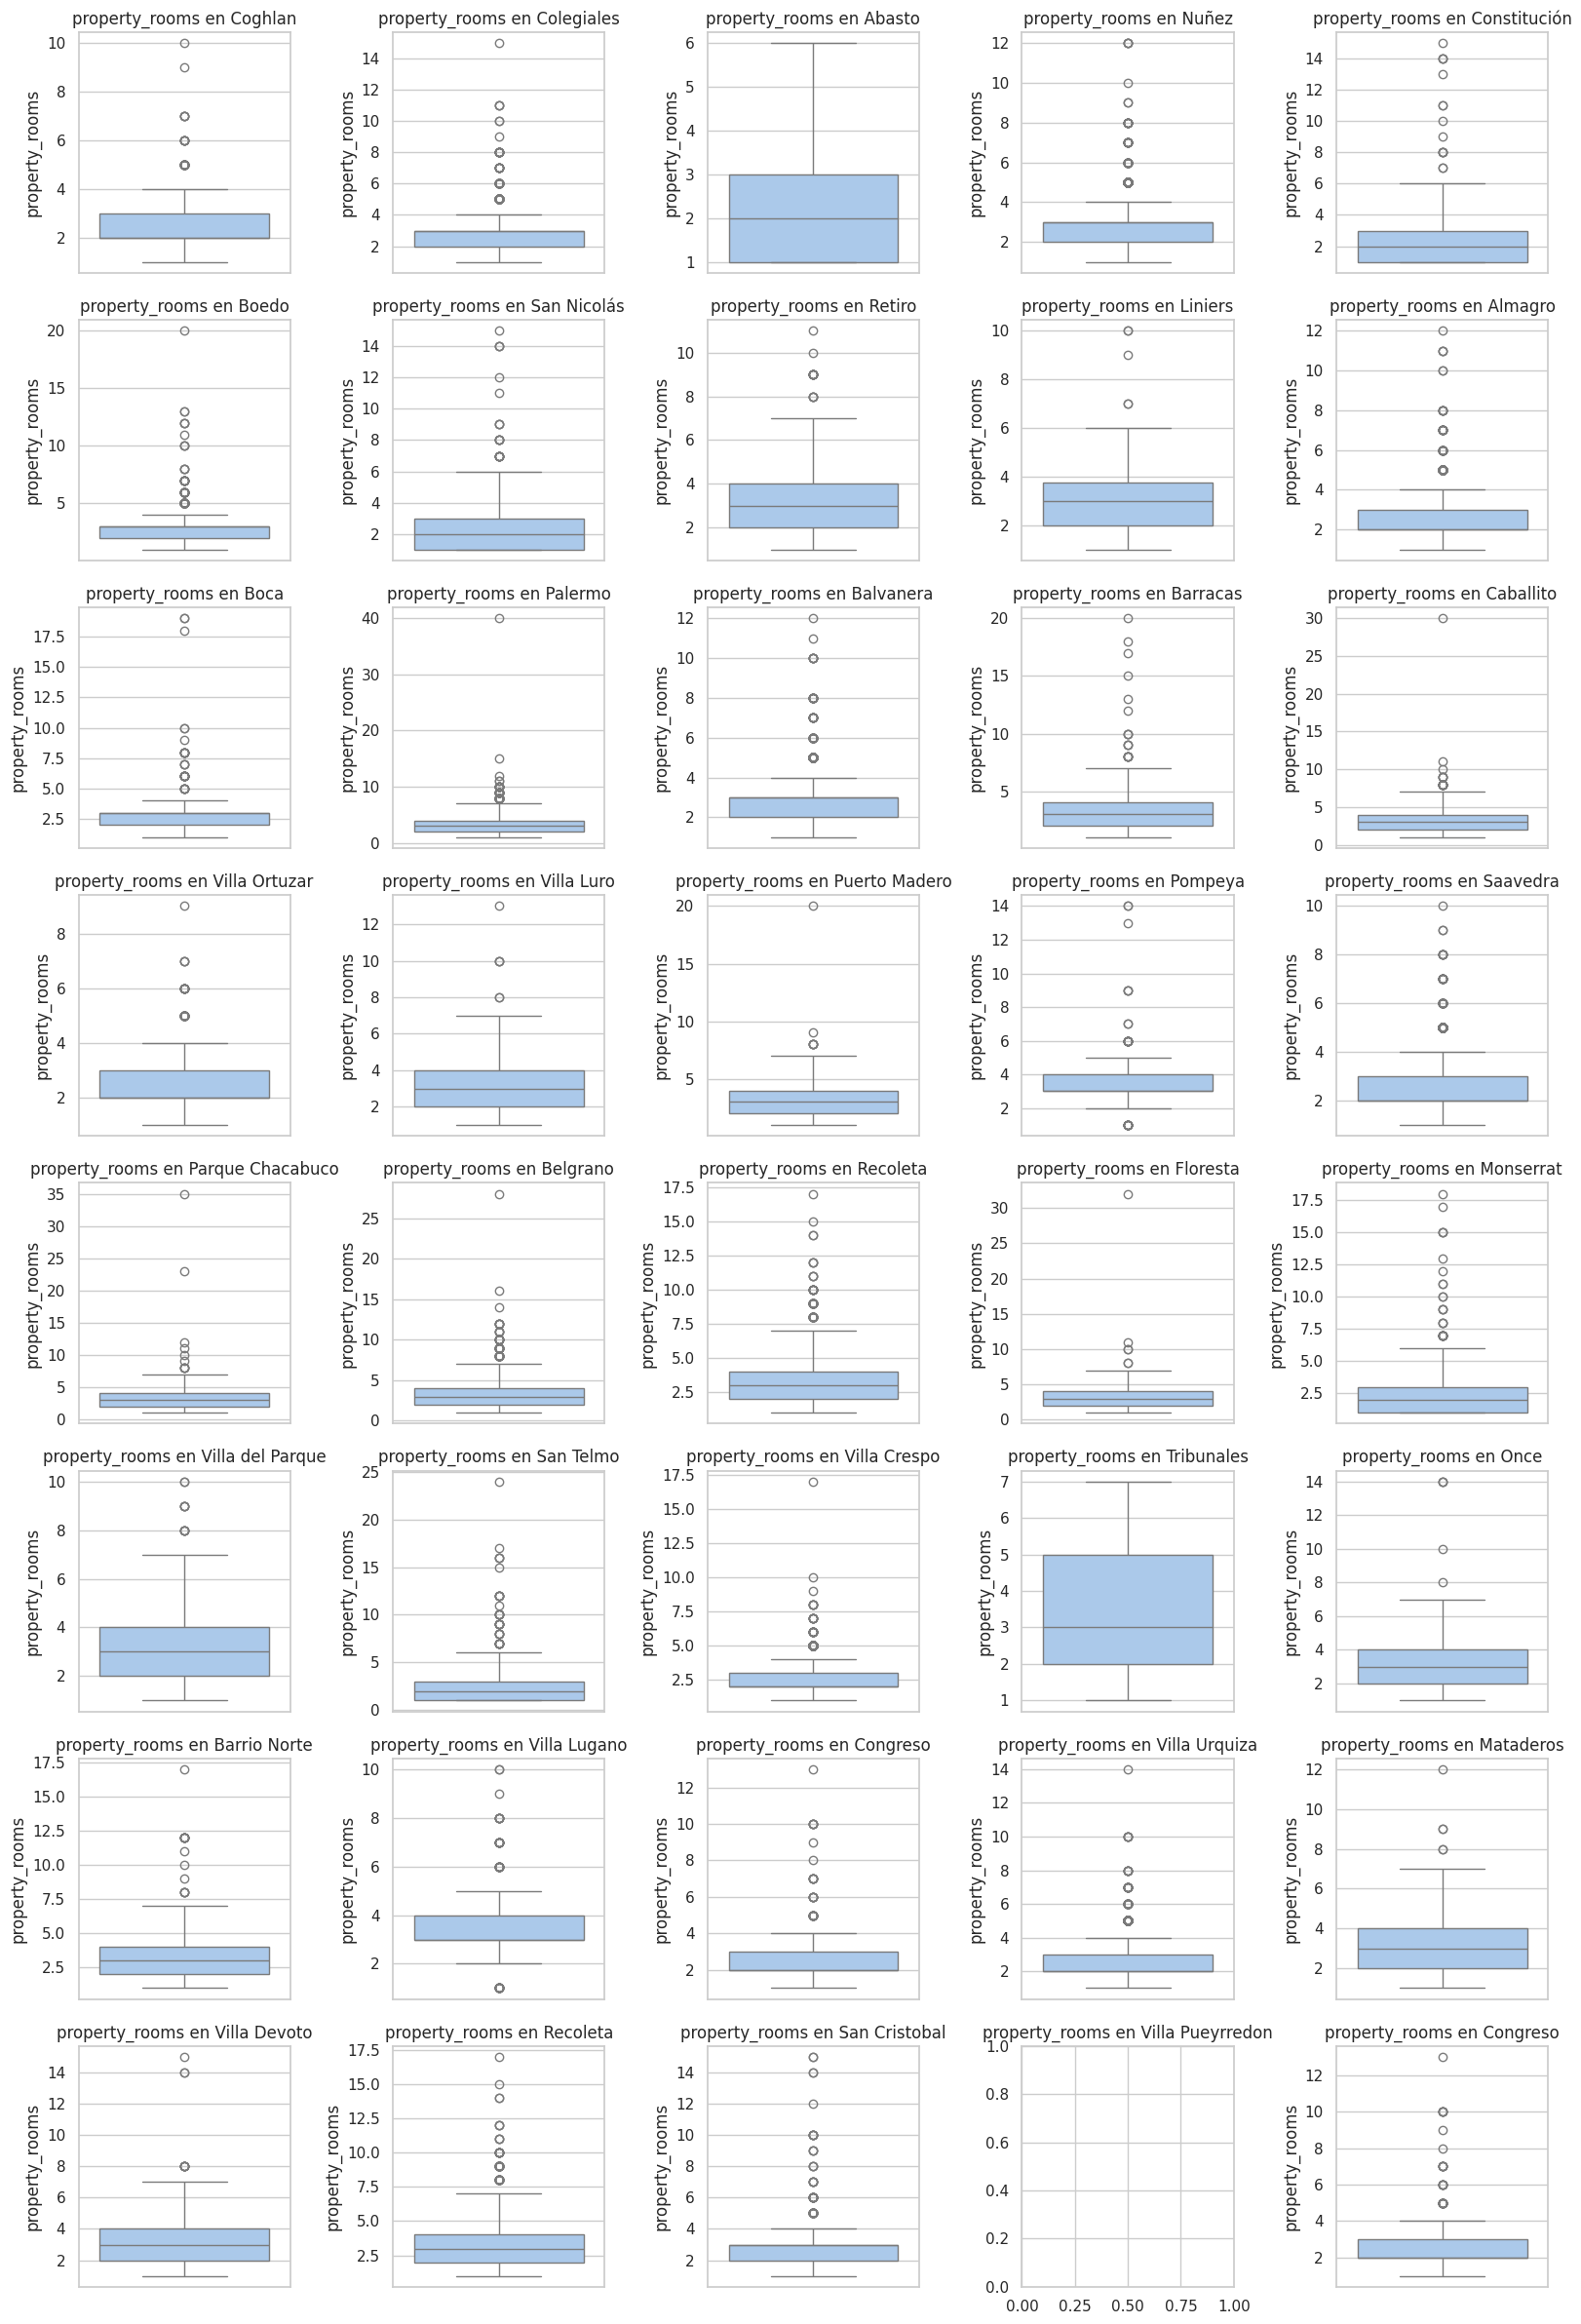

In [406]:
plot_por_barrio(ds_propiedades_filtradas, 'property_rooms')

Si bien nuestro límite intercuartil era de 5.0 vemos una tendencia un poco superior al ver los boxplot por barrio, así que realizaremos una corrección en aquellos registros atípicos que superen los 10 ambientes.

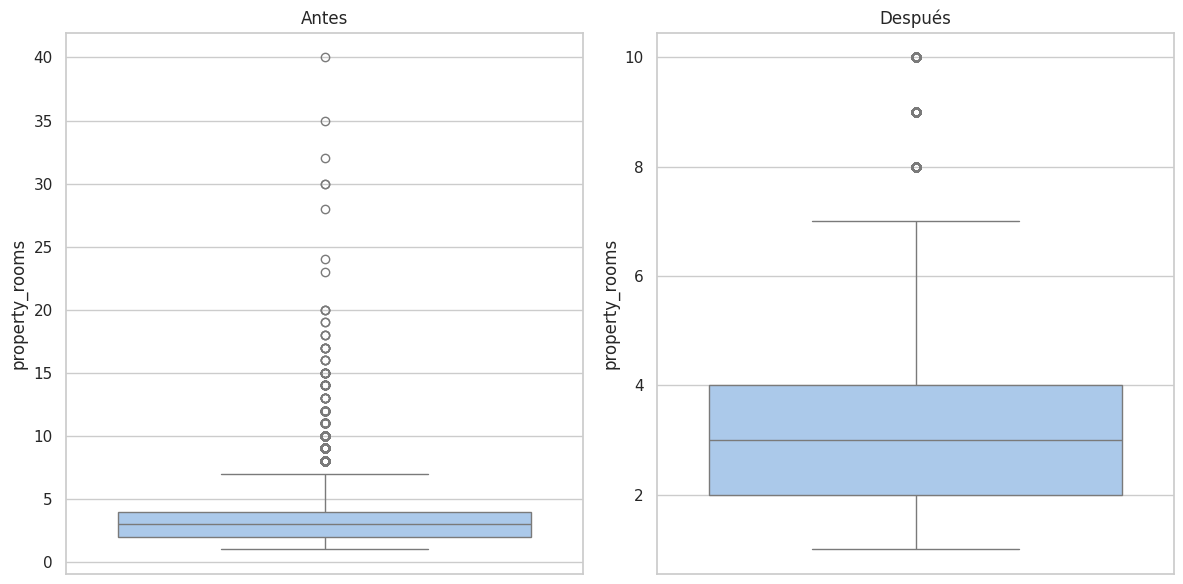

In [407]:
#Normalizacion logaritmica
ds_propiedades_filtradas.loc[ds_propiedades_filtradas['property_rooms'] > 10.0, 'property_rooms'] = np.log(ds_propiedades_filtradas['property_rooms'])

#Comparación del antes y después del analisis de la variable
plot_comparativo(ds_atipicos, ds_propiedades_filtradas, 'property_rooms')

In [408]:
ds_propiedades_filtradas[(ds_propiedades_filtradas['property_rooms'] > 7.0)]

id start_date    end_date    latitud   longitud  \
58      tgaK6Ibor1zLY5bvNxsXfw== 2021-09-09  2021-09-26 -34.633730 -58.424729   
834     DW1aOtw9rrmcRJKrXV8lQQ== 2021-09-09  2022-03-09 -34.586193 -58.396815   
1040    hg7z9YXumyiWLjMo6ed2Eg== 2021-09-09  2022-03-09 -34.620750 -58.502759   
1108    emutcNxb0N+nIgC7KPMFow== 2021-09-09  2022-03-09 -34.620750 -58.502759   
1349    fwH71WfOi+vE4kdGMHfWNQ== 2021-09-09  2022-03-09 -34.620750 -58.502759   
...                          ...        ...         ...        ...        ...   
459306  EcM/osdr7Ub+BHbbG09myw== 2021-01-05  2022-06-11 -34.592573 -58.377841   
459724  ZHK1Il6hnxI3iMhjvmD5+g== 2021-01-05  2021-10-16 -34.587991 -58.389017   
459755  oFcI5JAbOEsVvsk6PhM6fg== 2021-01-05  2022-06-12 -34.590653 -58.384325   
459764  oX3aPs/sStr80cOS+VyxVw== 2021-01-05  9999-12-31 -34.586441 -58.387889   
459922  tO370Sb5BxaIjD5RxajSog== 2021-01-05  2021-08-02 -34.590893 -58.408146   

               place_l3 property_type  property_rooms  property_bedrooms  \
58                Boedo          Casa            10.0           2.302585   
834            Recoleta  Departamento             9.0           4.000000   
1040         Villa Luro          Casa             8.0           6.000000   
1108       Monte Castro          Casa             8.0           6.000000   
1349    Velez Sarsfield          Casa             8.0           6.000000   
...                 ...           ...             ...                ...   
459306           Retiro  Departamento             8.0           4.000000   
459724         Recoleta  Departamento             8.0           3.000000   
459755         Recoleta  Departamento             8.0           5.000000   
459764         Recoleta  Departamento             8.0           4.000000   
459922     Barrio Norte  Departamento            10.0           2.197225   

        property_surface_total  property_surface_covered  property_price  
58                       394.0                     244.0        500000.0  
834                      390.0                     340.0       1200000.0  
1040                     201.0                     201.0        345000.0  
1108                     201.0                     201.0        345000.0  
1349                     201.0                     201.0        345000.0  
...                        ...                       ...             ...  
459306                   225.0                     225.0        740000.0  
459724                   285.0                     272.0       1250000.0  
459755                   431.0                     415.0       2800000.0  
459764                   383.0                     383.0       1700000.0  
459922                   145.0                     145.0        300000.0  

[606 rows x 12 columns]

Tenemos 482 valores por sobre el máximo marcado por el bigote en el boxplot actual y que pueden ser considerados outliers. Reveeremos estos valores en otros análisis.

#### *Análisis según precio de la propiedad (property_price)*

<Axes: ylabel='property_price'>

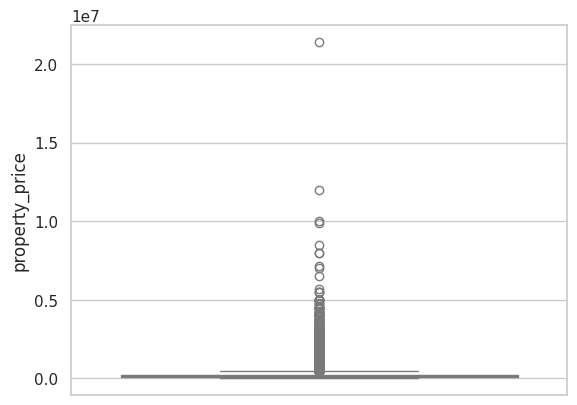

In [409]:
sns.boxplot(y=ds_propiedades_filtradas.property_price)

In [410]:
limite_rango_iq(ds_propiedades_filtradas, 'property_price')

(-115000.0, 305000.0)

Primero analizamos las anomalías más extremas, valores mayores o iguales a 8M.

In [411]:
# Observación anómala
outlier = ds_propiedades_filtradas[ds_propiedades_filtradas['property_price'] >= 8000000]
outlier

id start_date    end_date    latitud   longitud  \
1140    ddV7Ll5c1H+Rmqqovc+uFg== 2021-09-09  2022-01-27 -34.605781 -58.376705   
60073   uoM9HDKq3jZKQKgHXTIGkg== 2021-01-25  2022-05-13 -34.616044 -58.458621   
85725   pKJUYwxjs9j+ub8gzLyc/g== 2021-03-26  2021-06-05 -34.572494 -58.462433   
148534  AExqjjuaRO2KtiPjC8BUiQ== 2021-05-12  2021-05-14 -34.565947 -58.442326   
156777  8ChrVZoOYyEqAJMIP/pXoQ== 2021-02-17  2021-02-19 -34.608300 -58.371200   
248285  I3+CMvLB+tmeXtDg3XmSBA== 2021-09-13  2021-09-16 -34.596801 -58.383768   
332190  PkbD1ixa/IWHlTjwozccRQ== 2021-09-17  2022-03-09 -34.593634 -58.377164   

           place_l3 property_type  property_rooms  property_bedrooms  \
1140    San Nicolás  Departamento             4.0           3.000000   
60073     Caballito  Departamento             3.0           2.000000   
85725      Belgrano          Casa             5.0           4.000000   
148534     Belgrano          Casa             9.0           5.000000   
156777    Monserrat          Casa             3.0           2.000000   
248285     Recoleta  Departamento             8.0           2.000000   
332190       Retiro          Casa            10.0           2.079442   

        property_surface_total  property_surface_covered  property_price  
1140                   10500.0                   10500.0       9900000.0  
60073                     68.0                      64.0      21400000.0  
85725                   3197.0                    3367.0      12000000.0  
148534                  1763.0                    1763.0       8000000.0  
156777                   225.0                      93.0       8500000.0  
248285                   900.0                     150.0       8000000.0  
332190                  1166.0                    1485.0      10000000.0

Buscando propiedades actualmente en venta en barrios y tamaños similares, parecería haber un error. Sin embargo, incluso haciendo un reducción de un decimo (valores más coherentes para esos varrios y tamaños de casas), estaríamos por sobre el límite intercuartil, asi que por ahora no haremos transformaciones.

Analicemos según barrio:

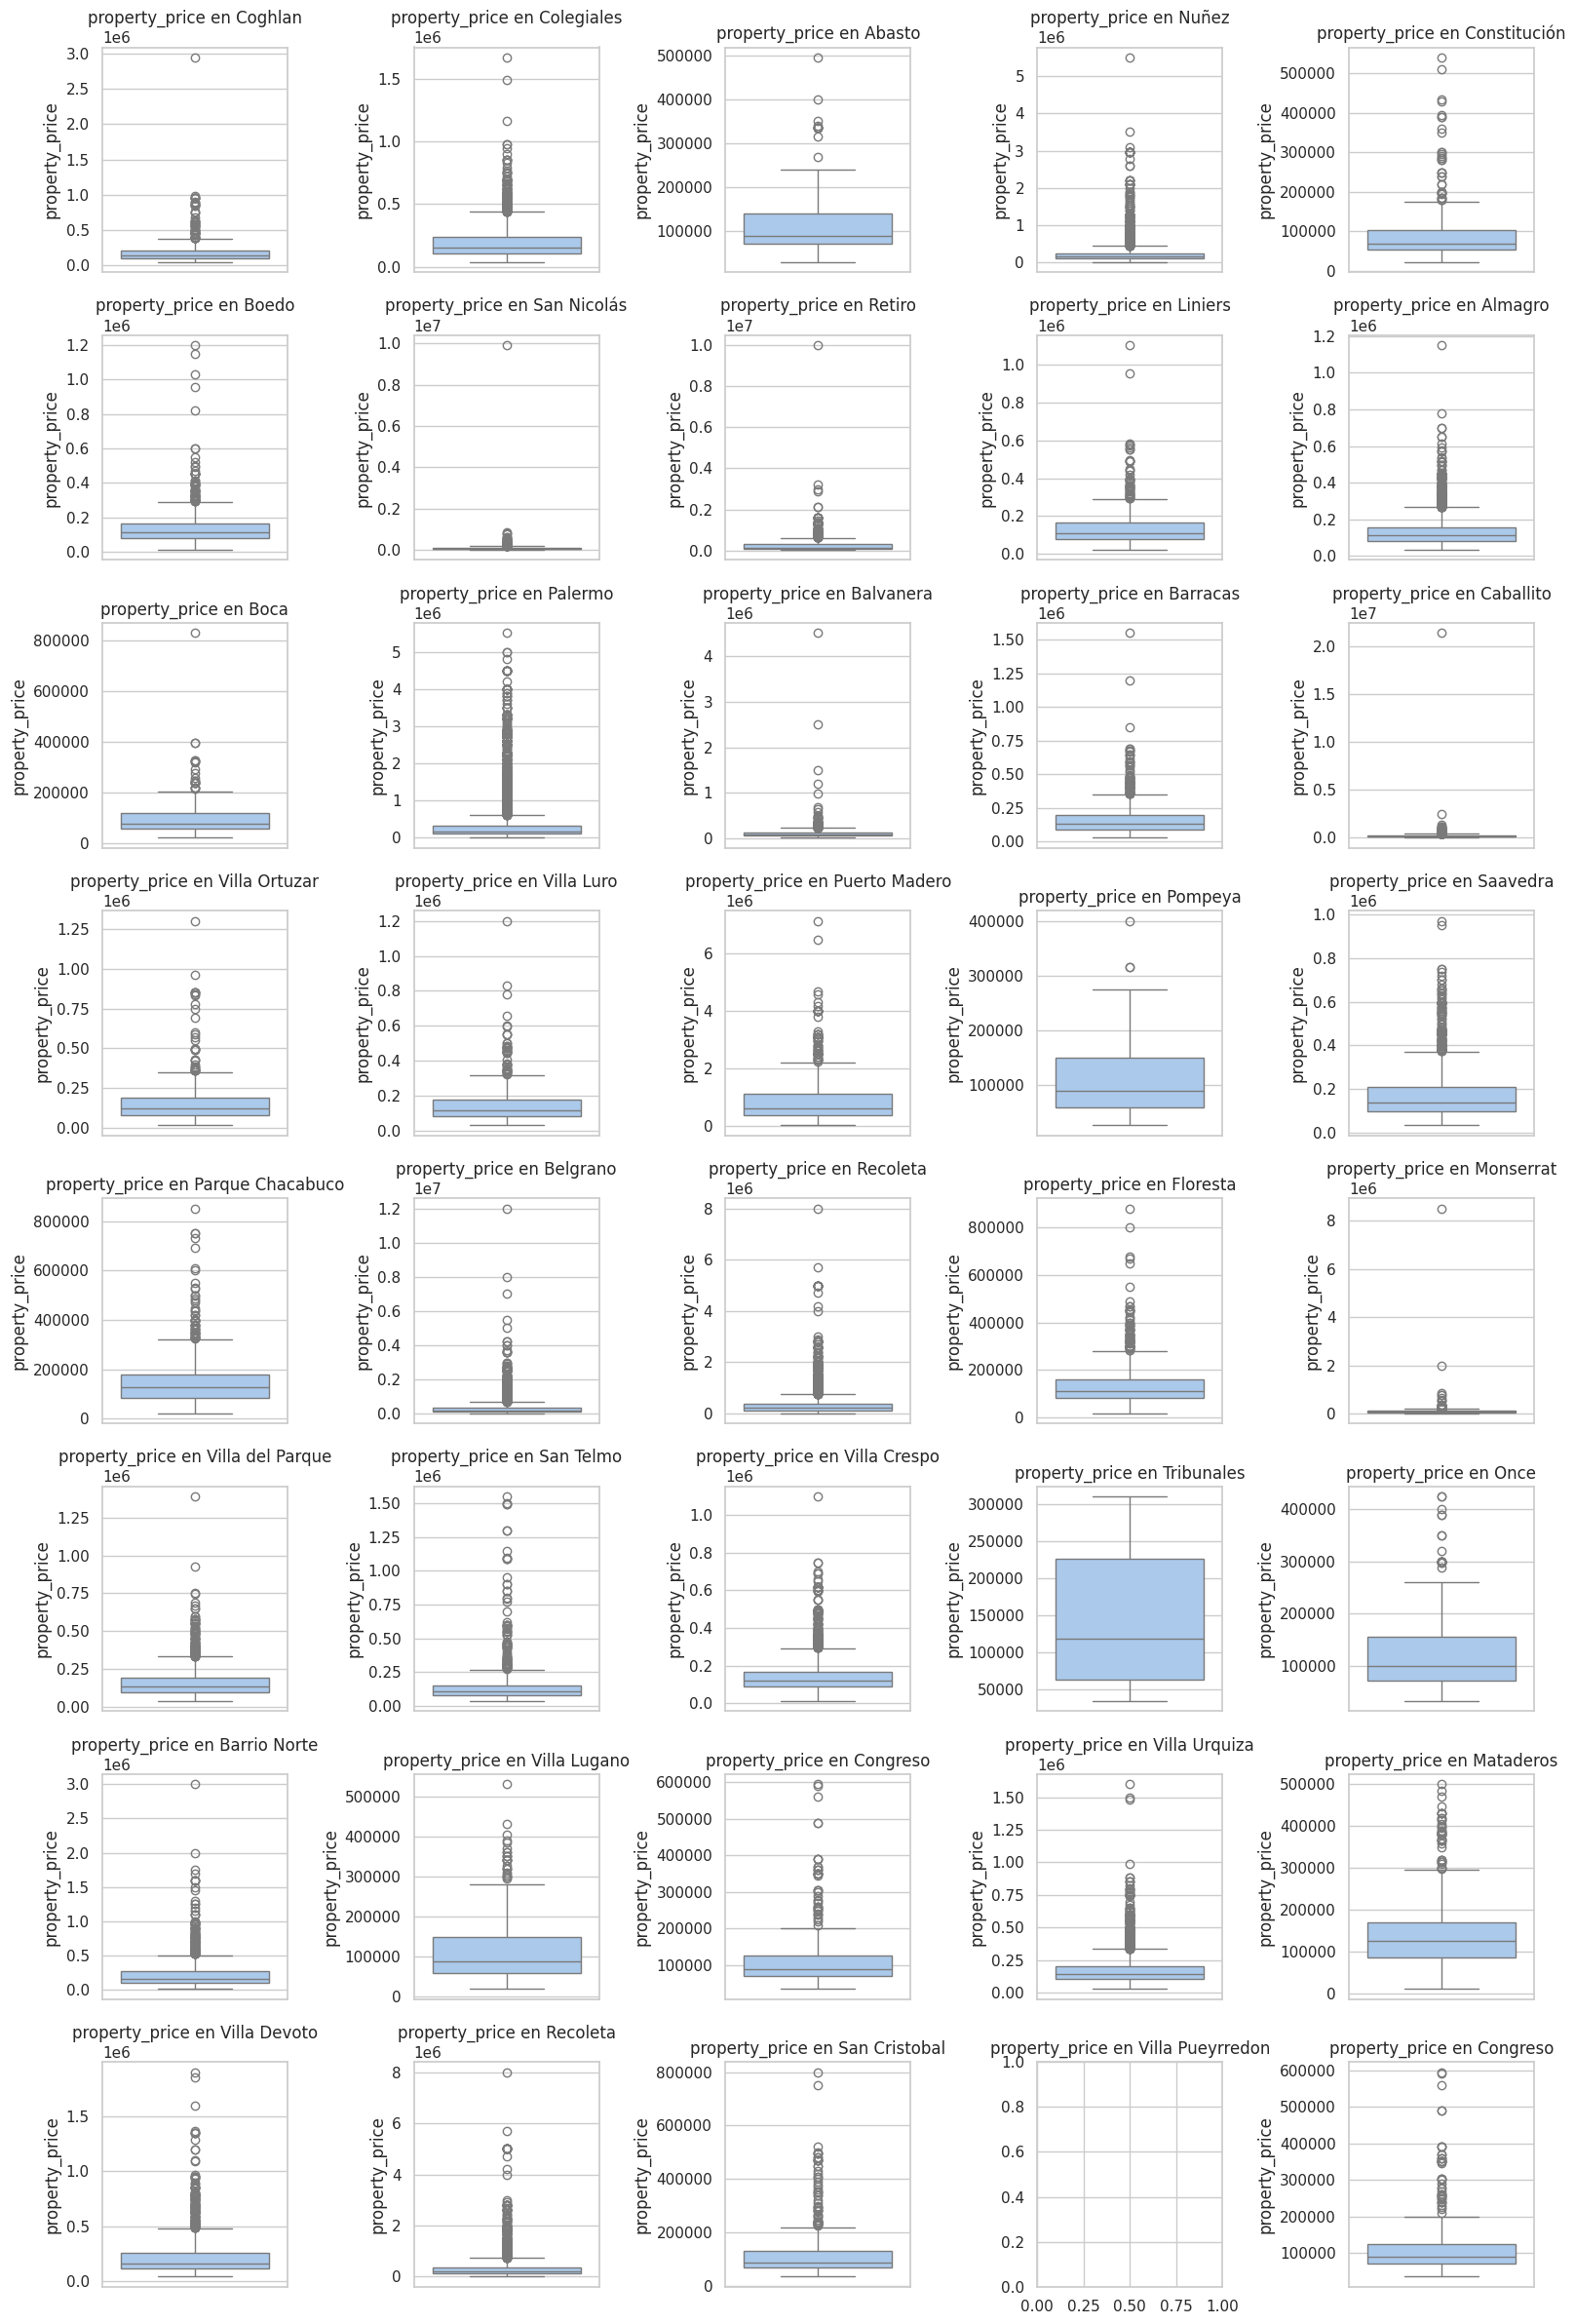

In [412]:
plot_por_barrio(ds_propiedades_filtradas, 'property_price')

Hasta el momento, este el analisis según barrio menos homogéneo. Si tomamos el limite superior intercuartil general (305m), se distorcionarían totalmente los datos de barrios como Palermo y Puerto Madero. Teniendo en cuenta lo relevante que es éste dato a la hora de que se establezca el precio de una propiedad, solo trabajaremos con los outliers que sean extremos en el contexto de cada barrio (analisis multivariado).

*Análisis según superficie cubierta (property_surface_covered)*

<Axes: ylabel='property_surface_covered'>

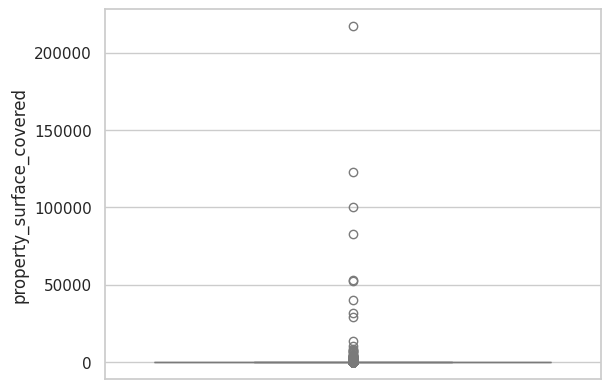

In [413]:
sns.boxplot(y=ds_propiedades_filtradas.property_surface_covered)

In [414]:
limite_rango_iq(ds_propiedades_filtradas, 'property_surface_covered')

(-32.0, 112.0)

In [415]:
# Observación anómala
outlier = ds_propiedades_filtradas[ds_propiedades_filtradas['property_surface_covered'] <= 0]
outlier


Empty DataFrame
Columns: [id, start_date, end_date, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

In [416]:
# Comprobamos buscando indice con la propiedad con la mínima superficie.
min_surface_index = ds_propiedades_filtradas['property_surface_covered'].idxmin()
ds_propiedades_filtradas.loc[min_surface_index]

id                          Ve7j1PIdF65BBnfBKvHD/Q==
start_date                       2021-09-09 00:00:00
end_date                                  2021-09-26
latitud                                   -34.557302
longitud                                  -58.468573
place_l3                                    Belgrano
property_type                           Departamento
property_rooms                                   1.0
property_bedrooms                                1.0
property_surface_total                          25.0
property_surface_covered                         1.0
property_price                              100000.0
Name: 658, dtype: object

 No existen propiedades con superficie negativa.
 Aún así, podemos ver que hay propiedades con superficies que si bien no son negativas, son demasiado pequeñas para el tipo de edificación.

In [417]:
ds_propiedades_filtradas[ds_propiedades_filtradas['property_surface_covered'] < 15]

id start_date    end_date    latitud   longitud  \
299     fWyBppiSbXhNSIjAmVDULg== 2021-09-09  2021-09-26 -34.597934 -58.376981   
658     Ve7j1PIdF65BBnfBKvHD/Q== 2021-09-09  2021-09-26 -34.557302 -58.468573   
2773    3qmlbeo35YzYAWagk7lH/w== 2021-12-17  2022-01-27 -34.592443 -58.396344   
4785    6CJOI3PpThdwY7/4r2CPSA== 2021-09-20  2021-12-04 -34.561966 -58.482349   
6980    6GCrMbib36LOXLRmvDIf2g== 2021-02-09  9999-12-31 -34.679962 -58.468550   
...                          ...        ...         ...        ...        ...   
447187  P1YxgETL7KJEiLoCv4Ckkw== 2021-05-22  2021-06-03 -34.565695 -58.470449   
451219  wctdZODkXBWVoB+ChyEyFQ== 2021-12-16  2022-03-25 -34.557302 -58.468573   
457757  D8b7/DGLk+8ZgrY8K0P/Dw== 2021-05-08  2021-06-05 -34.574584 -58.423848   
458875  6TR3AkdYUUbhf8/w4XvnBg== 2021-01-05  2022-07-02 -34.624678 -58.524197   
459466  SAnTGJlzxrYy0+vAgt+AoA== 2021-01-05  2021-03-18 -34.579681 -58.434233   

            place_l3 property_type  property_rooms  property_bedrooms  \
299           Retiro  Departamento             1.0                1.0   
658         Belgrano  Departamento             1.0                1.0   
2773    Barrio Norte  Departamento             1.0                1.0   
4785         Coghlan  Departamento             1.0                1.0   
6980    Villa Lugano          Casa             4.0                3.0   
...              ...           ...             ...                ...   
447187      Belgrano  Departamento             1.0                1.0   
451219      Belgrano  Departamento             1.0                1.0   
457757       Palermo  Departamento             1.0                1.0   
458875     Versalles          Casa             3.0                2.0   
459466       Palermo  Departamento             1.0                1.0   

        property_surface_total  property_surface_covered  property_price  
299                       14.0                      14.0         45200.0  
658                       25.0                       1.0        100000.0  
2773                      20.0                       1.0         47000.0  
4785                      35.0                       2.0         90000.0  
6980                      57.0                       1.0        225000.0  
...                        ...                       ...             ...  
447187                    35.0                       2.0         74000.0  
451219                    25.0                       1.0        100000.0  
457757                    46.0                       9.0        128000.0  
458875                    38.0                       1.0        290000.0  
459466                    33.0                       1.0        113000.0  

[600 rows x 12 columns]

Tenemos 484 registros de propiedades que tienen menos de 15m^2 cubiertos, y si bien según código urbanistico de la Ciudad de Buenos Aires no permite departamentos tan pequeños, sabemos que eso puede infringirse. Bajo estos supuestos, y viendo los registros que aparecen, vamos a reemplazar aquellos con superficies demasiado pequeñas (menores a 10m^2) por la superficie total.

In [418]:
# Reemplazamos el valor de superficie cubierta por el de superficie total cuando el valor sea menor a 10
ds_propiedades_filtradas.loc[ds_propiedades_filtradas['property_surface_covered'] < 10, 'property_surface_covered'] = ds_propiedades_filtradas.loc[ds_propiedades_filtradas['property_surface_covered'] < 10, 'property_surface_total']

In [419]:
ds_propiedades_filtradas[ds_propiedades_filtradas['property_surface_covered'] < 15]

id start_date    end_date    latitud   longitud  \
299     fWyBppiSbXhNSIjAmVDULg== 2021-09-09  2021-09-26 -34.597934 -58.376981   
17892   QsHoM/bm2HdBBEwnWY+RgA== 2021-08-28  2022-01-27 -34.621756 -58.444437   
19478   J0/gRyRPvFY0WmEU0nY1Fw== 2021-01-27  2021-08-17 -34.602170 -58.412383   
35773   Uj8qMdUrIbFYo0kgN6L5Jg== 2021-02-08  9999-12-31 -34.633350 -58.448066   
36421   VoyodCc8rftOZHr4TeYcpw== 2021-09-21  2022-02-03 -34.576061 -58.421289   
38433   aZRjphLdiNfPd74mAGbrSg== 2021-07-05  2021-08-09 -34.600832 -58.390383   
50425   rBJcf/OUoNMDP0JylFF2Vg== 2021-06-23  2022-02-09 -34.644446 -58.418263   
66841   G+GKcWUzDUZgWgNbR0qvvQ== 2021-11-24  2022-01-27 -34.594277 -58.504012   
72233   txvsZ+X6aRbIQLPPQ3wZ3w== 2021-05-29  2021-06-18 -34.597934 -58.376981   
76920   wNXQe4mGeSb2TxJgWd65PA== 2021-07-17  2021-07-20 -34.625870 -58.384003   
86014   pVG9sES9De/1eQ+tB90NjQ== 2021-03-26  2021-06-05 -34.591110 -58.400685   
92654   zt51kd/217iX/xx8cRl3oQ== 2021-08-03  9999-12-31 -34.592771 -58.379036   
95088   Q5u5v/WYM0C1/XVg1Db86Q== 2021-09-24  2022-03-09 -34.588030 -58.414562   
104165  03zgVf+Yn3GtIEVJOn9I8g== 2021-05-28  2021-06-13 -34.643724 -58.418383   
129239  mrYs9YBzhLRsHBkNWDHBvQ== 2021-07-01  2021-11-25 -34.594277 -58.504012   
140832  2aHER3AXQs3zb3EegLhmgg== 2021-12-08  2022-01-27 -34.588454 -58.385257   
168064  au5LE/h6pCineDWdIhW/bA== 2021-04-30  2021-06-03 -34.606525 -58.430740   
168082  nOmTA76B5Fc56I5HKId9Dg== 2021-04-30  2021-06-03 -34.606525 -58.430740   
168108  aO8mzZYRhXeP+QU7ilBhLw== 2021-04-30  2021-06-03 -34.606525 -58.430740   
178234  3PIuolUQmDVlxT4sWCPe0w== 2021-03-23  2021-06-02 -34.609567 -58.384745   
216786  YrQqgOmS9no9pw9tljj8Pw== 2021-12-22  2022-01-27 -34.621967 -58.372598   
225485  LU1IAN2L0mz4+8+qGftckg== 2021-05-30  2021-06-18 -34.597825 -58.376983   
256405  ogCDRHXTMAni1s5mbB8inA== 2021-11-03  2021-11-09 -34.579846 -58.453041   
264261  o2Pf0aO+jXXSAYM9qcEmzA== 2021-02-26  9999-12-31 -34.627828 -58.490255   
266187  Os54gQ2Oobr3NRSuDQw+cA== 2021-09-02  9999-12-31 -34.598982 -58.423679   
272255  SYaRVm6FpvDHUvyQF7k11w== 2021-06-19  2021-08-27 -34.621756 -58.444437   
295855  YLrVFJt3421Rss33A6OVAA== 2021-07-23  9999-12-31 -34.579351 -58.454196   
301212  /MNEruoihGzhMaUMEfP6TQ== 2021-08-10  2021-11-03 -34.680927 -58.475828   
333830  FfMyx7es1we4sMCZL2XVTw== 2021-12-28  2022-02-09 -34.600456 -58.376960   
380079  j0m6u3qO+aggo+C5vktywA== 2021-05-19  2021-06-05 -34.616451 -58.367147   
390456  D1YXlNA2VtgRssG/F5GqYQ== 2021-05-05  2021-06-05 -34.597768 -58.493337   
401698  BIT3OESAkwXpejzzcVCMiA== 2021-06-17  2021-08-03 -34.592771 -58.379036   
410024  ZCM+3YdmvreGkH7NL6VHGA== 2021-03-19  2021-06-05 -34.618153 -58.362615   
414110  srQJ67wt1GYEyCoxWarDpQ== 2021-10-26  2022-01-27 -34.614544 -58.479047   

                place_l3 property_type  property_rooms  property_bedrooms  \
299               Retiro  Departamento             1.0           1.000000   
17892          Caballito  Departamento             1.0           1.000000   
19478             Abasto  Departamento             2.0           1.000000   
35773   Parque Chacabuco  Departamento             1.0           1.000000   
36421            Palermo  Departamento             3.0           2.995732   
38433         Tribunales  Departamento             1.0           1.000000   
50425            Pompeya  Departamento             1.0           1.000000   
66841       Villa Devoto  Departamento             1.0           1.000000   
72233             Retiro  Departamento             1.0           1.000000   
76920       Constitución  Departamento             1.0           1.000000   
86014           Recoleta  Departamento             4.0           3.401197   
92654           Recoleta  Departamento             1.0           1.000000   
95088       Barrio Norte  Departamento             1.0           1.000000   
104165  Parque Patricios  Departamento             1.0           1.000000   
129239      Villa Devoto  Departamento 

Ahora nos quedan 20 registros unicamente.

In [420]:
ds_propiedades_filtradas[ds_propiedades_filtradas['property_surface_covered'] > 15000]

id start_date    end_date    latitud   longitud  \
1932    eQ/SiyES/mXWsSyAzb3k3A== 2021-12-17  9999-12-31 -34.637026 -58.426283   
72316   BPTyNzwU2D4btCduu8ls3A== 2021-05-29  2021-06-08 -34.578917 -58.429373   
72521   csbBJk04jQXgGZLXTj5WAg== 2021-05-29  2021-06-13 -34.600113 -58.403649   
106598  +YPtNPAzbhoDCLgqF26Q8A== 2021-03-11  2021-04-20 -34.587320 -58.401556   
117835  vyRPw0ch6cIj9Ki5yPUneA== 2021-08-18  2021-08-23 -34.550093 -58.483034   
199905  EDZUWORq83zRgdk9Zqlv+A== 2021-07-25  9999-12-31 -34.604362 -58.392366   
352883  aBZBrjan1XqHjgvjHK6K6Q== 2021-06-25  2021-07-08 -34.550093 -58.483034   
372779  XzTb7kTEpmAKiyhEGSWz4A== 2021-08-24  2021-09-03 -34.555278 -58.459786   
405324  tHz32dZ72wYshPnoABftrg== 2021-01-07  2021-06-02 -34.569963 -58.481658   

                place_l3 property_type  property_rooms  property_bedrooms  \
1932    Parque Chacabuco          Casa        3.135494           2.890372   
72316            Palermo  Departamento        2.000000           1.000000   
72521          Balvanera  Departamento        2.000000           1.000000   
106598      Barrio Norte  Departamento        2.000000           1.000000   
117835          Saavedra  Departamento        2.000000           1.000000   
199905      Barrio Norte  Departamento        4.000000           3.000000   
352883          Saavedra  Departamento        1.000000           1.000000   
372779          Belgrano  Departamento        4.000000           3.000000   
405324     Villa Urquiza            PH        4.000000           3.000000   

        property_surface_total  property_surface_covered  property_price  
1932                  186956.0                  217000.0        250000.0  
72316                  61130.0                   53030.0        225000.0  
72521                  33800.0                   31670.0         66000.0  
106598                 56740.0                   52540.0        175000.0  
117835                 43086.0                   40038.0        114000.0  
199905                    83.0                   83000.0        155000.0  
352883                 29064.0                   29064.0         87400.0  
372779                100068.0                  100051.0        420000.0  
405324                123000.0                  123000.0        165000.0

Los casos de propiedades con superficie cubierta mayor a 15000, parecen ser errores de escala que pueden solucionarse facilmente.

In [421]:
condition = ds_propiedades_filtradas['property_surface_covered'] > 15000
ds_propiedades_filtradas.loc[condition, 'property_surface_covered'] /= 1000

# Vemos si se ha solucionado la anomalía para ésta condición
ds_propiedades_filtradas[ds_propiedades_filtradas['property_surface_covered'] > 15000]

Empty DataFrame
Columns: [id, start_date, end_date, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

In [422]:
ds_propiedades_filtradas[ds_propiedades_filtradas['property_surface_covered'] > 4000]

id start_date    end_date    latitud   longitud  \
1140    ddV7Ll5c1H+Rmqqovc+uFg== 2021-09-09  2022-01-27 -34.605781 -58.376705   
94789   jXPtdq0ibrnXyePLhTi27g== 2021-09-24  2021-09-26 -34.614279 -58.361092   
233699  McdySYNyXo2s4UZ2wypUig== 2021-03-20  2022-03-25 -34.606260 -58.452737   
264624  6uTpssfQ51+UbuvaOXfeRw== 2021-02-26  2021-03-01 -34.576139 -58.468259   
313745  fx1g9YinBKRFrlnCnN6p4Q== 2021-01-06  2021-01-09 -34.649174 -58.413106   
314541  /lzClyxH96pdJl/JI2ofKg== 2021-01-06  2021-01-09 -34.555086 -58.459669   
398069  Z41Yr6x3GUjyoxu+Afv4og== 2021-02-13  2021-03-18 -34.558309 -58.459923   
405272  f0j0vRkfBQUg9LkKhc/Nmw== 2021-01-07  2021-01-09 -34.634638 -58.473519   
459841  9aQHQRqWMburSn+z+Qt5aQ== 2021-01-05  2021-01-09 -34.627876 -58.437996   
459842  Y4PuRUaAW17tsLGwFTukhA== 2021-01-05  2021-01-09 -34.628397 -58.437706   
459847  zMligt7YdiayCjrfqlmbfg== 2021-01-05  2021-01-09 -34.628247 -58.437696   
459849  +9w0GBZbuObF0Nw6AAtu2Q== 2021-01-05  2021-01-09 -34.628282 -58.437803   

             place_l3 property_type  property_rooms  property_bedrooms  \
1140      San Nicolás  Departamento             4.0                3.0   
94789       Caballito  Departamento             2.0                1.0   
233699   Villa Crespo  Departamento             2.0                1.0   
264624  Villa Ortuzar  Departamento             5.0                4.0   
313745        Pompeya            PH             6.0                2.0   
314541       Belgrano  Departamento             1.0                1.0   
398069       Belgrano  Departamento             2.0                1.0   
405272       Floresta            PH             4.0                3.0   
459841      Caballito  Departamento             3.0                2.0   
459842      Caballito  Departamento             3.0                2.0   
459847      Caballito  Departamento             4.0                3.0   
459849      Caballito  Departamento             3.0                2.0   

        property_surface_total  property_surface_covered  property_price  
1140                   10500.0                   10500.0       9900000.0  
94789                   5312.0                    4809.0        145000.0  
233699                  4224.0                    4224.0        100000.0  
264624                 14744.0                   13717.0        330000.0  
313745                  8988.0                    7454.0        125000.0  
314541                  5741.0                    4276.0         85144.0  
398069                  6470.0                    4664.0        149900.0  
405272                  8306.0                    7755.0        129000.0  
459841                  7153.0                    7153.0        177807.0  
459842                  8136.0                    6472.0        203550.0  
459847                 18096.0                    8568.0        324558.0  
459849                  7720.0                    5970.0        167894.0

Mismo que con las propiedades con superficie cubierta mayor a 5000, parece ser un problema de escala.

In [423]:
condition = ds_propiedades_filtradas['property_surface_covered'] > 4000
ds_propiedades_filtradas.loc[condition, 'property_surface_covered'] /= 100

# Vemos si se ha solucionado la anomalía para ésta condición
ds_propiedades_filtradas[ds_propiedades_filtradas['property_surface_covered'] > 4000]

Empty DataFrame
Columns: [id, start_date, end_date, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

In [424]:
ds_propiedades_filtradas[ds_propiedades_filtradas['property_surface_covered'] > 1100]

id start_date    end_date    latitud   longitud  \
51748   DGUIqrE5dSAcW7/SkUWaQA== 2021-06-23  2021-06-28 -34.608698 -58.391820   
85725   pKJUYwxjs9j+ub8gzLyc/g== 2021-03-26  2021-06-05 -34.572494 -58.462433   
104177  rGOjA8tJXYsGapcTNwIKQA== 2021-05-28  2021-06-13 -34.603992 -58.500042   
148534  AExqjjuaRO2KtiPjC8BUiQ== 2021-05-12  2021-05-14 -34.565947 -58.442326   
165965  NzYulXk9Ddrc+qQoqAAGRw== 2021-04-30  2021-06-05 -34.557754 -58.471497   
177140  KVFit7mVm+epRM497KAchw== 2021-03-23  2021-06-05 -34.627279 -58.373637   
177181  q6PytfvCIgQ9xOWk3o+m1A== 2021-03-23  2021-06-05 -34.626697 -58.373873   
187888  Fm8kbPskFOK8xGRsNuCvWQ== 2021-06-05  2021-06-13 -34.606771 -58.502277   
263173  YBglCjqyN6JqZ19HsNlLcQ== 2021-02-26  2021-03-27 -34.557749 -58.471384   
264972  d99ugnqvWTu/psmVhGYVGw== 2021-11-19  2022-01-27 -34.613827 -58.373096   
293109  tB9+CF2yPvyRqYvdI5wVqg== 2021-02-23  2021-06-25 -34.603310 -58.419520   
311702  BrohyhZSUQXAX3HqkGGT+w== 2021-01-03  2021-01-08 -34.609829 -58.385083   
332190  PkbD1ixa/IWHlTjwozccRQ== 2021-09-17  2022-03-09 -34.593634 -58.377164   
354376  oSruKb4+uOYztGpv3h5FKA== 2021-11-04  2022-01-27 -34.579394 -58.453519   
374752  lVGHqc/czs40cpT7bW/dZg== 2021-10-13  2022-01-27 -34.609391 -58.376433   
409283  mpNfyaVZmVoa5okuzXnf+w== 2021-03-19  2021-06-05 -34.599678 -58.436474   
438160  mzH1lMHi7l9z9MTU0eMRVg== 2021-10-27  2022-01-04 -34.630704 -58.400901   

                place_l3 property_type  property_rooms  property_bedrooms  \
51748          Balvanera  Departamento       10.000000           5.000000   
85725           Belgrano          Casa        5.000000           4.000000   
104177  Villa del Parque  Departamento        1.000000           1.000000   
148534          Belgrano          Casa        9.000000           5.000000   
165965           Coghlan          Casa        3.000000           2.000000   
177140          Barracas          Casa        2.833213           2.639057   
177181         San Telmo          Casa        2.833213           2.639057   
187888  Villa del Parque  Departamento        2.000000           1.000000   
263173          Belgrano          Casa        8.000000           2.079442   
264972         San Telmo          Casa        3.000000           2.000000   
293109           Almagro  Departamento        3.000000           2.000000   
311702         Monserrat  Departamento        2.000000           1.000000   
332190            Retiro          Casa       10.000000           2.079442   
354376        Colegiales  Departamento        3.000000           2.000000   
374752         Monserrat          Casa       10.000000           7.000000   
409283           Palermo  Departamento        3.000000           2.000000   
438160  Parque Patricios  Departamento        1.000000           1.000000   

        property_surface_total  property_surface_covered  property_price  
51748                   1151.0                    1212.0       1500000.0  
85725                   3197.0                    3367.0      12000000.0  
104177                  3623.0                    3615.0        110000.0  
148534                  1763.0                    1763.0       8000000.0  
165965                  2266.0                    2266.0       2950000.0  
177140                  2500.0                    2500.0       1550000.0  
177181                  2500.0                    2500.0       1550000.0  
187888                  3425.0                    3425.0         75000.0  
263173                  2204.0                    2204.0       1400000.0  
264972                  1993.0                    1900.0       1150000.0  
293109                  5239.0                    3449.0        119000.0  
311702                  3939.0                    3939.0         64000.0  
332190                  1166.0                    1485.0      10000000.0  
354376                    41.0                    3837.0         83000.0  
374752                  3048.0                    2134.0   

Entre las anomalías que persisten parecería haber un caso de error de escala. A su vez, en los casos donde las habitaciones son regulares (<=5.0) haremos una corrección logaritmica.

In [425]:
# Corección de error de tipeo/escala
ds_propiedades_filtradas.loc[ds_propiedades_filtradas['id'] == 'mzH1lMHi7l9z9MTU0eMRVg==', 'property_surface_covered'] /= 100
# Corrección logaritmica
ds_propiedades_filtradas.loc[(ds_propiedades_filtradas['property_bedrooms'] <= 5.0) & (ds_propiedades_filtradas['property_surface_covered'] > 1100), 'property_surface_covered'] = np.log(ds_propiedades_filtradas['property_surface_covered'])



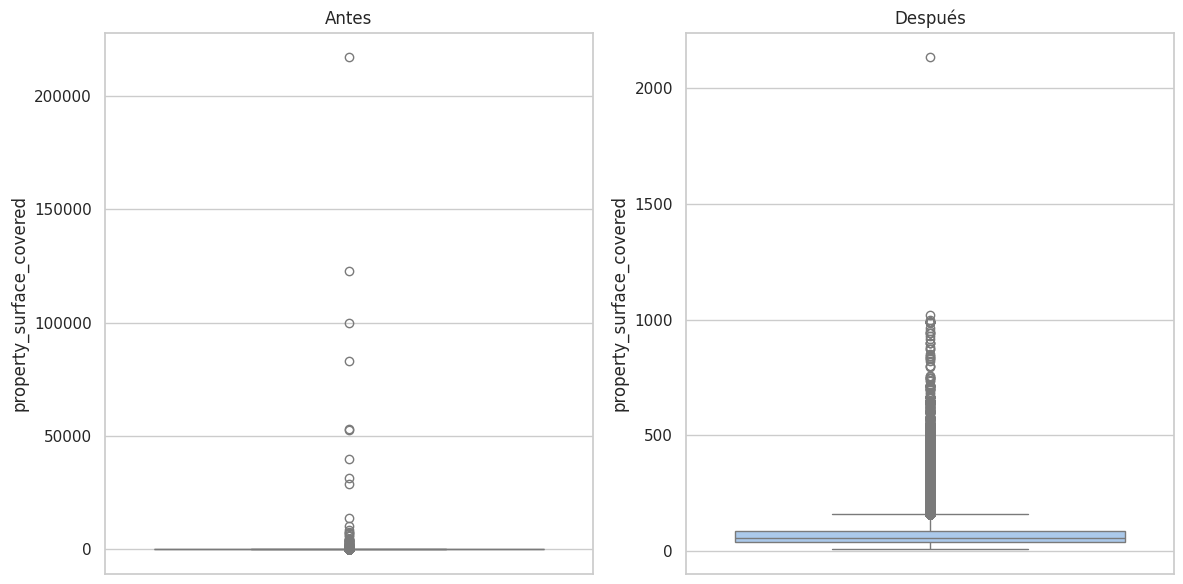

In [426]:
#Comparación del antes y después del analisis de la variable
plot_comparativo(ds_atipicos, ds_propiedades_filtradas, 'property_surface_covered')

In [427]:
ds_propiedades_filtradas[(ds_propiedades_filtradas['property_surface_covered'] > 2000)]

id start_date    end_date    latitud   longitud  \
374752  lVGHqc/czs40cpT7bW/dZg== 2021-10-13  2022-01-27 -34.609391 -58.376433   

         place_l3 property_type  property_rooms  property_bedrooms  \
374752  Monserrat          Casa            10.0                7.0   

        property_surface_total  property_surface_covered  property_price  
374752                  3048.0                    2134.0       1985000.0

Por ahora respetaremos éste valor atipico por ser un dato coherente. Se analizará más tarde.

#### *Análisis según superficie total (property_surface_total)*



<Axes: ylabel='property_surface_total'>

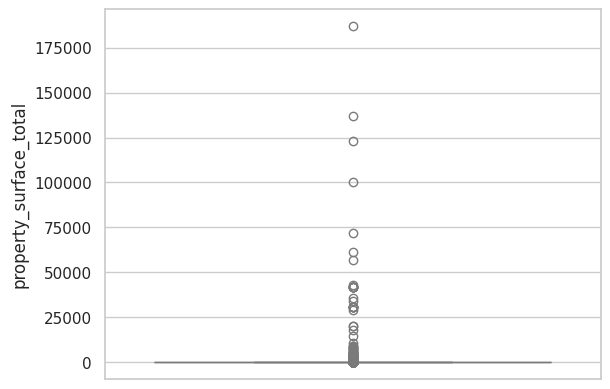

In [428]:
sns.boxplot(y=ds_propiedades_filtradas.property_surface_total)

In [429]:
limite_rango_iq(ds_propiedades_filtradas, 'property_surface_total')

(-45.0, 135.0)

In [430]:
# Observación anómala
outlier = ds_propiedades_filtradas[ds_propiedades_filtradas['property_surface_total'] < 0]
outlier


Empty DataFrame
Columns: [id, start_date, end_date, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

In [431]:
# Comprobamos buscando indice con la propiedad con la mínima superficie.
min_surface_index = ds_propiedades_filtradas['property_surface_total'].idxmin()
ds_propiedades_filtradas.loc[min_surface_index]

id                          us/N38vEYZarzdFzep5a9A==
start_date                       2021-03-15 00:00:00
end_date                                  2021-03-25
latitud                                   -34.633819
longitud                                  -58.504568
place_l3                                  Villa Luro
property_type                           Departamento
property_rooms                                   3.0
property_bedrooms                                2.0
property_surface_total                          10.0
property_surface_covered                        25.0
property_price                              120000.0
Name: 21153, dtype: object

 No existen propiedades con superficie negativa.
 Aún así, podemos ver que hay propiedades con superficies que si bien no son negativas, son demasiado pequeñas para el tipo de edificación.

In [432]:
ds_propiedades_filtradas[ds_propiedades_filtradas['property_surface_total'] < 15]

id start_date    end_date    latitud   longitud  \
299     fWyBppiSbXhNSIjAmVDULg== 2021-09-09  2021-09-26 -34.597934 -58.376981   
21153   us/N38vEYZarzdFzep5a9A== 2021-03-15  2021-03-25 -34.633819 -58.504568   
32068   4jwFTdGy7N11fF14hLplcw== 2021-05-17  2021-06-05 -34.571979 -58.446945   
38433   aZRjphLdiNfPd74mAGbrSg== 2021-07-05  2021-08-09 -34.600832 -58.390383   
41088   ngtAPqtsUhn8Y9+r/FgteA== 2021-07-19  9999-12-31 -34.614573 -58.480650   
41192   jLK6eCdVrULnEhLxS2kgUg== 2021-01-12  2021-02-05 -34.635506 -58.417926   
50425   rBJcf/OUoNMDP0JylFF2Vg== 2021-06-23  2022-02-09 -34.644446 -58.418263   
72233   txvsZ+X6aRbIQLPPQ3wZ3w== 2021-05-29  2021-06-18 -34.597934 -58.376981   
76920   wNXQe4mGeSb2TxJgWd65PA== 2021-07-17  2021-07-20 -34.625870 -58.384003   
104165  03zgVf+Yn3GtIEVJOn9I8g== 2021-05-28  2021-06-13 -34.643724 -58.418383   
154950  /4B1aoAn2OzWObpjXevrmg== 2021-02-03  2022-09-01 -34.637580 -58.500624   
168064  au5LE/h6pCineDWdIhW/bA== 2021-04-30  2021-06-03 -34.606525 -58.430740   
168082  nOmTA76B5Fc56I5HKId9Dg== 2021-04-30  2021-06-03 -34.606525 -58.430740   
168108  aO8mzZYRhXeP+QU7ilBhLw== 2021-04-30  2021-06-03 -34.606525 -58.430740   
168118  gsbwHqWC2NW1ywgCJd0xaQ== 2021-04-30  2021-06-03 -34.606525 -58.430740   
178234  3PIuolUQmDVlxT4sWCPe0w== 2021-03-23  2021-06-02 -34.609567 -58.384745   
180380  i16eZUm9vHNMrQMT82+9hQ== 2021-02-16  2021-12-09 -34.634265 -58.505317   
190609  /MC0i98hQuKwdP9/I6NdRg== 2021-10-09  2022-01-27 -34.568710 -58.473026   
216786  YrQqgOmS9no9pw9tljj8Pw== 2021-12-22  2022-01-27 -34.621967 -58.372598   
225485  LU1IAN2L0mz4+8+qGftckg== 2021-05-30  2021-06-18 -34.597825 -58.376983   
333830  FfMyx7es1we4sMCZL2XVTw== 2021-12-28  2022-02-09 -34.600456 -58.376960   
334734  YHwlmP7ig5lyXrqU3Othlw== 2021-12-28  2022-01-27 -34.563734 -58.483824   

                place_l3 property_type  property_rooms  property_bedrooms  \
299               Retiro  Departamento             1.0           1.000000   
21153         Villa Luro  Departamento             3.0           2.000000   
32068           Belgrano  Departamento             3.0           2.000000   
38433         Tribunales  Departamento             1.0           1.000000   
41088   Villa del Parque  Departamento             2.0           2.397895   
41192              Boedo            PH             4.0           3.000000   
50425            Pompeya  Departamento             1.0           1.000000   
72233             Retiro  Departamento             1.0           1.000000   
76920       Constitución  Departamento             1.0           1.000000   
104165  Parque Patricios  Departamento             1.0           1.000000   
154950        Villa Luro  Departamento             1.0           1.000000   
168064         Caballito  Departamento             3.0           2.000000   
168082         Caballito  Departamento             3.0           2.000000   
168108         Caballito  Departamento             3.0           2.000000   
168118         Caballito  Departamento             3.0           2.000000   
178234         Monserrat  Departamento             1.0           1.000000   
180380        Villa Luro  Departamento             3.0           2.000000   
190609          Saavedra  Departamento             1.0           1.000000   
216786         San Telmo  Departamento             1.0           1.000000   
225485            Retiro  Departamento             1.0           1.000000   
333830            Retiro  Departamento             1.0           1.000000   
334734     Villa Urquiza  Departamento             2.0           1.000000   

        property_surface_total  property_surface_covered  property_price  
299                       14.0                      14.0         45200.0  
21153                     10.0                      25.0        120000.0  
32068                     10.0                      65.0        172216.0  
38433                     10.0                      10.0         35000.0  
41088              

Por las razones ya expuestas y teniendo en cuenta que son todos departamentos, decidimos reemplazar los datos de superficie total por los de superficie cubierta.

In [433]:
# Reemplazamos el valor de superficie cubierta por el de superficie total cuando el valor sea menor a 10
ds_propiedades_filtradas.loc[ds_propiedades_filtradas['property_surface_total'] < 15, 'property_surface_total'] = ds_propiedades_filtradas.loc[ds_propiedades_filtradas['property_surface_total'] < 15, 'property_surface_covered']

In [434]:
# Revisamos y solo quedan aquellos casos donde la superficie cubierta también era menor a 15.
ds_propiedades_filtradas[ds_propiedades_filtradas['property_surface_total'] < 15]

id start_date    end_date    latitud   longitud  \
299     fWyBppiSbXhNSIjAmVDULg== 2021-09-09  2021-09-26 -34.597934 -58.376981   
38433   aZRjphLdiNfPd74mAGbrSg== 2021-07-05  2021-08-09 -34.600832 -58.390383   
50425   rBJcf/OUoNMDP0JylFF2Vg== 2021-06-23  2022-02-09 -34.644446 -58.418263   
72233   txvsZ+X6aRbIQLPPQ3wZ3w== 2021-05-29  2021-06-18 -34.597934 -58.376981   
76920   wNXQe4mGeSb2TxJgWd65PA== 2021-07-17  2021-07-20 -34.625870 -58.384003   
104165  03zgVf+Yn3GtIEVJOn9I8g== 2021-05-28  2021-06-13 -34.643724 -58.418383   
168064  au5LE/h6pCineDWdIhW/bA== 2021-04-30  2021-06-03 -34.606525 -58.430740   
168082  nOmTA76B5Fc56I5HKId9Dg== 2021-04-30  2021-06-03 -34.606525 -58.430740   
168108  aO8mzZYRhXeP+QU7ilBhLw== 2021-04-30  2021-06-03 -34.606525 -58.430740   
178234  3PIuolUQmDVlxT4sWCPe0w== 2021-03-23  2021-06-02 -34.609567 -58.384745   
216786  YrQqgOmS9no9pw9tljj8Pw== 2021-12-22  2022-01-27 -34.621967 -58.372598   
225485  LU1IAN2L0mz4+8+qGftckg== 2021-05-30  2021-06-18 -34.597825 -58.376983   
333830  FfMyx7es1we4sMCZL2XVTw== 2021-12-28  2022-02-09 -34.600456 -58.376960   

                place_l3 property_type  property_rooms  property_bedrooms  \
299               Retiro  Departamento             1.0                1.0   
38433         Tribunales  Departamento             1.0                1.0   
50425            Pompeya  Departamento             1.0                1.0   
72233             Retiro  Departamento             1.0                1.0   
76920       Constitución  Departamento             1.0                1.0   
104165  Parque Patricios  Departamento             1.0                1.0   
168064         Caballito  Departamento             3.0                2.0   
168082         Caballito  Departamento             3.0                2.0   
168108         Caballito  Departamento             3.0                2.0   
178234         Monserrat  Departamento             1.0                1.0   
216786         San Telmo  Departamento             1.0                1.0   
225485            Retiro  Departamento             1.0                1.0   
333830            Retiro  Departamento             1.0                1.0   

        property_surface_total  property_surface_covered  property_price  
299                       14.0                      14.0         45200.0  
38433                     10.0                      10.0         35000.0  
50425                     14.0                      14.0         26500.0  
72233                     14.0                      14.0         45200.0  
76920                     14.0                      14.0         24500.0  
104165                    14.0                      14.0         31500.0  
168064                    12.0                      12.0         20000.0  
168082                    12.0                      12.0         22000.0  
168108                    12.0                      12.0         23000.0  
178234                    13.0                      13.0         55000.0  
216786                    14.0                      14.0         38000.0  
225485                    13.0                      13.0         38900.0  
333830                    14.0                      14.0         37300.0

In [435]:
ds_propiedades_filtradas[ds_propiedades_filtradas['property_surface_total'] > 100000]

id start_date    end_date    latitud   longitud  \
1932    eQ/SiyES/mXWsSyAzb3k3A== 2021-12-17  9999-12-31 -34.637026 -58.426283   
129214  tJ7TjXeyIl+4KPkaPqyAYA== 2021-07-01  9999-12-31 -34.599421 -58.386867   
372779  XzTb7kTEpmAKiyhEGSWz4A== 2021-08-24  2021-09-03 -34.555278 -58.459786   
405324  tHz32dZ72wYshPnoABftrg== 2021-01-07  2021-06-02 -34.569963 -58.481658   

                place_l3 property_type  property_rooms  property_bedrooms  \
1932    Parque Chacabuco          Casa        3.135494           2.890372   
129214      Barrio Norte  Departamento        5.000000           3.000000   
372779          Belgrano  Departamento        4.000000           3.000000   
405324     Villa Urquiza            PH        4.000000           3.000000   

        property_surface_total  property_surface_covered  property_price  
1932                  186956.0                   217.000        250000.0  
129214                137000.0                   135.000        390000.0  
372779                100068.0                   100.051        420000.0  
405324                123000.0                   123.000        165000.0

En el caso de la propiedad de Parque Chacabuco, ninguno de los datos tiene coherencia al mirarlos en conjunto: una casa de 22.75 ambientes, y 17.23 habitaciones, con una superficie cubierta de 217.0 y total de 177198m^2. Tendriamos que imputar todos estos datos lo cual no tendría sentido, nos quedariamos con poco material real.

En los otros dos casos, parece ser más un error de escala asi que lo normalizamos.

In [436]:
# Eliminamos outlier por indice
id_outlier = ds_propiedades_filtradas[ds_propiedades_filtradas['property_surface_total'] > 170000].index
ds_propiedades_filtradas.drop(id_outlier,inplace=True)

In [437]:
# Modificamos los otros
condition = ds_propiedades_filtradas['property_surface_total'] > 100000
ds_propiedades_filtradas.loc[condition, 'property_surface_total'] /= 1000

ds_propiedades_filtradas[ds_propiedades_filtradas['property_surface_total'] > 100000]

Empty DataFrame
Columns: [id, start_date, end_date, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price]
Index: []

In [438]:
ds_propiedades_filtradas[ds_propiedades_filtradas['property_surface_total'] > 7000]

id start_date    end_date    latitud   longitud  \
1140    ddV7Ll5c1H+Rmqqovc+uFg== 2021-09-09  2022-01-27 -34.605781 -58.376705   
72316   BPTyNzwU2D4btCduu8ls3A== 2021-05-29  2021-06-08 -34.578917 -58.429373   
72521   csbBJk04jQXgGZLXTj5WAg== 2021-05-29  2021-06-13 -34.600113 -58.403649   
84073   vMD1fCSS0kedOs8Bk/PCjA== 2021-02-05  2021-05-16 -34.588175 -58.396261   
106598  +YPtNPAzbhoDCLgqF26Q8A== 2021-03-11  2021-04-20 -34.587320 -58.401556   
117835  vyRPw0ch6cIj9Ki5yPUneA== 2021-08-18  2021-08-23 -34.550093 -58.483034   
126869  MYZD6oNPlLhMzVLoEbL9jw== 2021-10-05  2021-11-04 -34.579163 -58.455725   
219021  WQU6YIN+y4z30xaPRG4LHQ== 2021-03-07  2022-02-09 -34.636532 -58.376406   
237392  wGXDCrWhpDX+JQBrC+7jpA== 2021-02-27  2021-03-03 -34.628721 -58.421383   
263945  xTMT4WGUrto9Ee8CBjxUxw== 2021-02-26  2021-02-28 -34.576096 -58.441278   
264624  6uTpssfQ51+UbuvaOXfeRw== 2021-02-26  2021-03-01 -34.576139 -58.468259   
275253  5nXtCXuxHhkZ51syuRB7YQ== 2021-09-15  2021-10-07 -34.579163 -58.455725   
300394  E2FhGbtCzmdLHk9QEY47BA== 2021-08-10  2021-09-15 -34.579163 -58.455725   
304492  Psg4w1RO9GxZAski6P2B8g== 2021-04-15  2021-06-05 -34.579163 -58.455725   
313745  fx1g9YinBKRFrlnCnN6p4Q== 2021-01-06  2021-01-09 -34.649174 -58.413106   
324541  s0do8ciUehI3xXZNULgg+Q== 2021-03-03  2021-03-23 -34.628721 -58.421383   
352883  aBZBrjan1XqHjgvjHK6K6Q== 2021-06-25  2021-07-08 -34.550093 -58.483034   
353009  f7xAHgUi1ruXPA9JxKGK6g== 2021-06-25  2021-08-10 -34.579163 -58.455725   
362741  G7sKDYpvhrBrps0xzAQrmQ== 2021-01-16  2021-04-14 -34.579163 -58.455725   
370917  OC6HYSBo/pqio5ZTLgoPvg== 2021-04-24  2021-06-05 -34.571747 -58.422612   
370918  rnFgWleVdid1Czn05PkodA== 2021-04-24  2021-06-05 -34.571747 -58.422612   
370919  9p8XKpRRE9vzUT7Y/5FZ7Q== 2021-04-24  2021-06-05 -34.571747 -58.422612   
370920  HVcSoFtn8OjGl2rbv0GsBw== 2021-04-24  2021-06-05 -34.571747 -58.422612   
370921  DhCI1Vz1PAu5fOy930TFXw== 2021-04-24  2021-06-05 -34.571747 -58.422612   
370922  MkaLWAz6PgutYgXwXxPEjQ== 2021-04-24  2021-06-05 -34.571747 -58.422612   
370932  IQUQeru+sjv8TBWlLfs+SA== 2021-04-24  2021-06-05 -34.571747 -58.422612   
405272  f0j0vRkfBQUg9LkKhc/Nmw== 2021-01-07  2021-01-09 -34.634638 -58.473519   
459841  9aQHQRqWMburSn+z+Qt5aQ== 2021-01-05  2021-01-09 -34.627876 -58.437996   
459842  Y4PuRUaAW17tsLGwFTukhA== 2021-01-05  2021-01-09 -34.628397 -58.437706   
459847  zMligt7YdiayCjrfqlmbfg== 2021-01-05  2021-01-09 -34.628247 -58.437696   
459849  +9w0GBZbuObF0Nw6AAtu2Q== 2021-01-05  2021-01-09 -34.628282 -58.437803   

             place_l3 property_type  property_rooms  property_bedrooms  \
1140      San Nicolás  Departamento             4.0                3.0   
72316         Palermo  Departamento             2.0                1.0   
72521       Balvanera  Departamento             2.0                1.0   
84073        Recoleta  Departamento             1.0                1.0   
106598   Barrio Norte  Departamento             2.0                1.0   
117835       Saavedra  Departamento             2.0                1.0   
126869     Colegiales  Departamento             1.0                1.0   
219021       Barracas  Departamento             4.0                3.0   
237392          Boedo            PH             4.0                3.0   
263945        Palermo  Departamento             3.0                2.0   
264624  Villa Ortuzar  Departamento             5.0                4.0   
275253     Colegiales  Departamento             1.0                1.0   
300394     Colegiales  Departamento             1.0                1.0   
304492     Colegiales  Departamento             1.0                1.0   
313745        Pompeya            PH             6.0                2.0   
324541          Boedo            PH             4.0                3.0   
352883       Saavedra  Departamento             1.0                1.0   
353009     Colegiales  Departamento             1.0                1.0   
362741     Colegiales  Departam

Se ve una tendencia entre la superficie total y la superficie cubierta que indicaría un error de escala. Vamos a corregirlo.

In [439]:
# Buscamos las filas donde property_surface_total / 100 == property_surface_covered y hacemos una máscara.
mask = ds_propiedades_filtradas['property_surface_total'] / 100 == ds_propiedades_filtradas['property_surface_covered']

# Reemplazamos property_surface_total con property_surface_covered en esos casos
ds_propiedades_filtradas.loc[mask, 'property_surface_total'] = ds_propiedades_filtradas.loc[mask, 'property_surface_covered']

In [440]:
ds_propiedades_filtradas[ds_propiedades_filtradas['property_surface_total'] > 7000]

id start_date    end_date    latitud   longitud  \
72316   BPTyNzwU2D4btCduu8ls3A== 2021-05-29  2021-06-08 -34.578917 -58.429373   
72521   csbBJk04jQXgGZLXTj5WAg== 2021-05-29  2021-06-13 -34.600113 -58.403649   
84073   vMD1fCSS0kedOs8Bk/PCjA== 2021-02-05  2021-05-16 -34.588175 -58.396261   
106598  +YPtNPAzbhoDCLgqF26Q8A== 2021-03-11  2021-04-20 -34.587320 -58.401556   
117835  vyRPw0ch6cIj9Ki5yPUneA== 2021-08-18  2021-08-23 -34.550093 -58.483034   
126869  MYZD6oNPlLhMzVLoEbL9jw== 2021-10-05  2021-11-04 -34.579163 -58.455725   
219021  WQU6YIN+y4z30xaPRG4LHQ== 2021-03-07  2022-02-09 -34.636532 -58.376406   
237392  wGXDCrWhpDX+JQBrC+7jpA== 2021-02-27  2021-03-03 -34.628721 -58.421383   
263945  xTMT4WGUrto9Ee8CBjxUxw== 2021-02-26  2021-02-28 -34.576096 -58.441278   
264624  6uTpssfQ51+UbuvaOXfeRw== 2021-02-26  2021-03-01 -34.576139 -58.468259   
275253  5nXtCXuxHhkZ51syuRB7YQ== 2021-09-15  2021-10-07 -34.579163 -58.455725   
300394  E2FhGbtCzmdLHk9QEY47BA== 2021-08-10  2021-09-15 -34.579163 -58.455725   
304492  Psg4w1RO9GxZAski6P2B8g== 2021-04-15  2021-06-05 -34.579163 -58.455725   
313745  fx1g9YinBKRFrlnCnN6p4Q== 2021-01-06  2021-01-09 -34.649174 -58.413106   
324541  s0do8ciUehI3xXZNULgg+Q== 2021-03-03  2021-03-23 -34.628721 -58.421383   
352883  aBZBrjan1XqHjgvjHK6K6Q== 2021-06-25  2021-07-08 -34.550093 -58.483034   
353009  f7xAHgUi1ruXPA9JxKGK6g== 2021-06-25  2021-08-10 -34.579163 -58.455725   
362741  G7sKDYpvhrBrps0xzAQrmQ== 2021-01-16  2021-04-14 -34.579163 -58.455725   
370917  OC6HYSBo/pqio5ZTLgoPvg== 2021-04-24  2021-06-05 -34.571747 -58.422612   
370918  rnFgWleVdid1Czn05PkodA== 2021-04-24  2021-06-05 -34.571747 -58.422612   
370919  9p8XKpRRE9vzUT7Y/5FZ7Q== 2021-04-24  2021-06-05 -34.571747 -58.422612   
370920  HVcSoFtn8OjGl2rbv0GsBw== 2021-04-24  2021-06-05 -34.571747 -58.422612   
370921  DhCI1Vz1PAu5fOy930TFXw== 2021-04-24  2021-06-05 -34.571747 -58.422612   
370922  MkaLWAz6PgutYgXwXxPEjQ== 2021-04-24  2021-06-05 -34.571747 -58.422612   
370932  IQUQeru+sjv8TBWlLfs+SA== 2021-04-24  2021-06-05 -34.571747 -58.422612   
405272  f0j0vRkfBQUg9LkKhc/Nmw== 2021-01-07  2021-01-09 -34.634638 -58.473519   
459842  Y4PuRUaAW17tsLGwFTukhA== 2021-01-05  2021-01-09 -34.628397 -58.437706   
459847  zMligt7YdiayCjrfqlmbfg== 2021-01-05  2021-01-09 -34.628247 -58.437696   
459849  +9w0GBZbuObF0Nw6AAtu2Q== 2021-01-05  2021-01-09 -34.628282 -58.437803   

             place_l3 property_type  property_rooms  property_bedrooms  \
72316         Palermo  Departamento             2.0                1.0   
72521       Balvanera  Departamento             2.0                1.0   
84073        Recoleta  Departamento             1.0                1.0   
106598   Barrio Norte  Departamento             2.0                1.0   
117835       Saavedra  Departamento             2.0                1.0   
126869     Colegiales  Departamento             1.0                1.0   
219021       Barracas  Departamento             4.0                3.0   
237392          Boedo            PH             4.0                3.0   
263945        Palermo  Departamento             3.0                2.0   
264624  Villa Ortuzar  Departamento             5.0                4.0   
275253     Colegiales  Departamento             1.0                1.0   
300394     Colegiales  Departamento             1.0                1.0   
304492     Colegiales  Departamento             1.0                1.0   
313745        Pompeya            PH             6.0                2.0   
324541          Boedo            PH             4.0                3.0   
352883       Saavedra  Departamento             1.0                1.0   
353009     Colegiales  Departamento             1.0                1.0   
362741     Colegiales  Departamento             1.0                1.0   
370917        Palermo  Departamento             4.0                3.0   
370918        Palermo  Departamento             4.0                3.0   
370919        Palermo  Departamento          

Algunos registros específicos parecen ser errores de tipeo/escala. Los corregimos manualmente y el resto serán corregidos logaritmicamente.

In [441]:
# Corección de error de tipeo/escala
condition = (ds_propiedades_filtradas['property_surface_total'] == 31000) & (ds_propiedades_filtradas['property_surface_covered'] == 26)
condition2 = (ds_propiedades_filtradas['property_surface_total'] == 42110.0) & (ds_propiedades_filtradas['property_surface_covered'] == 307)
ds_propiedades_filtradas.loc[condition, 'property_surface_total'] /= 1000
ds_propiedades_filtradas.loc[condition2, 'property_surface_total'] /= 100


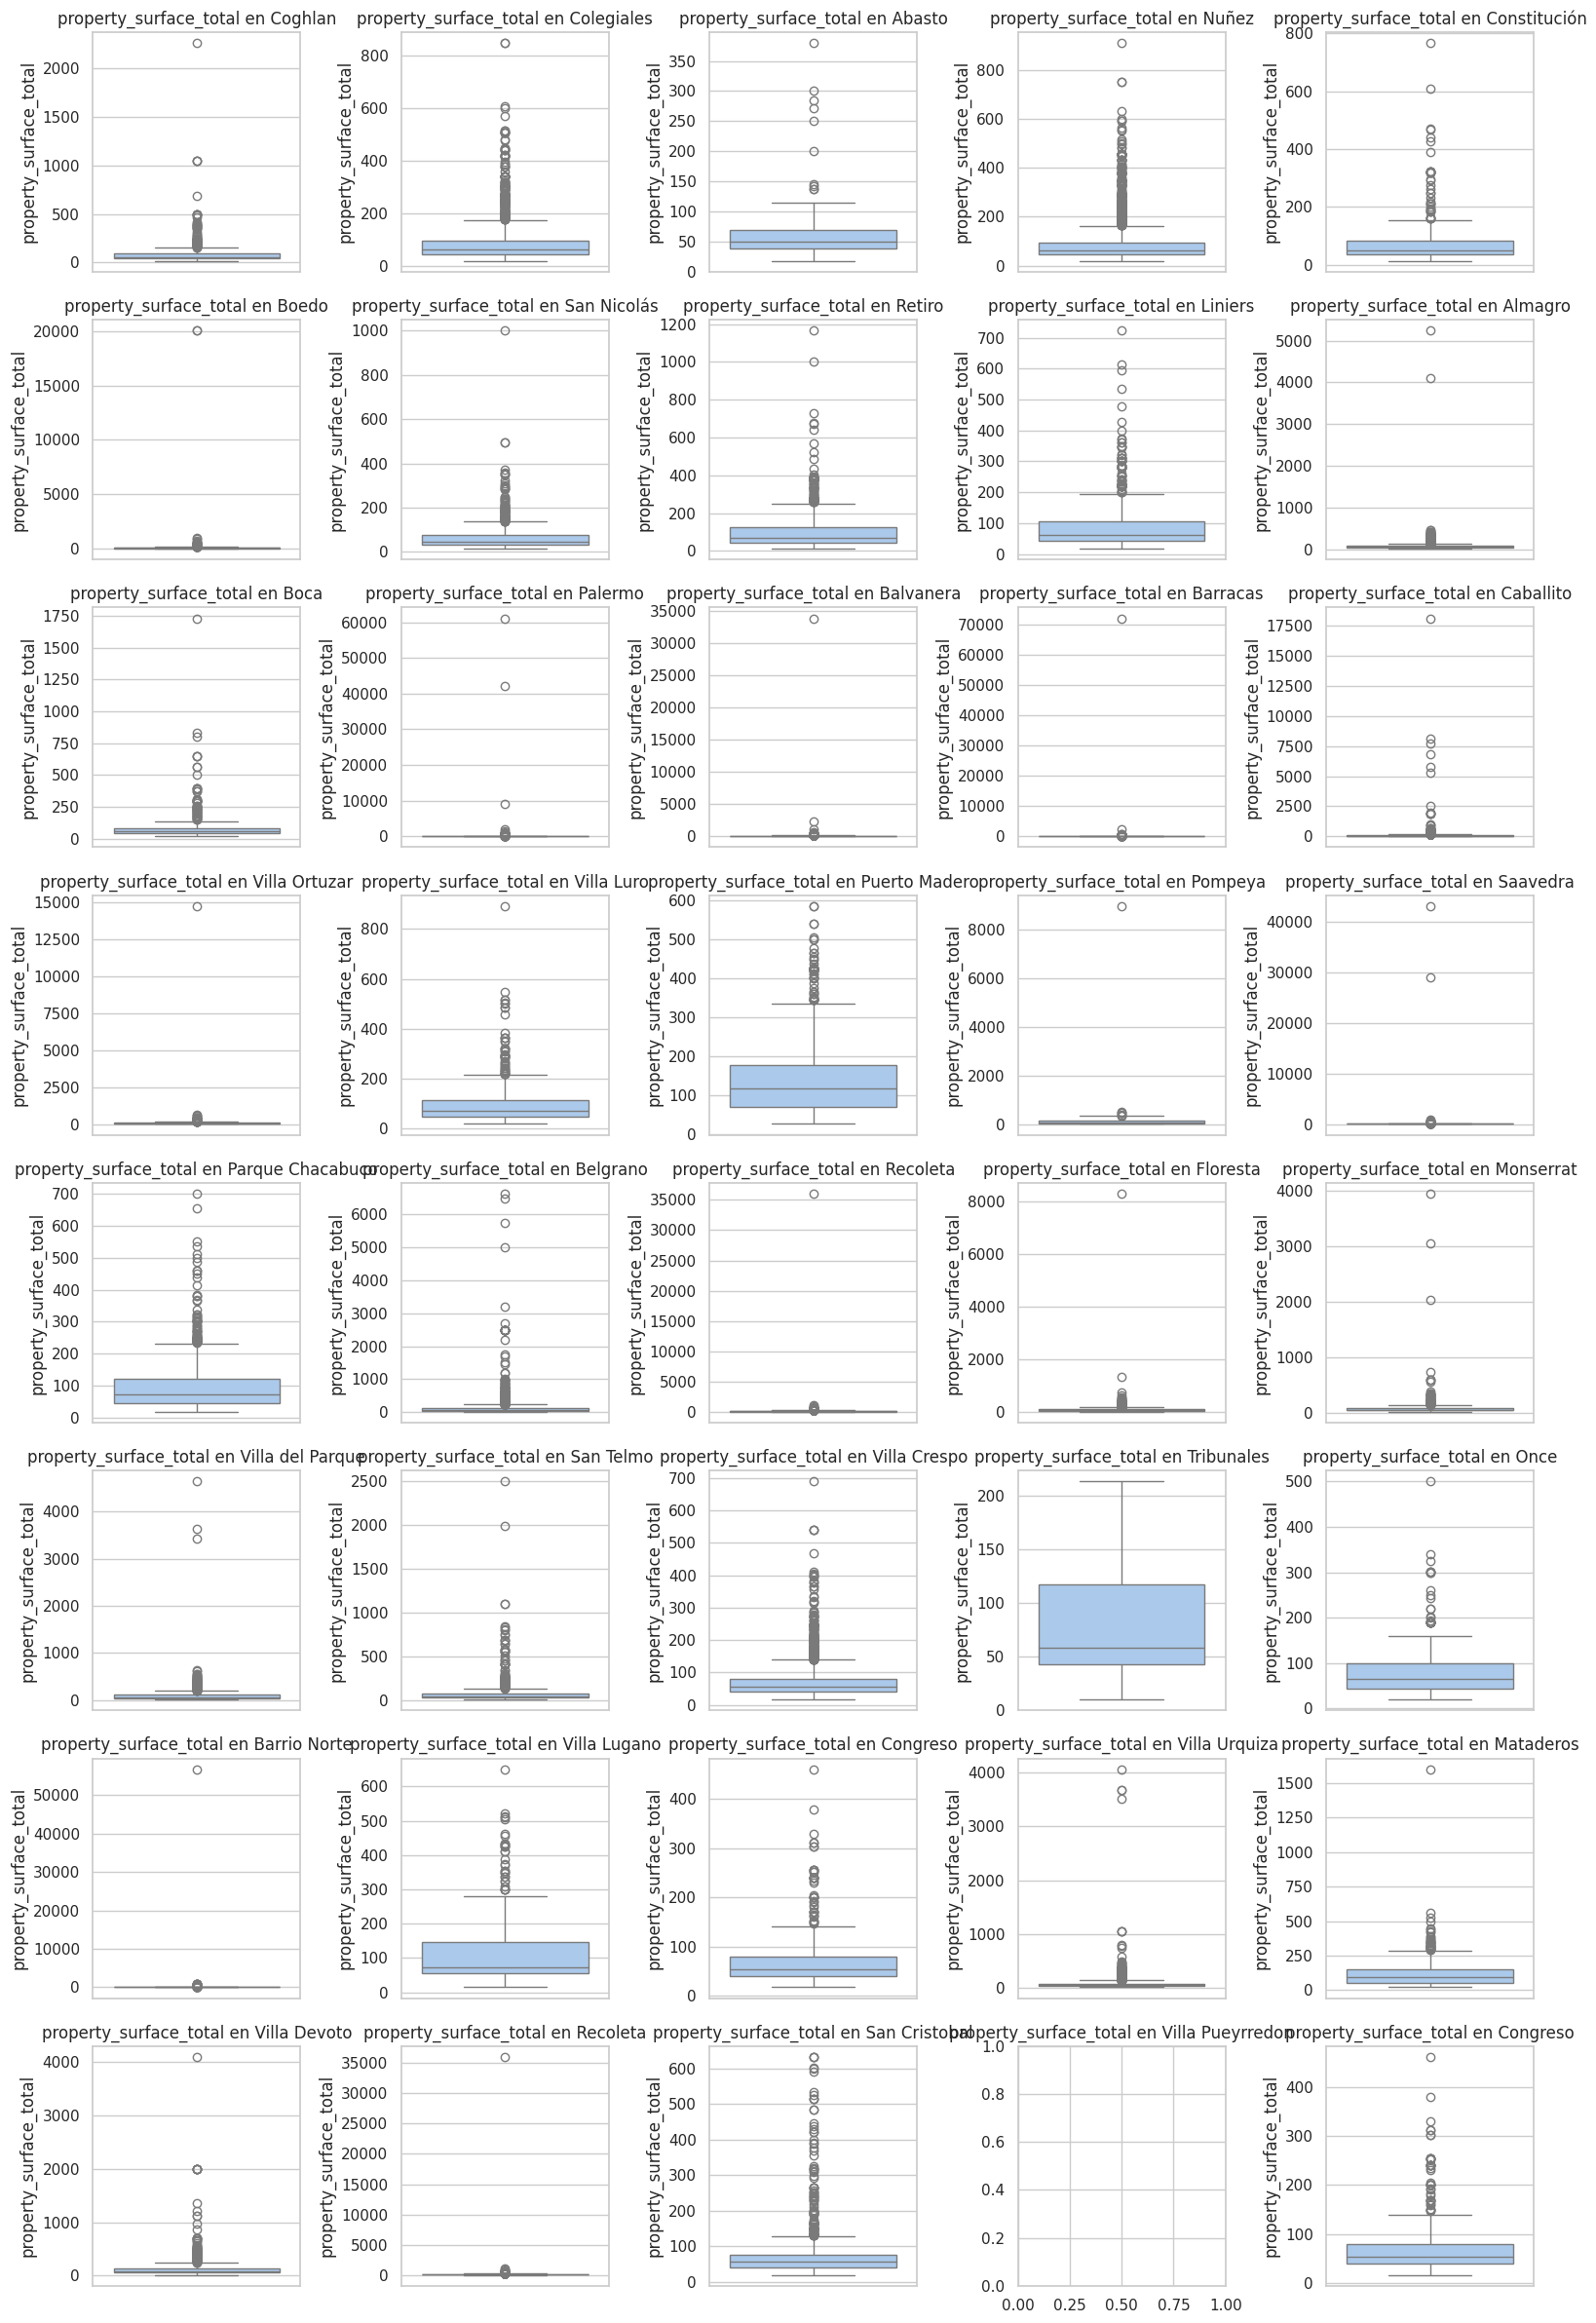

In [442]:
plot_por_barrio(ds_propiedades_filtradas, 'property_surface_total')

Podemos ver en las comparaciones de los barrios que incluso en aquellos que tienen más variaciones de tamaño de superficie total, los valores por encima de 3000 son outliers extremos, asi que normalizaremos esos valores.

In [443]:
# Corrección logaritmica
ds_propiedades_filtradas.loc[(ds_propiedades_filtradas['property_surface_total'] > 3000.0), 'property_surface_total'] = np.log(ds_propiedades_filtradas['property_surface_total'])

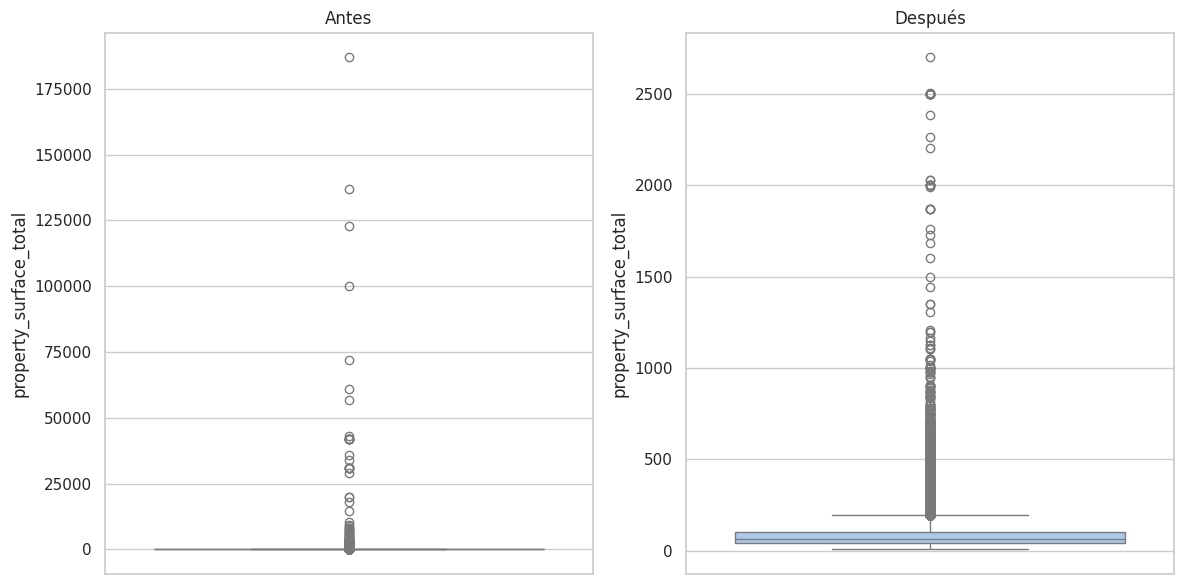

In [444]:
#Comparación del antes y después del analisis de la variable
plot_comparativo(ds_atipicos, ds_propiedades_filtradas, 'property_surface_total')

#### **Z-Score, normal y modificado**

In [445]:
def plot_z(df, variable):
  plt.hist(df[variable])
  plt.title("Histograma Z-Score "+ variable)
  plt.xlabel("Z-Score "+variable)
  plt.tight_layout()
  plt.show()
  return

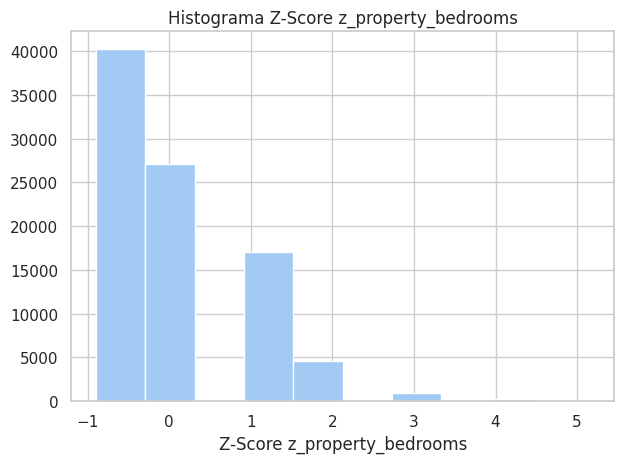

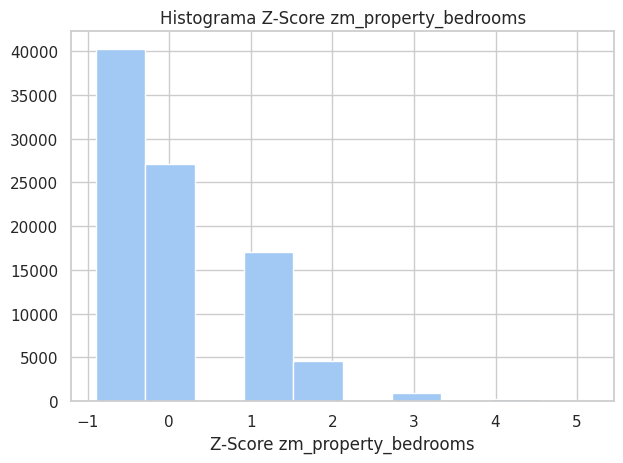

In [446]:
# Z Score property_bedrooms
ds_propiedades_filtradas['z_property_bedrooms'] = calculo_z_score(ds_propiedades_filtradas.property_bedrooms)
ds_propiedades_filtradas['zm_property_bedrooms'] = calculo_z_score(ds_propiedades_filtradas.property_bedrooms)

plot_z(ds_propiedades_filtradas, 'z_property_bedrooms')
plot_z(ds_propiedades_filtradas, 'zm_property_bedrooms')


In [447]:
ds_propiedades_filtradas[(ds_propiedades_filtradas['z_property_bedrooms'] > 3.5)]

id start_date    end_date    latitud   longitud  \
1040    hg7z9YXumyiWLjMo6ed2Eg== 2021-09-09  2022-03-09 -34.620750 -58.502759   
1108    emutcNxb0N+nIgC7KPMFow== 2021-09-09  2022-03-09 -34.620750 -58.502759   
1349    fwH71WfOi+vE4kdGMHfWNQ== 2021-09-09  2022-03-09 -34.620750 -58.502759   
1363    rfG2Nb7079oZOP8wAKuwXA== 2021-09-09  2022-03-09 -34.620750 -58.502759   
1769    g1hq2MUtnOPGU2VYSr2BWw== 2021-12-17  2022-01-27 -34.623581 -58.484051   
...                          ...        ...         ...        ...        ...   
457063  D2v8pvBdj56lpVuQPiSbQA== 2021-05-08  2021-05-20 -34.572554 -58.469842   
457064  rWpwKlxzNHvQYcrs+sBijQ== 2021-05-08  2021-05-20 -34.572554 -58.469842   
457366  addYhPIIGDmKeww0LFYSTg== 2021-05-08  2021-06-05 -34.631404 -58.403266   
457782  zThHFYUg/ZODnN9ekjwgFg== 2021-05-08  2021-06-05 -34.581524 -58.403588   
458670  naEatqtTCG8ALXICib4ZxQ== 2021-01-05  2022-08-12 -34.577390 -58.475421   

                place_l3 property_type  property_rooms  property_bedrooms  \
1040          Villa Luro          Casa             8.0                6.0   
1108        Monte Castro          Casa             8.0                6.0   
1349     Velez Sarsfield          Casa             8.0                6.0   
1363    Villa Santa Rita          Casa             8.0                6.0   
1769            Floresta          Casa            10.0                6.0   
...                  ...           ...             ...                ...   
457063          Belgrano          Casa             8.0                7.0   
457064          Belgrano          Casa             8.0                7.0   
457366  Parque Patricios          Casa             7.0                6.0   
457782           Palermo  Departamento            10.0                6.0   
458670     Villa Urquiza            PH             5.0                6.0   

        property_surface_total  property_surface_covered  property_price  \
1040                     201.0                     201.0        345000.0   
1108                     201.0                     201.0        345000.0   
1349                     201.0                     201.0        345000.0   
1363                     201.0                     201.0        345000.0   
1769                     330.0                     240.0        320000.0   
...                        ...                       ...             ...   
457063                   400.0                     400.0        920000.0   
457064                   400.0                     400.0        920000.0   
457366                   280.0                     230.0        426000.0   
457782                   520.0                     500.0       3300000.0   
458670                   125.0                     100.0        265000.0   

        z_property_bedrooms  zm_property_bedrooms  
1040               4.142225              4.142225  
1108               4.142225              4.142225  
1349               4.142225              4.142225  
1363               4.142225              4.142225  
1769               4.142225              4.142225  
...                     ...                   ...  
457063             5.150082              5.150082  
457064             5.150082              5.150082  
457366             4.142225              4.142225  
457782             4.142225              4.142225  
458670             4.142225              4.142225  

[343 rows x 14 columns]

In [448]:
ds_propiedades_filtradas[(ds_propiedades_filtradas['zm_property_bedrooms'] > 3.5)]

id start_date    end_date    latitud   longitud  \
1040    hg7z9YXumyiWLjMo6ed2Eg== 2021-09-09  2022-03-09 -34.620750 -58.502759   
1108    emutcNxb0N+nIgC7KPMFow== 2021-09-09  2022-03-09 -34.620750 -58.502759   
1349    fwH71WfOi+vE4kdGMHfWNQ== 2021-09-09  2022-03-09 -34.620750 -58.502759   
1363    rfG2Nb7079oZOP8wAKuwXA== 2021-09-09  2022-03-09 -34.620750 -58.502759   
1769    g1hq2MUtnOPGU2VYSr2BWw== 2021-12-17  2022-01-27 -34.623581 -58.484051   
...                          ...        ...         ...        ...        ...   
457063  D2v8pvBdj56lpVuQPiSbQA== 2021-05-08  2021-05-20 -34.572554 -58.469842   
457064  rWpwKlxzNHvQYcrs+sBijQ== 2021-05-08  2021-05-20 -34.572554 -58.469842   
457366  addYhPIIGDmKeww0LFYSTg== 2021-05-08  2021-06-05 -34.631404 -58.403266   
457782  zThHFYUg/ZODnN9ekjwgFg== 2021-05-08  2021-06-05 -34.581524 -58.403588   
458670  naEatqtTCG8ALXICib4ZxQ== 2021-01-05  2022-08-12 -34.577390 -58.475421   

                place_l3 property_type  property_rooms  property_bedrooms  \
1040          Villa Luro          Casa             8.0                6.0   
1108        Monte Castro          Casa             8.0                6.0   
1349     Velez Sarsfield          Casa             8.0                6.0   
1363    Villa Santa Rita          Casa             8.0                6.0   
1769            Floresta          Casa            10.0                6.0   
...                  ...           ...             ...                ...   
457063          Belgrano          Casa             8.0                7.0   
457064          Belgrano          Casa             8.0                7.0   
457366  Parque Patricios          Casa             7.0                6.0   
457782           Palermo  Departamento            10.0                6.0   
458670     Villa Urquiza            PH             5.0                6.0   

        property_surface_total  property_surface_covered  property_price  \
1040                     201.0                     201.0        345000.0   
1108                     201.0                     201.0        345000.0   
1349                     201.0                     201.0        345000.0   
1363                     201.0                     201.0        345000.0   
1769                     330.0                     240.0        320000.0   
...                        ...                       ...             ...   
457063                   400.0                     400.0        920000.0   
457064                   400.0                     400.0        920000.0   
457366                   280.0                     230.0        426000.0   
457782                   520.0                     500.0       3300000.0   
458670                   125.0                     100.0        265000.0   

        z_property_bedrooms  zm_property_bedrooms  
1040               4.142225              4.142225  
1108               4.142225              4.142225  
1349               4.142225              4.142225  
1363               4.142225              4.142225  
1769               4.142225              4.142225  
...                     ...                   ...  
457063             5.150082              5.150082  
457064             5.150082              5.150082  
457366             4.142225              4.142225  
457782             4.142225              4.142225  
458670             4.142225              4.142225  

[343 rows x 14 columns]

In [449]:
ds_propiedades_filtradas[(ds_propiedades_filtradas['z_property_bedrooms'] < -1)]

Empty DataFrame
Columns: [id, start_date, end_date, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_property_bedrooms, zm_property_bedrooms]
Index: []

In [450]:
ds_propiedades_filtradas[(ds_propiedades_filtradas['zm_property_bedrooms'] < -1)]

Empty DataFrame
Columns: [id, start_date, end_date, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_property_bedrooms, zm_property_bedrooms]
Index: []

Siguiendo el Z score, podemos ver que no existen outliers negativos, incluso usando un valor mínimo de -1. Usando la regla de oro de 3.5, podemos ver que si lo existen positivos y en una cantidad bastante significativa (270 registros). Vamos a ampliar ligeramente este factor.

In [451]:
ds_propiedades_filtradas[(ds_propiedades_filtradas['z_property_bedrooms'] > 5)]

id start_date    end_date    latitud   longitud  \
1800    xOxObQG9UHaTxLPYGOtK4w== 2021-12-17  2022-02-09 -34.616128 -58.394715   
6869    vtFpL0vRYrdtMyLuHCrhkQ== 2021-02-09  9999-12-31 -34.631952 -58.373878   
6871    FQeAbzRt++H2i0sij+/h7g== 2021-02-09  2021-02-11 -34.633226 -58.376409   
6873    +Omoo5u2h83gqiMY2Xi68A== 2021-02-09  2021-02-11 -34.633226 -58.376409   
14283   zX5pLInR+6XVkqbVZjdxzA== 2021-07-31  9999-12-31 -34.553144 -58.448612   
...                          ...        ...         ...        ...        ...   
448242  DtvwUdyN8mhShkCjkovMfg== 2021-12-16  2022-02-09 -34.635382 -58.355539   
449071  o2xzCwXzVpbeYQv+JDXvZg== 2021-12-16  2022-02-09 -34.621588 -58.455720   
449622  YxjhWpsXv+4ySaNcSmtSxw== 2021-12-16  2022-02-09 -34.546268 -58.459154   
457063  D2v8pvBdj56lpVuQPiSbQA== 2021-05-08  2021-05-20 -34.572554 -58.469842   
457064  rWpwKlxzNHvQYcrs+sBijQ== 2021-05-08  2021-05-20 -34.572554 -58.469842   

         place_l3 property_type  property_rooms  property_bedrooms  \
1800    Balvanera          Casa             8.0                7.0   
6869     Barracas          Casa             9.0                7.0   
6871     Barracas          Casa             9.0                7.0   
6873     Barracas          Casa             9.0                7.0   
14283    Belgrano          Casa             9.0                7.0   
...           ...           ...             ...                ...   
448242       Boca            PH             8.0                7.0   
449071     Flores            PH             8.0                7.0   
449622      Nuñez            PH             8.0                7.0   
457063   Belgrano          Casa             8.0                7.0   
457064   Belgrano          Casa             8.0                7.0   

        property_surface_total  property_surface_covered  property_price  \
1800                     164.0                     143.0        215000.0   
6869                     433.0                     350.0        550000.0   
6871                     360.0                     265.0        350000.0   
6873                     360.0                     265.0        350000.0   
14283                    750.0                     485.0       2250000.0   
...                        ...                       ...             ...   
448242                   395.0                     319.0        135000.0   
449071                   433.0                     230.0        590000.0   
449622                   246.0                     172.0        370000.0   
457063                   400.0                     400.0        920000.0   
457064                   400.0                     400.0        920000.0   

        z_property_bedrooms  zm_property_bedrooms  
1800               5.150082              5.150082  
6869               5.150082              5.150082  
6871               5.150082              5.150082  
6873               5.150082              5.150082  
14283              5.150082              5.150082  
...                     ...                   ...  
448242             5.150082              5.150082  
449071             5.150082              5.150082  
449622             5.150082              5.150082  
457063             5.150082              5.150082  
457064             5.150082              5.150082  

[113 rows x 14 columns]

No podemos sacar ninguna conclusión de los registros, más allá de que solo tomando en cuenta esta variable son registros atípicos. Esperaremos al análisis multivariado para tomar decisiones al respecto de estos outliers.

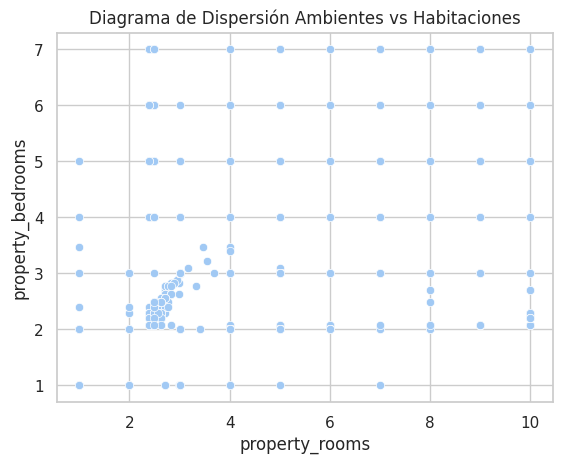

In [452]:
sns.scatterplot(y=ds_propiedades_filtradas["property_bedrooms"], x=ds_propiedades_filtradas["property_rooms"])
plt.title("Diagrama de Dispersión Ambientes vs Habitaciones")
plt.show()

En el analisis univariado solucionamos los outliers imposibles.  

In [453]:
# Caso: más habitaciones que ambientes
condition= (ds_propiedades_filtradas['property_rooms'] < ds_propiedades_filtradas['property_bedrooms'])
ds_propiedades_filtradas[condition]

id start_date    end_date    latitud   longitud  \
2516    uKy3ZC5YQ9kPZ1ztj7CKjw== 2021-12-17  2022-02-09 -34.557573 -58.459926   
3028    epPD4VV0HDOb5M1cNSTFEw== 2021-02-20  2021-03-01 -34.640603 -58.417313   
4928    69j280NshNyMCYcFqsmhlw== 2021-09-20  2022-01-27 -34.645031 -58.373672   
8807    S6CVXlEwTDGtHFSLeGFJuQ== 2021-05-18  2021-05-18 -34.632276 -58.433577   
9491    ybK3GgBY+bzoeAA+YONVcQ== 2021-05-18  2021-06-05 -34.580919 -58.430717   
...                          ...        ...         ...        ...        ...   
451218  7krE2YAxkwyebVtlLkuFcA== 2021-12-16  2022-01-27 -34.557917 -58.459907   
452275  DzALh3DQ7Dp1VmfhkZvL4w== 2021-12-16  2022-02-09 -34.596921 -58.402560   
458670  naEatqtTCG8ALXICib4ZxQ== 2021-01-05  2022-08-12 -34.577390 -58.475421   
459345  tDk6Qv0vzIsLSAkJbV/O/Q== 2021-01-05  2021-06-24 -34.578661 -58.428397   
459594  Vb8DwDZfI4nCtVA93y+uZg== 2021-01-05  2021-04-20 -34.573595 -58.442591   

                place_l3 property_type  property_rooms  property_bedrooms  \
2516            Belgrano  Departamento        1.000000                2.0   
3028             Pompeya            PH        1.000000                2.0   
4928            Barracas  Departamento        1.000000                2.0   
8807    Parque Chacabuco          Casa        2.397895                6.0   
9491             Palermo  Departamento        1.000000                2.0   
...                  ...           ...             ...                ...   
451218          Belgrano  Departamento        1.000000                2.0   
452275          Recoleta  Departamento        4.000000                5.0   
458670     Villa Urquiza            PH        5.000000                6.0   
459345           Palermo  Departamento        2.000000                3.0   
459594          Belgrano  Departamento        1.000000                2.0   

        property_surface_total  property_surface_covered  property_price  \
2516                      51.0                      51.0        150000.0   
3028                      27.0                      22.0         53000.0   
4928                      43.0                      37.0         80000.0   
8807                     380.0                     350.0        330000.0   
9491                      97.0                      97.0        263000.0   
...                        ...                       ...             ...   
451218                    49.0                      45.0        136300.0   
452275                   108.0                     100.0        220000.0   
458670                   125.0                     100.0        265000.0   
459345                    82.0                      73.0        192000.0   
459594                    57.0                      53.0        170000.0   

        z_property_bedrooms  zm_property_bedrooms  
2516               0.110798              0.110798  
3028               0.110798              0.110798  
4928               0.110798              0.110798  
8807               4.142225              4.142225  
9491               0.110798              0.110798  
...                     ...                   ...  
451218             0.110798              0.110798  
452275             3.134369              3.134369  
458670             4.142225              4.142225  
459345             1.118655              1.118655  
459594             0.110798              0.110798  

[151 rows x 14 columns]

Tenemos 118 registros en los que el número de habitaciones es mayor que el de ambientes.

Varios de estos registros tienen valores irracionales para una habitación (2.397... en vez de números enteros) y podrían haber sido resultados de imputaciones y transformaciones anteriores.
Una solución podría ser copiar los valores de habitaciones a ambientes, pero previniendo que algunos puedan ser valores verdaderos y para que no se pierdan, probaremos invirtiendo las columnas de estos casos en específico ya que muchos tienen sentido de esa manera (casas con 6 ambientes y 4 habitaciones, departamentos de 2 ambientes y una habitación, por dar unos ejemplos). Es un cambio riesgoso pero se tendrá en cuenta por si llegara a haber discrepancias en resultados futuros.

In [454]:
# Creamos una máscara booleana para nuestra condición
mask = ds_propiedades_filtradas['property_rooms'] < ds_propiedades_filtradas['property_bedrooms']

# Invertimos los valores usando la máscara
ds_propiedades_filtradas.loc[mask, ['property_rooms', 'property_bedrooms']] = ds_propiedades_filtradas.loc[mask, ['property_bedrooms', 'property_rooms']].values


In [455]:
ds_propiedades_filtradas[(ds_propiedades_filtradas['z_property_bedrooms'] > 3.5)]

id start_date    end_date    latitud   longitud  \
1040    hg7z9YXumyiWLjMo6ed2Eg== 2021-09-09  2022-03-09 -34.620750 -58.502759   
1108    emutcNxb0N+nIgC7KPMFow== 2021-09-09  2022-03-09 -34.620750 -58.502759   
1349    fwH71WfOi+vE4kdGMHfWNQ== 2021-09-09  2022-03-09 -34.620750 -58.502759   
1363    rfG2Nb7079oZOP8wAKuwXA== 2021-09-09  2022-03-09 -34.620750 -58.502759   
1769    g1hq2MUtnOPGU2VYSr2BWw== 2021-12-17  2022-01-27 -34.623581 -58.484051   
...                          ...        ...         ...        ...        ...   
457063  D2v8pvBdj56lpVuQPiSbQA== 2021-05-08  2021-05-20 -34.572554 -58.469842   
457064  rWpwKlxzNHvQYcrs+sBijQ== 2021-05-08  2021-05-20 -34.572554 -58.469842   
457366  addYhPIIGDmKeww0LFYSTg== 2021-05-08  2021-06-05 -34.631404 -58.403266   
457782  zThHFYUg/ZODnN9ekjwgFg== 2021-05-08  2021-06-05 -34.581524 -58.403588   
458670  naEatqtTCG8ALXICib4ZxQ== 2021-01-05  2022-08-12 -34.577390 -58.475421   

                place_l3 property_type  property_rooms  property_bedrooms  \
1040          Villa Luro          Casa             8.0                6.0   
1108        Monte Castro          Casa             8.0                6.0   
1349     Velez Sarsfield          Casa             8.0                6.0   
1363    Villa Santa Rita          Casa             8.0                6.0   
1769            Floresta          Casa            10.0                6.0   
...                  ...           ...             ...                ...   
457063          Belgrano          Casa             8.0                7.0   
457064          Belgrano          Casa             8.0                7.0   
457366  Parque Patricios          Casa             7.0                6.0   
457782           Palermo  Departamento            10.0                6.0   
458670     Villa Urquiza            PH             6.0                5.0   

        property_surface_total  property_surface_covered  property_price  \
1040                     201.0                     201.0        345000.0   
1108                     201.0                     201.0        345000.0   
1349                     201.0                     201.0        345000.0   
1363                     201.0                     201.0        345000.0   
1769                     330.0                     240.0        320000.0   
...                        ...                       ...             ...   
457063                   400.0                     400.0        920000.0   
457064                   400.0                     400.0        920000.0   
457366                   280.0                     230.0        426000.0   
457782                   520.0                     500.0       3300000.0   
458670                   125.0                     100.0        265000.0   

        z_property_bedrooms  zm_property_bedrooms  
1040               4.142225              4.142225  
1108               4.142225              4.142225  
1349               4.142225              4.142225  
1363               4.142225              4.142225  
1769               4.142225              4.142225  
...                     ...                   ...  
457063             5.150082              5.150082  
457064             5.150082              5.150082  
457366             4.142225              4.142225  
457782             4.142225              4.142225  
458670             4.142225              4.142225  

[343 rows x 14 columns]

270 registros permanecen como outliers.

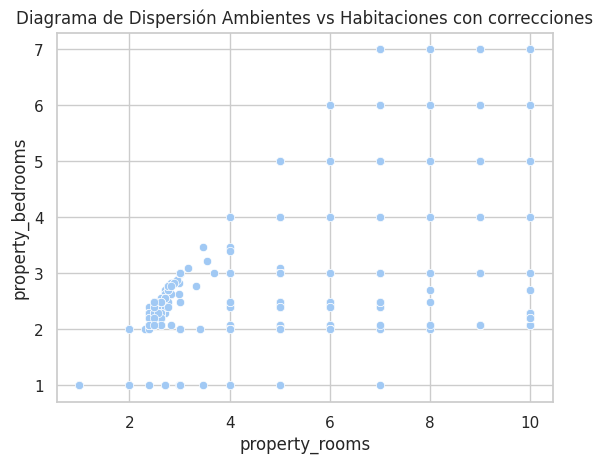

In [456]:
# Visualización después de correcciones
sns.scatterplot(y=ds_propiedades_filtradas["property_bedrooms"], x=ds_propiedades_filtradas["property_rooms"])
plt.title("Diagrama de Dispersión Ambientes vs Habitaciones con correcciones")
plt.show()


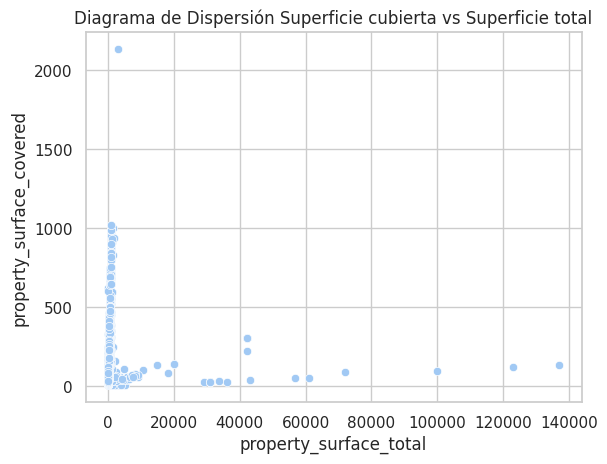

In [457]:
sns.scatterplot(y=ds_propiedades_filtradas["property_surface_covered"], x=df["property_surface_total"])
plt.title("Diagrama de Dispersión Superficie cubierta vs Superficie total")
plt.show()

En primer lugar, vamos a distinguir los casos triviales donde la superficie cubierta es mayor a la superficie total.

In [458]:
# Casos donde la superficie cubierta es mayor a la total
ds_propiedades_filtradas[(ds_propiedades_filtradas['property_surface_total'] < ds_propiedades_filtradas['property_surface_covered'])]

id start_date    end_date    latitud   longitud  \
2790    hiErLhEcdvs7P+Y7GL3gTA== 2021-12-17  2022-01-27 -34.606366 -58.383480   
3955    Y3aGeTNWObQhMWdun6H5vQ== 2021-02-20  2022-01-05 -34.602086 -58.372614   
4932    HiBo6YWOuGY7yXDp8EpHBg== 2021-09-20  2021-10-30 -34.561491 -58.458549   
5056    dCcOQCC1m9f0ZHJtzc3N9A== 2021-09-20  2022-01-05 -34.614628 -58.437881   
5094    +IhmmO82TXXNbyRzyQASZg== 2021-09-20  2022-03-09 -34.579076 -58.450279   
...                          ...        ...         ...        ...        ...   
459364  9JgJiB0/l+tDl+vIdXdGaQ== 2021-01-05  2021-04-20 -34.569453 -58.433300   
459588  cu+23paFW640od7H6C2iHg== 2021-01-05  2021-01-06 -34.574650 -58.437659   
459842  Y4PuRUaAW17tsLGwFTukhA== 2021-01-05  2021-01-09 -34.628397 -58.437706   
459847  zMligt7YdiayCjrfqlmbfg== 2021-01-05  2021-01-09 -34.628247 -58.437696   
459849  +9w0GBZbuObF0Nw6AAtu2Q== 2021-01-05  2021-01-09 -34.628282 -58.437803   

           place_l3 property_type  property_rooms  property_bedrooms  \
2790    San Nicolás  Departamento             7.0                6.0   
3955    San Nicolás  Departamento             3.0                2.0   
4932       Belgrano  Departamento             4.0                3.0   
5056      Caballito  Departamento             4.0                3.0   
5094     Colegiales  Departamento             2.0                1.0   
...             ...           ...             ...                ...   
459364      Palermo  Departamento             3.0                2.0   
459588     Belgrano  Departamento             3.0                2.0   
459842    Caballito  Departamento             3.0                2.0   
459847    Caballito  Departamento             4.0                3.0   
459849    Caballito  Departamento             3.0                2.0   

        property_surface_total  property_surface_covered  property_price  \
2790                178.000000                    203.00        200000.0   
3955                 52.000000                     53.00         79500.0   
4932                 80.000000                     85.00        230000.0   
5056                 70.000000                     78.00        215000.0   
5094                 19.000000                     40.00         95000.0   
...                        ...                       ...             ...   
459364               35.000000                     64.00        270000.0   
459588                8.796188                     60.00        210000.0   
459842                9.004054                     64.72        203550.0   
459847                9.803446                     85.68        324558.0   
459849                8.951570                     59.70        167894.0   

        z_property_bedrooms  zm_property_bedrooms  
2790               4.142225              4.142225  
3955               0.110798              0.110798  
4932               1.118655              1.118655  
5056               1.118655              1.118655  
5094              -0.897058             -0.897058  
...                     ...                   ...  
459364             0.110798              0.110798  
459588             0.110798              0.110798  
459842             0.110798              0.110798  
459847             1.118655              1.118655  
459849             0.110798              0.110798  

[495 rows x 14 columns]

Vamos a combinar algunas de las técnicas que ya realizamos anteriormente.

In [459]:
# Creamos una máscara booleana para nuestra condición
mask = ds_propiedades_filtradas['property_surface_total'] < ds_propiedades_filtradas['property_surface_covered']

# Invertimos los valores usando la máscara
ds_propiedades_filtradas.loc[mask, ['property_surface_total', 'property_surface_covered']] = ds_propiedades_filtradas.loc[mask, ['property_surface_covered', 'property_surface_covered']].values

Aquí se podría revisar que no haya valores como superficies cubiertas muy pequeñas, pero por ahora se mantendrá así a menos que se determine que sigue habiendo demasiado ruido en nuestro ds.

### Análisis multivariado

#### **Isolation forest**

In [460]:
# Cargo los datos
X = ds_propiedades_filtradas.copy()
X.head()

id start_date    end_date    latitud   longitud  \
42  d3Z0MblSb2IMBoOBMGJEEQ== 2021-09-09  2021-09-26 -34.637319 -58.361124   
43  rL7qPkQnomsMGu2ViS3sBw== 2021-09-09  2021-09-28 -34.628647 -58.361871   
49  vuX/ccLAMVml4qWRFcOJUA== 2021-09-09  2022-01-05 -34.610027 -58.401934   
51  ZTtSCeqZ3HUgf5jjwEzRcw== 2021-09-09  2022-03-09 -34.631621 -58.416825   
53  3XhGN1xIqtzxywrDb3vC/w== 2021-09-09  2022-01-27 -34.623886 -58.412746   

       place_l3 property_type  property_rooms  property_bedrooms  \
42  San Nicolás  Departamento             3.0                2.0   
43     Belgrano  Departamento             4.0                3.0   
49         Once  Departamento             4.0                2.0   
51        Boedo            PH             4.0                2.0   
53        Boedo            PH             2.0                1.0   

    property_surface_total  property_surface_covered  property_price  \
42                    58.0                      55.0         82900.0   
43                    70.0                      70.0         99000.0   
49                   131.0                     104.0        146000.0   
51                   104.0                      73.0        250000.0   
53                    61.0                      46.0        100000.0   

    z_property_bedrooms  zm_property_bedrooms  
42             0.110798              0.110798  
43             1.118655              1.118655  
49             0.110798              0.110798  
51             0.110798              0.110798  
53            -0.897058             -0.897058

In [461]:
# Limpio el dataset
X.drop(columns=['latitud', 'longitud', 'end_date', 'start_date'], inplace=True)
X.head()

id     place_l3 property_type  property_rooms  \
42  d3Z0MblSb2IMBoOBMGJEEQ==  San Nicolás  Departamento             3.0   
43  rL7qPkQnomsMGu2ViS3sBw==     Belgrano  Departamento             4.0   
49  vuX/ccLAMVml4qWRFcOJUA==         Once  Departamento             4.0   
51  ZTtSCeqZ3HUgf5jjwEzRcw==        Boedo            PH             4.0   
53  3XhGN1xIqtzxywrDb3vC/w==        Boedo            PH             2.0   

    property_bedrooms  property_surface_total  property_surface_covered  \
42                2.0                    58.0                      55.0   
43                3.0                    70.0                      70.0   
49                2.0                   131.0                     104.0   
51                2.0                   104.0                      73.0   
53                1.0                    61.0                      46.0   

    property_price  z_property_bedrooms  zm_property_bedrooms  
42         82900.0             0.110798              0.110798  
43         99000.0             1.118655              1.118655  
49        146000.0             0.110798              0.110798  
51        250000.0             0.110798              0.110798  
53        100000.0            -0.897058             -0.897058

In [462]:
# Label encoding de los nombres de las ciudades y el tipo de propiedad

label_encoder = LabelEncoder()
X['place_encoded'] = label_encoder.fit_transform(X['place_l3'])
ds_propiedades_filtradas['place_encoded'] = label_encoder.fit_transform(X['place_l3'])
X['type_encoded'] = label_encoder.fit_transform(X['property_type'])
ds_propiedades_filtradas['type_encoded'] = label_encoder.fit_transform(X['property_type'])

X

id              place_l3 property_type  \
42      d3Z0MblSb2IMBoOBMGJEEQ==           San Nicolás  Departamento   
43      rL7qPkQnomsMGu2ViS3sBw==              Belgrano  Departamento   
49      vuX/ccLAMVml4qWRFcOJUA==                  Once  Departamento   
51      ZTtSCeqZ3HUgf5jjwEzRcw==                 Boedo            PH   
53      3XhGN1xIqtzxywrDb3vC/w==                 Boedo            PH   
...                          ...                   ...           ...   
460072  v4f5Un9jO7hsD02MWLkKBQ==      Villa del Parque  Departamento   
460073  Aq/Z+XyS8FHbOOxed4xtTw==      Villa del Parque  Departamento   
460074  Rmamz8v4Wkh5xF7PA59Jqw==      Villa del Parque  Departamento   
460075  7yl8Dfx5wobH21YdMU+Kgg==      Villa del Parque  Departamento   
460090  9OVDfhoDvkY4rr/SX0ggVw==  Centro / Microcentro  Departamento   

        property_rooms  property_bedrooms  property_surface_total  \
42                 3.0                2.0                    58.0   
43                 4.0                3.0                    70.0   
49                 4.0                2.0                   131.0   
51                 4.0                2.0                   104.0   
53                 2.0                1.0                    61.0   
...                ...                ...                     ...   
460072             4.0                3.0                   130.0   
460073             3.0                2.0                    68.0   
460074             1.0                1.0                    51.0   
460075             1.0                1.0                    37.0   
460090             2.0                1.0                    84.0   

        property_surface_covered  property_price  z_property_bedrooms  \
42                          55.0         82900.0             0.110798   
43                          70.0         99000.0             1.118655   
49                         104.0        146000.0             0.110798   
51                          73.0        250000.0             0.110798   
53                          46.0        100000.0            -0.897058   
...                          ...             ...                  ...   
460072                     100.0        220000.0             1.118655   
460073                      60.0        161000.0             0.110798   
460074                      30.0         75500.0            -0.897058   
460075                      31.0         74500.0            -0.897058   
460090                      84.0        135000.0            -0.897058   

        zm_property_bedrooms  place_encoded  type_encoded  
42                  0.110798             39             1  
43                  1.118655              6             1  
49                  0.110798             25             1  
51                  0.110798              8             2  
53                 -0.897058              8             2  
...                      ...            ...           ...  
460072              1.118655             56             1  
460073              0.110798             56             1  
460074             -0.897058             56             1  
460075             -0.897058             56             1  
460090             -0.897058             11             1  

[90270 rows x 12 columns]

In [463]:
X.drop(columns=['place_l3', 'property_type', 'id'], inplace=True)

In [464]:
# Creo el modelo
iforest = IsolationForest(
    n_estimators=100,
    max_samples="auto",
    contamination=0.05,
    max_features=5,
    bootstrap=False,
    n_jobs=-1,
    random_state=1,
)

# Entreno y genero la predicción
pred = iforest.fit_predict(X)

# Almaceno scores y etiquetas
X["scores"] = iforest.decision_function(X)
X["outlier_label"] = pred

# Observaciones anómalas
X[X.outlier_label == -1]

property_rooms  property_bedrooms  property_surface_total  \
58                10.0           2.302585                   394.0   
410                5.0           4.000000                   400.0   
411                5.0           4.000000                   400.0   
438                4.0           3.000000                   282.0   
448                5.0           4.000000                   304.0   
...                ...                ...                     ...   
459752             7.0           4.000000                   248.0   
459755             8.0           5.000000                   431.0   
459764             8.0           4.000000                   383.0   
459813             6.0           5.000000                   143.0   
459997             4.0           2.000000                   315.0   

        property_surface_covered  property_price  z_property_bedrooms  \
58                         244.0        500000.0             0.415761   
410                        314.0       2700000.0             2.126512   
411                        314.0       2700000.0             2.126512   
438                        256.0       2250000.0             1.118655   
448                        294.0       1200000.0             2.126512   
...                          ...             ...                  ...   
459752                     248.0        790000.0             2.126512   
459755                     415.0       2800000.0             3.134369   
459764                     383.0       1700000.0             2.126512   
459813                     143.0        198000.0             3.134369   
459997                     180.0       2200000.0             0.110798   

        zm_property_bedrooms  place_encoded  type_encoded    scores  \
58                  0.415761              8             0 -0.073037   
410                 2.126512             26             1 -0.080041   
411                 2.126512             26             1 -0.080041   
438                 1.118655             26             1 -0.006782   
448                 2.126512             26             1 -0.004440   
...                      ...            ...           ...       ...   
459752              2.126512             35             1 -0.002443   
459755              3.134369             35             1 -0.170448   
459764              2.126512             35             1 -0.086232   
459813              3.134369              3             1 -0.045034   
459997              0.110798             34             1 -0.055507   

        outlier_label  
58                 -1  
410                -1  
411                -1  
438                -1  
448                -1  
...               ...  
459752             -1  
459755             -1  
459764             -1  
459813             -1  
459997             -1  

[4514 rows x 11 columns]

In [465]:
# Cantidad de obs. anómalas
X.outlier_label.value_counts()

outlier_label
 1    85756
-1     4514
Name: count, dtype: int64

Obtuvimos 3610 anomalías. Visualizamos.

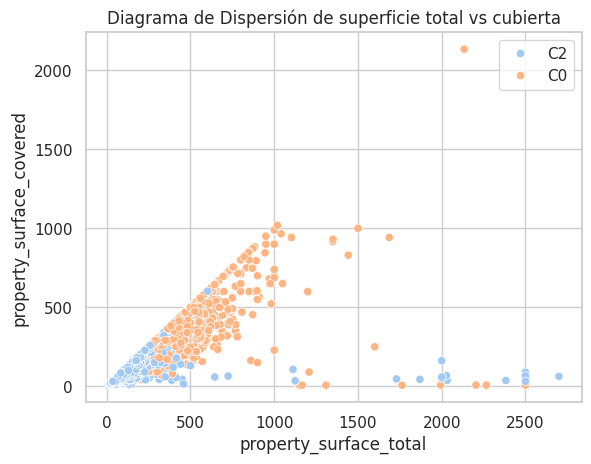

In [466]:
# Grafico dispersograma
color = [f"C{n+1}" for n in (X["outlier_label"].values)]

sns.scatterplot(x=X["property_surface_total"], y=X["property_surface_covered"], hue=color)
plt.title("Diagrama de Dispersión de superficie total vs cubierta")
plt.show()

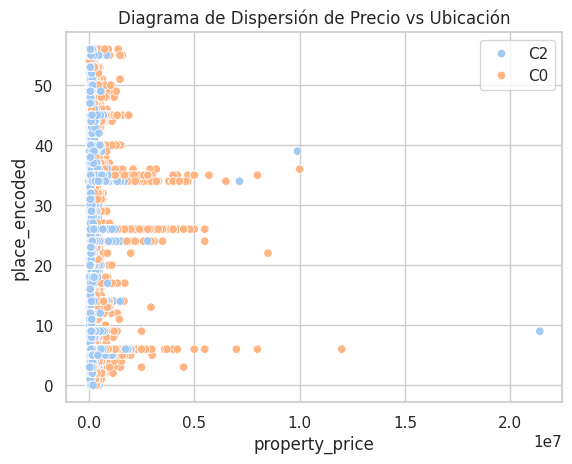

In [467]:
sns.scatterplot(x=X["property_price"], y=X["place_encoded"], hue=color)
plt.title("Diagrama de Dispersión de Precio vs Ubicación")
plt.show()

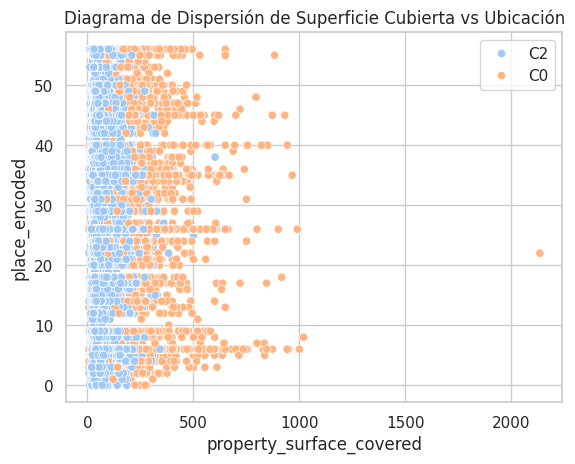

In [468]:
sns.scatterplot(x=X["property_surface_covered"], y=X["place_encoded"], hue=color)
plt.title("Diagrama de Dispersión de Superficie Cubierta vs Ubicación")
plt.show()

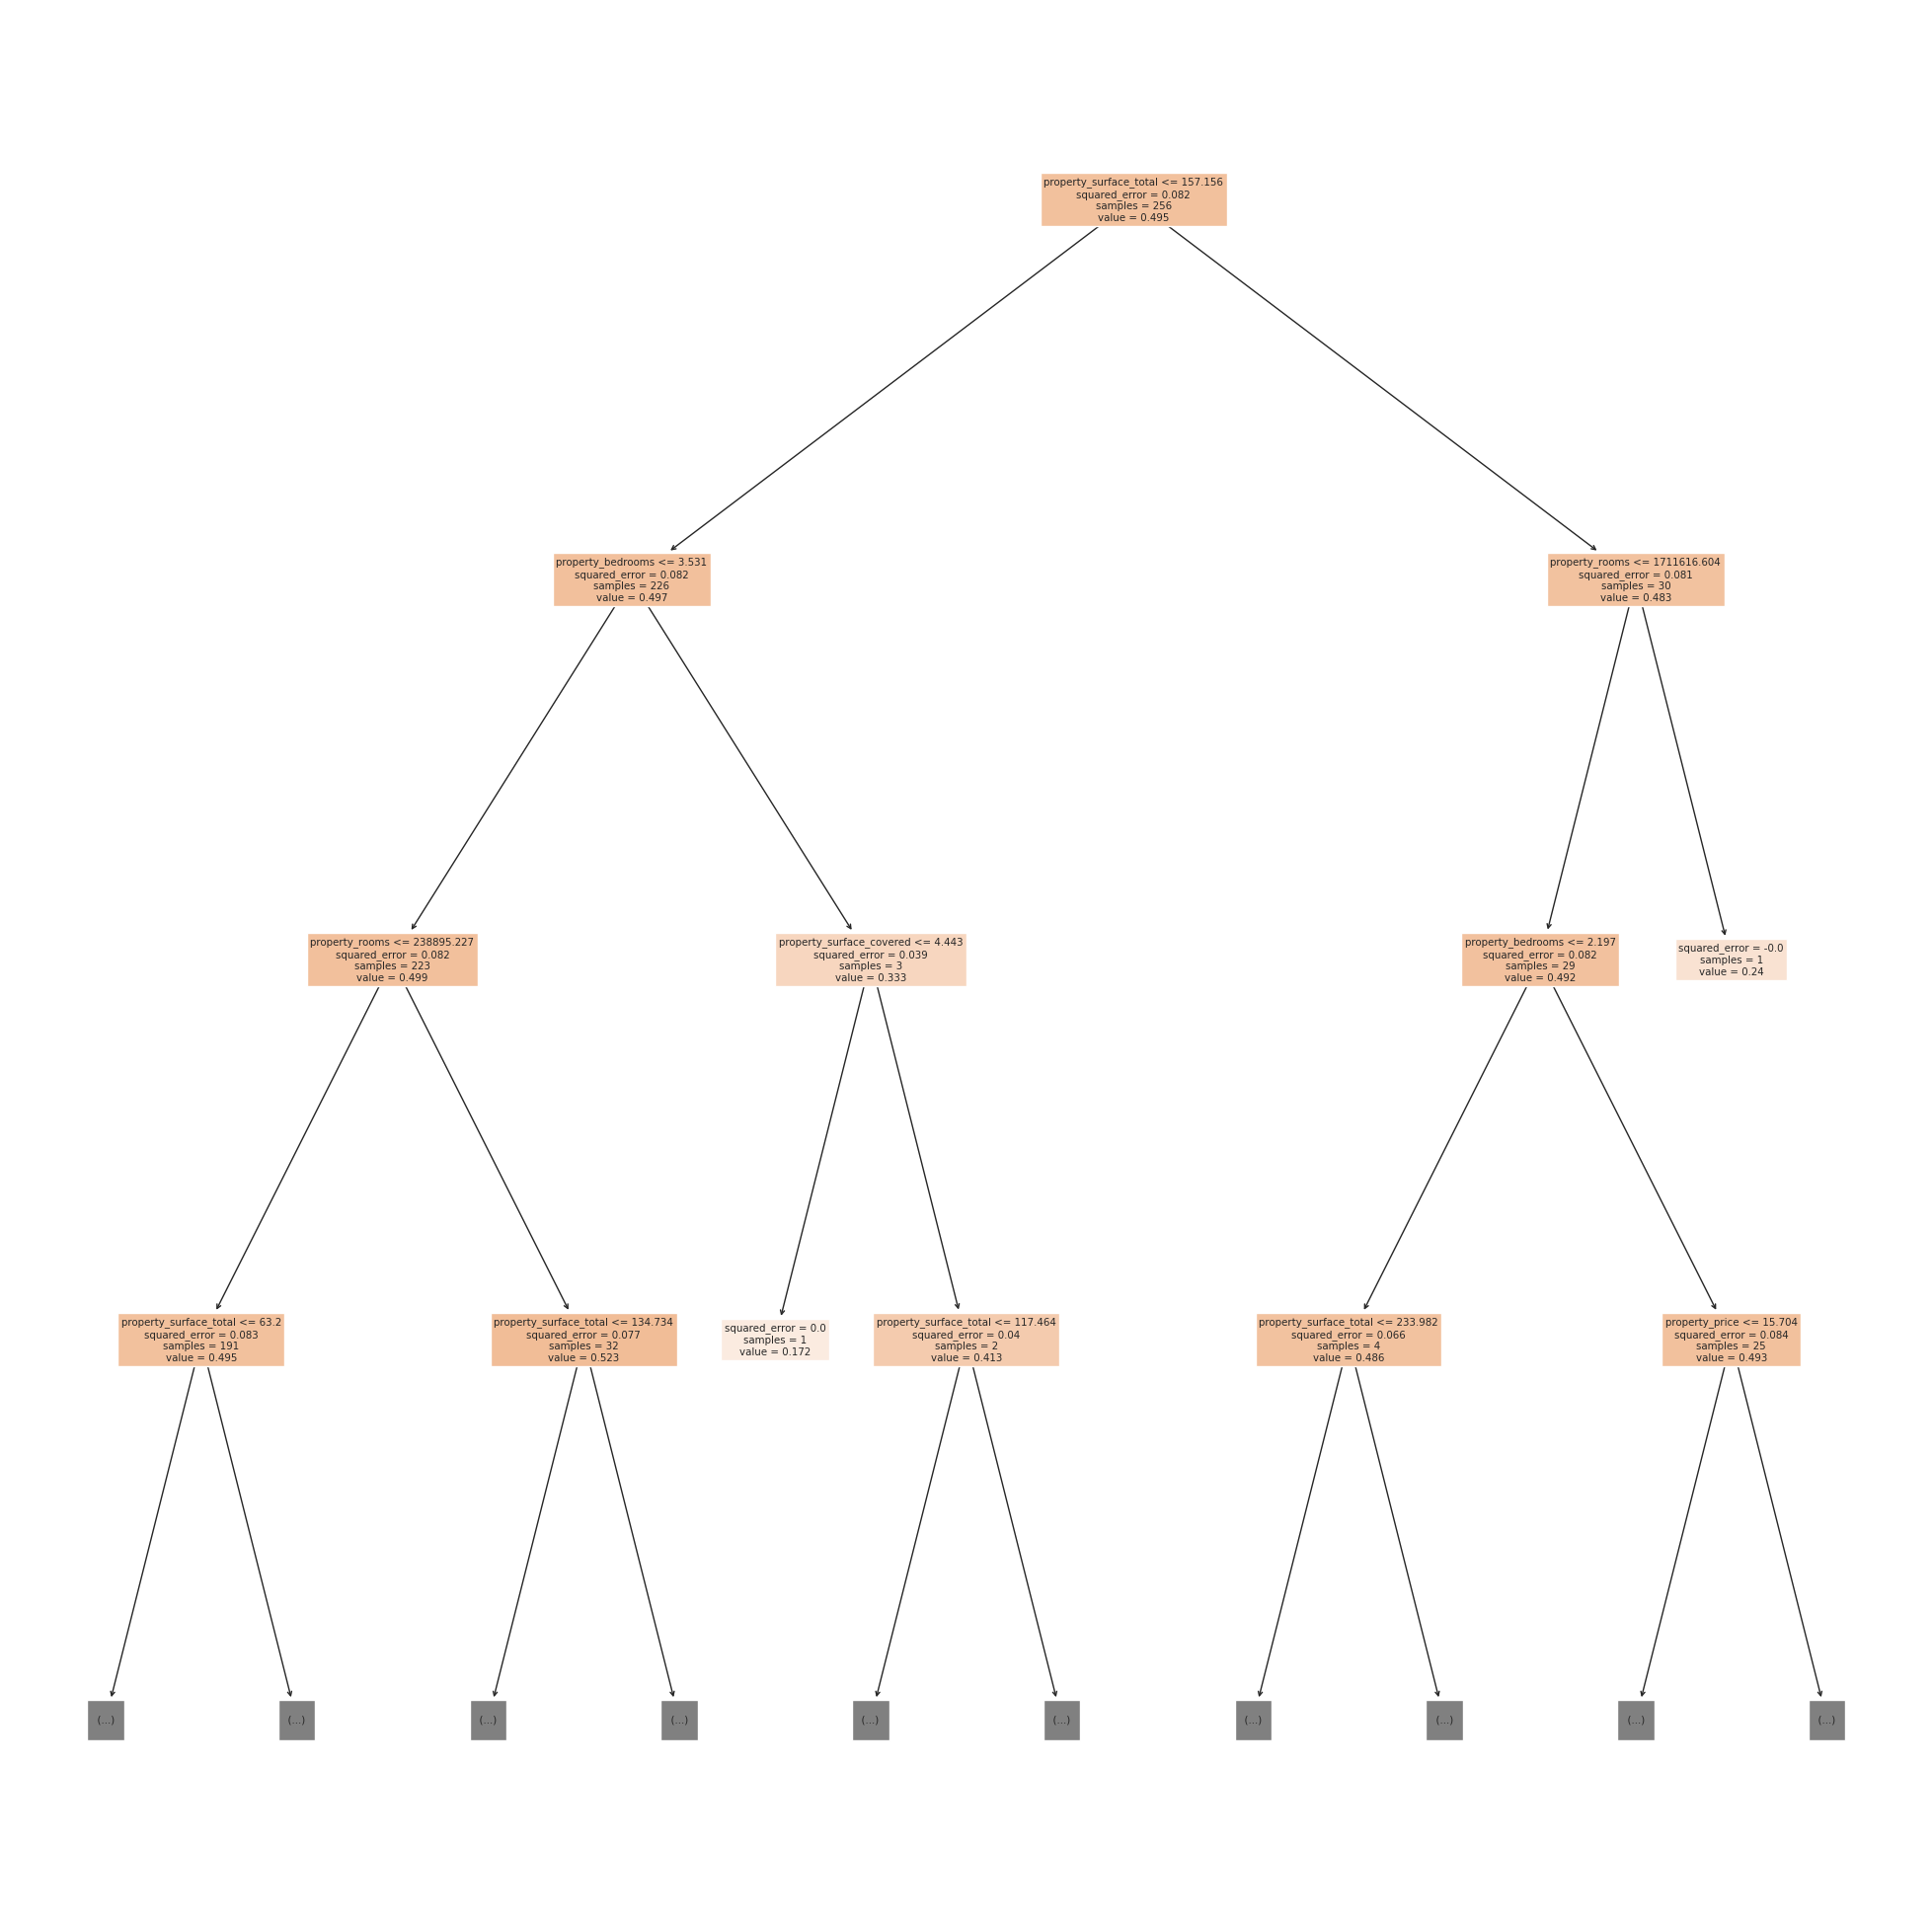

In [469]:
# Selecciono el árbol
estimator = iforest.estimators_[5]

# Grafico
plt.figure(figsize=(25, 25))
sk.tree.plot_tree(estimator, feature_names=X.columns, filled=True, max_depth=3)
plt.show()

Revisando las anomalías y viendo los scatterplot, en su mayoría parecerían seguir las tendencias de los registros no considerados anómalos pero con valores levemente inferiores/superiores a la mediana (podría analizarse si esto es a causa de los barrios tal como se planteo anteriormente). Parecen ser anomalías genuinas y decidimos mantenerlas por contexto.

Existe un riesgo inherente en mantener los datos como estan pero de detectarse en el entrenamiento que los resultados no son los indicados se revisará esta sección.

#### **LOF**

Vamos a intentar detectar outliers multivariados usando LOF.

In [470]:
ds_lof = ds_propiedades_filtradas.copy()

In [471]:
ds_lof.head()

id start_date    end_date    latitud   longitud  \
42  d3Z0MblSb2IMBoOBMGJEEQ== 2021-09-09  2021-09-26 -34.637319 -58.361124   
43  rL7qPkQnomsMGu2ViS3sBw== 2021-09-09  2021-09-28 -34.628647 -58.361871   
49  vuX/ccLAMVml4qWRFcOJUA== 2021-09-09  2022-01-05 -34.610027 -58.401934   
51  ZTtSCeqZ3HUgf5jjwEzRcw== 2021-09-09  2022-03-09 -34.631621 -58.416825   
53  3XhGN1xIqtzxywrDb3vC/w== 2021-09-09  2022-01-27 -34.623886 -58.412746   

       place_l3 property_type  property_rooms  property_bedrooms  \
42  San Nicolás  Departamento             3.0                2.0   
43     Belgrano  Departamento             4.0                3.0   
49         Once  Departamento             4.0                2.0   
51        Boedo            PH             4.0                2.0   
53        Boedo            PH             2.0                1.0   

    property_surface_total  property_surface_covered  property_price  \
42                    58.0                      55.0         82900.0   
43                    70.0                      70.0         99000.0   
49                   131.0                     104.0        146000.0   
51                   104.0                      73.0        250000.0   
53                    61.0                      46.0        100000.0   

    z_property_bedrooms  zm_property_bedrooms  place_encoded  type_encoded  
42             0.110798              0.110798             39             1  
43             1.118655              1.118655              6             1  
49             0.110798              0.110798             25             1  
51             0.110798              0.110798              8             2  
53            -0.897058             -0.897058              8             2

In [472]:
def lof(df, var1, var2, name):
  radius = calculo_lof(df, var1, var2, name)
  grafico_lof(df, var1, var2, name, radius)
  return


def calculo_lof(df, var1, var2, name):
  # CÁLCULO
  # Conjunto de entrenamiento
  X = df[[var1, var2]].values

  # Creo el clasificador
  clf = LocalOutlierFactor(n_neighbors=30)

  # Genero prediccion
  y_pred = clf.fit_predict(X)

  # Guardo los scores
  df[name] = clf.negative_outlier_factor_

  #VISUALIZACION
  # Calculo radio para plotear score
  radius = (df[name].max() - df[name]) / (df[name].max() - df[name].min())
  return radius


def grafico_lof(df, var1, var2, name, radius):
  # Grafico LOF
  plt.figure(figsize=(10, 10))
  plt.title("Local Outlier Factor (LOF)" + name)
  plt.scatter(
      df[var1].values,
      df[var2].values,
      edgecolor="grey",
      s=30,
      label="datos",
      facecolors="none",
  )
  plt.scatter(
      df[var1].values,
      df[var2].values,
      s=1300 * radius,
      edgecolors="red",
      facecolors="none",
      label="Outlier scores",
  )
  legend = plt.legend(loc="upper left")
  legend.legendHandles[0]._sizes = [10]
  legend.legendHandles[1]._sizes = [20]
  plt.show()
  return

Nota: Para los lof según tipo de propiedad reducimos el valor de n_neighbors a 10 ya que no se analiza el dataset entero.

In [473]:
def lof_segun_tipo(df, var1, var2, name):

  tipos = ["Casa", "Departamento", "PH"]

  # Subplots
  fig, axs = plt.subplots(1, 3, figsize=(18, 6))

  for i, tipo in enumerate(tipos):
      filtered_data = df[df['property_type'] == tipo]

      # Check if there's any data for this property type
      if not filtered_data.empty:
          # CÁLCULO
          X = filtered_data[[var1, var2]].values
          clf = LocalOutlierFactor(n_neighbors=10)
          y_pred = clf.fit_predict(X)
          score = name + "_" + tipo
          filtered_data[score] = clf.negative_outlier_factor_

          #VISUALIZACION
          # Calculo radio para plotear score

          radius = (filtered_data[score].max() - filtered_data[score]) / (filtered_data[score].max() - filtered_data[score].min())

          # Grafico LOF
          axs[i].scatter(
              filtered_data[var1].values,
              filtered_data[var2].values,
              edgecolor="grey",
              s=30,
              label="datos",
              facecolors="none",
          )
          axs[i].scatter(
              filtered_data[var1].values,
              filtered_data[var2].values,
              s=1300 * radius,
              edgecolors="red",
              facecolors="none",
              label="Outlier scores",
          )
          legend = axs[i].legend(loc="upper left")
          legend.legendHandles[0]._sizes = [10]
          legend.legendHandles[1]._sizes = [20]

          axs[i].set_title(f'{var1}, {var2} en {tipo}')
      else:
          axs[i].set_title(f'No data for {tipo}')


  plt.tight_layout()
  plt.show()
  return


##### Superficie cubierta vs superficie total

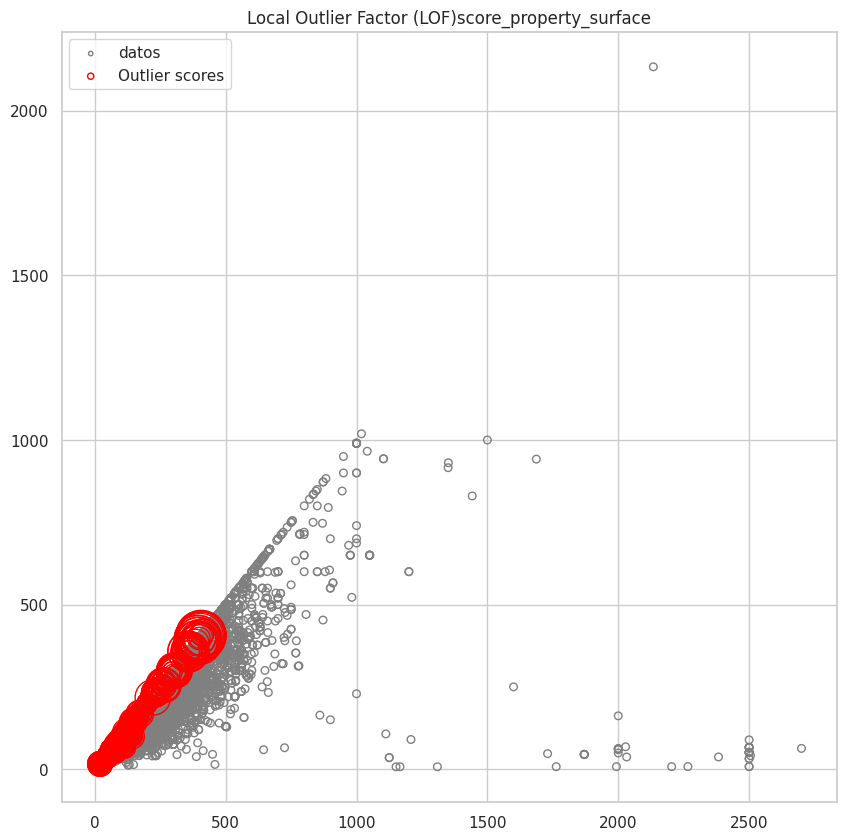

In [474]:
lof(ds_lof, 'property_surface_total', 'property_surface_covered', 'score_property_surface')

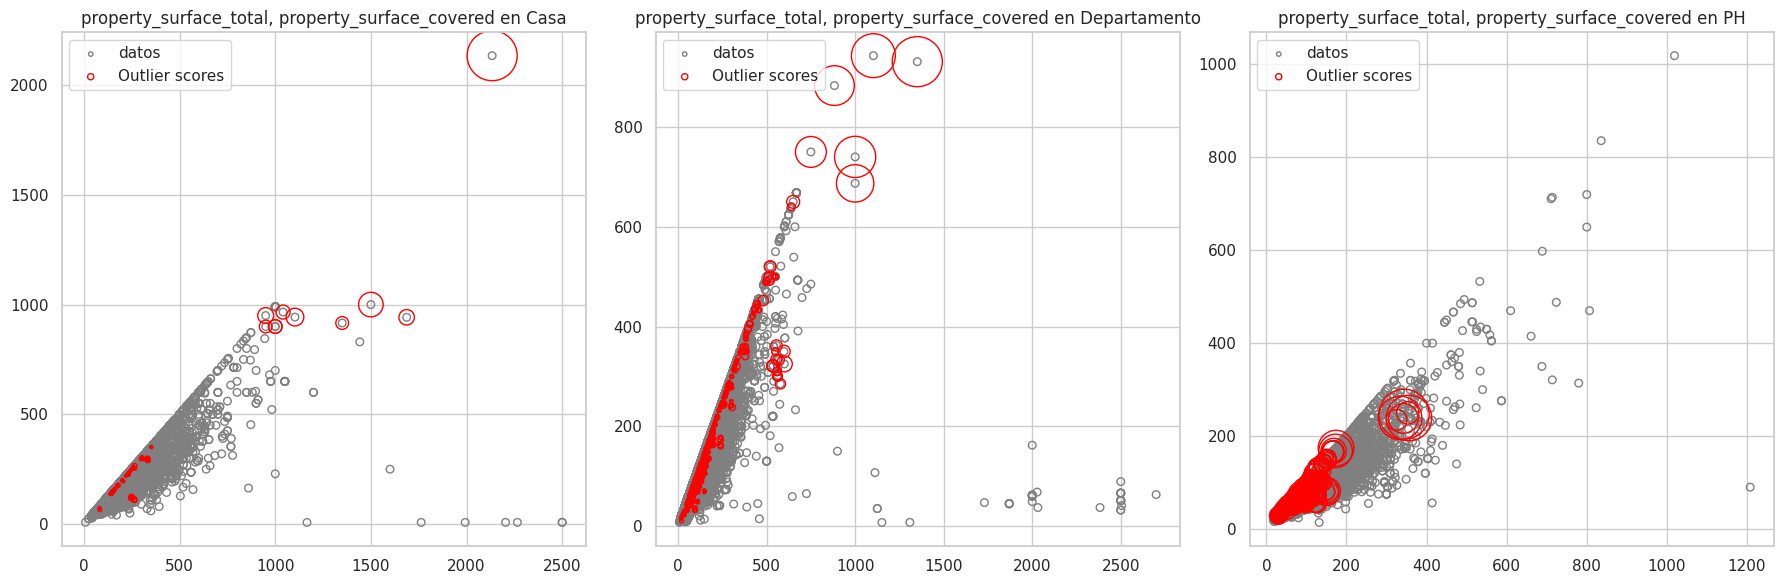

In [475]:
lof_segun_tipo(ds_lof, 'property_surface_total', 'property_surface_covered', 'score_property_surface')

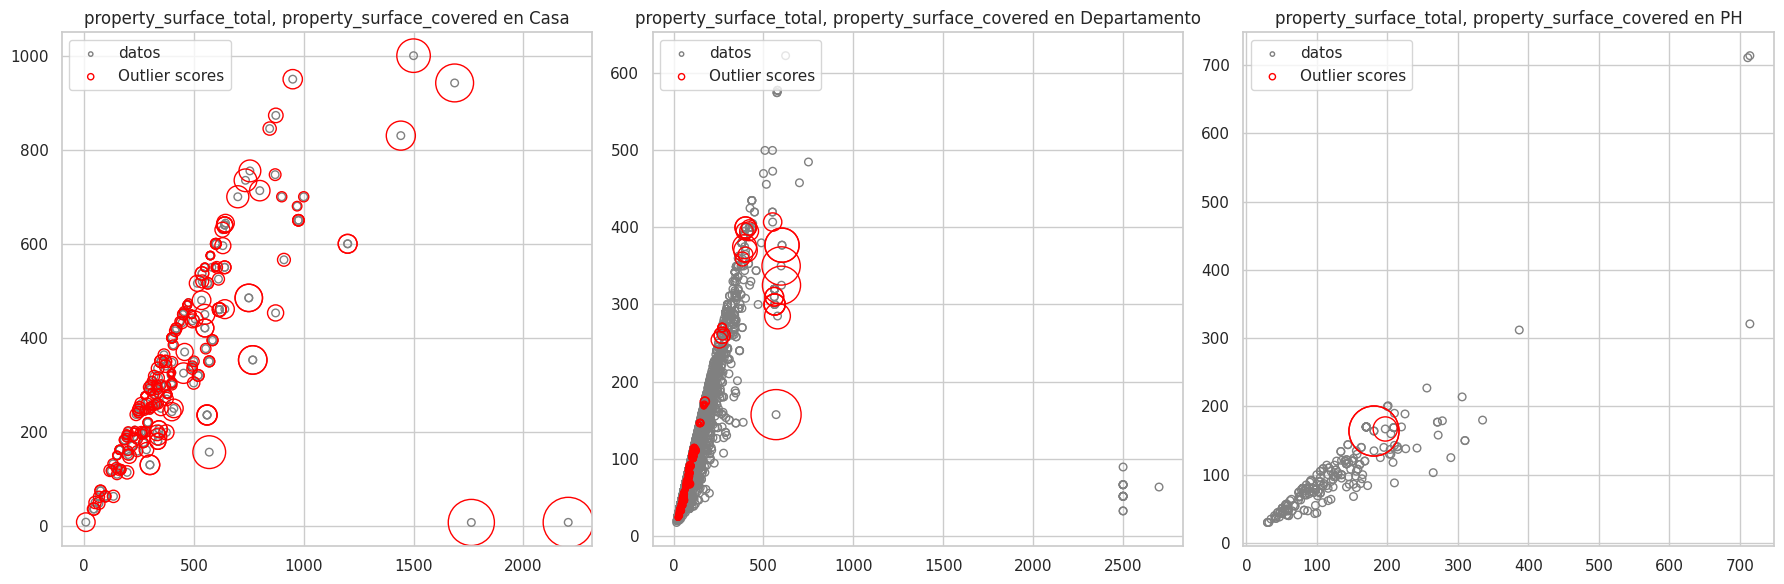

In [476]:
lof_segun_tipo(ds_lof[(ds_lof['place_l3'] == 'Belgrano')], 'property_surface_total', 'property_surface_covered', 'score_property_surface')

Vemos como ejemplo el lof según tipo del Barrio Belgrano. Las casas son consideradas outliers casi en tu totalidad, al igual que los PHs.

In [477]:
# Anomalias extrañas que se ven en el gráfico
ds_propiedades_filtradas[((ds_propiedades_filtradas['property_surface_covered'] < 50) & (ds_propiedades_filtradas['property_surface_total'] > 1000))]

id start_date    end_date    latitud   longitud  \
2352    kQ5vw2UUa3ciFLWb0M9CEw== 2021-12-17  2022-03-25 -34.584521 -58.424260   
34608   g2uthf40imsD2Cuq7jQh6g== 2021-02-08  2021-03-18 -34.611660 -58.393440   
51748   DGUIqrE5dSAcW7/SkUWaQA== 2021-06-23  2021-06-28 -34.608698 -58.391820   
119234  pL6KQ+sejcfbfOOG9ML6eA== 2021-03-25  2021-03-26 -34.637304 -58.357534   
148534  AExqjjuaRO2KtiPjC8BUiQ== 2021-05-12  2021-05-14 -34.565947 -58.442326   
158638  IGQ5/6A5NR8BqvBjLOnyzg== 2021-09-12  2021-09-26 -34.563371 -58.455471   
165965  NzYulXk9Ddrc+qQoqAAGRw== 2021-04-30  2021-06-05 -34.557754 -58.471497   
177140  KVFit7mVm+epRM497KAchw== 2021-03-23  2021-06-05 -34.627279 -58.373637   
177181  q6PytfvCIgQ9xOWk3o+m1A== 2021-03-23  2021-06-05 -34.626697 -58.373873   
238510  /sSQER6uU4At9cgFjaSqww== 2021-02-27  2021-03-01 -34.622357 -58.435193   
263173  YBglCjqyN6JqZ19HsNlLcQ== 2021-02-26  2021-03-27 -34.557749 -58.471384   
264972  d99ugnqvWTu/psmVhGYVGw== 2021-11-19  2022-01-27 -34.613827 -58.373096   
332190  PkbD1ixa/IWHlTjwozccRQ== 2021-09-17  2022-03-09 -34.593634 -58.377164   
398750  OX8EKol2msy5QGViKBzvqw== 2021-02-13  2021-03-01 -34.624845 -58.431635   
398822  XvIFiCvdaHyCs6hNNBeY1A== 2021-02-13  2021-03-01 -34.624845 -58.431635   
398823  JNGKctXXrcxIVLKQWZWijQ== 2021-02-13  2021-03-01 -34.624845 -58.431635   
398888  pwIwws7noE6bWYrB0u/l2w== 2021-02-13  2021-03-01 -34.624845 -58.431635   
399657  gKg576rwUX6YvQP+opSRAg== 2021-02-13  2021-03-01 -34.613757 -58.523484   
406499  3yeoD8Z07TPF6qlG/flLVg== 2021-01-07  2021-01-08 -34.563005 -58.453674   
406835  7NOgqyIm3JbJyJhx1dA6jQ== 2021-01-07  2021-01-08 -34.611826 -58.516024   
406836  qxNCvqToHSQUlDK37/3L9Q== 2021-01-07  2021-01-08 -34.613757 -58.523484   
409283  mpNfyaVZmVoa5okuzXnf+w== 2021-03-19  2021-06-05 -34.599678 -58.436474   

            place_l3 property_type  property_rooms  property_bedrooms  \
2352         Palermo  Departamento        2.000000           1.000000   
34608      Balvanera  Departamento        2.000000           1.000000   
51748      Balvanera  Departamento       10.000000           5.000000   
119234          Boca  Departamento        2.000000           1.000000   
148534      Belgrano          Casa        9.000000           5.000000   
158638      Belgrano  Departamento        1.000000           1.000000   
165965       Coghlan          Casa        3.000000           2.000000   
177140      Barracas          Casa        2.833213           2.639057   
177181     San Telmo          Casa        2.833213           2.639057   
238510     Caballito  Departamento        2.000000           1.000000   
263173      Belgrano          Casa        8.000000           2.079442   
264972     San Telmo          Casa        3.000000           2.000000   
332190        Retiro          Casa       10.000000           2.079442   
398750     Caballito  Departamento        2.000000           1.000000   
398822     Caballito  Departamento        2.000000           1.000000   
398823     Caballito  Departamento        2.000000           1.000000   
398888     Caballito  Departamento        2.000000           1.000000   
399657  Villa Devoto  Departamento        1.000000           1.000000   
406499      Belgrano  Departamento        1.000000           1.000000   
406835  Villa Devoto  Departamento        2.000000           1.000000   
406836  Villa Devoto  Departamento        1.000000           1.000000   
409283       Palermo  Departamento        3.000000           2.000000   

        property_surface_total  property_surface_covered  property_price  \
2352                    2032.0                 37.000000         87000.0   
34608                   2383.0                 37.000000         64000.0   
51748                   1151.0                  7.100027       1500000.0   
119234                  1730.0                 47.000000         55000.0   
148534                  1763.0                  7.474772       8000000.0   
158638                  2500.0

Las anomalías parecerían ser de una combinación de imputaciones extrañas con algún error de escala no determinable. Normalizamos con sklearn.

In [478]:
filtrado = ds_propiedades_filtradas[((ds_propiedades_filtradas['property_surface_covered'] < 50) & (ds_propiedades_filtradas['property_surface_total'] > 1000))]

# Determinamos las variables a normalizar y aplicamos MinMaxScaler
variables = filtrado[['property_surface_covered', 'property_surface_total']]
scaler = MinMaxScaler()
normalizadas = scaler.fit_transform(variables)


filtrado[['property_surface_covered', 'property_surface_total']] = normalizadas
ds_propiedades_filtradas.update(filtrado)


In [479]:
ds_propiedades_filtradas[((ds_propiedades_filtradas['property_surface_covered'] < 50) & (ds_propiedades_filtradas['property_surface_total'] > 1000))]

Empty DataFrame
Columns: [id, start_date, end_date, latitud, longitud, place_l3, property_type, property_rooms, property_bedrooms, property_surface_total, property_surface_covered, property_price, z_property_bedrooms, zm_property_bedrooms, place_encoded, type_encoded]
Index: []

##### Precio vs Superficie total

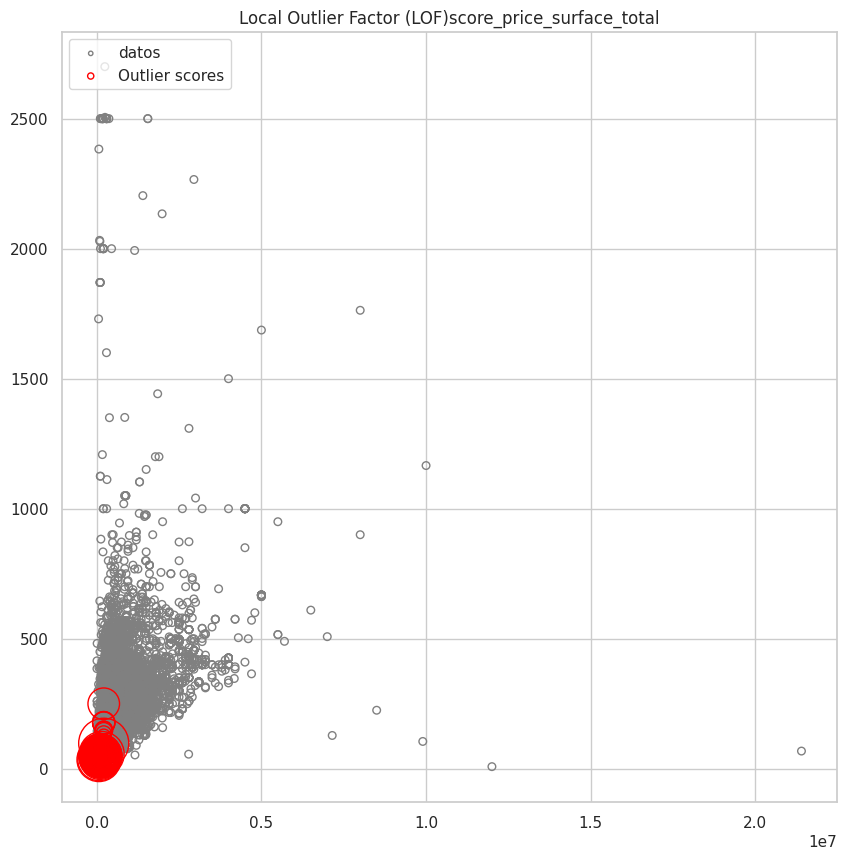

In [480]:
lof(ds_lof, 'property_price', 'property_surface_total', 'score_price_surface_total')

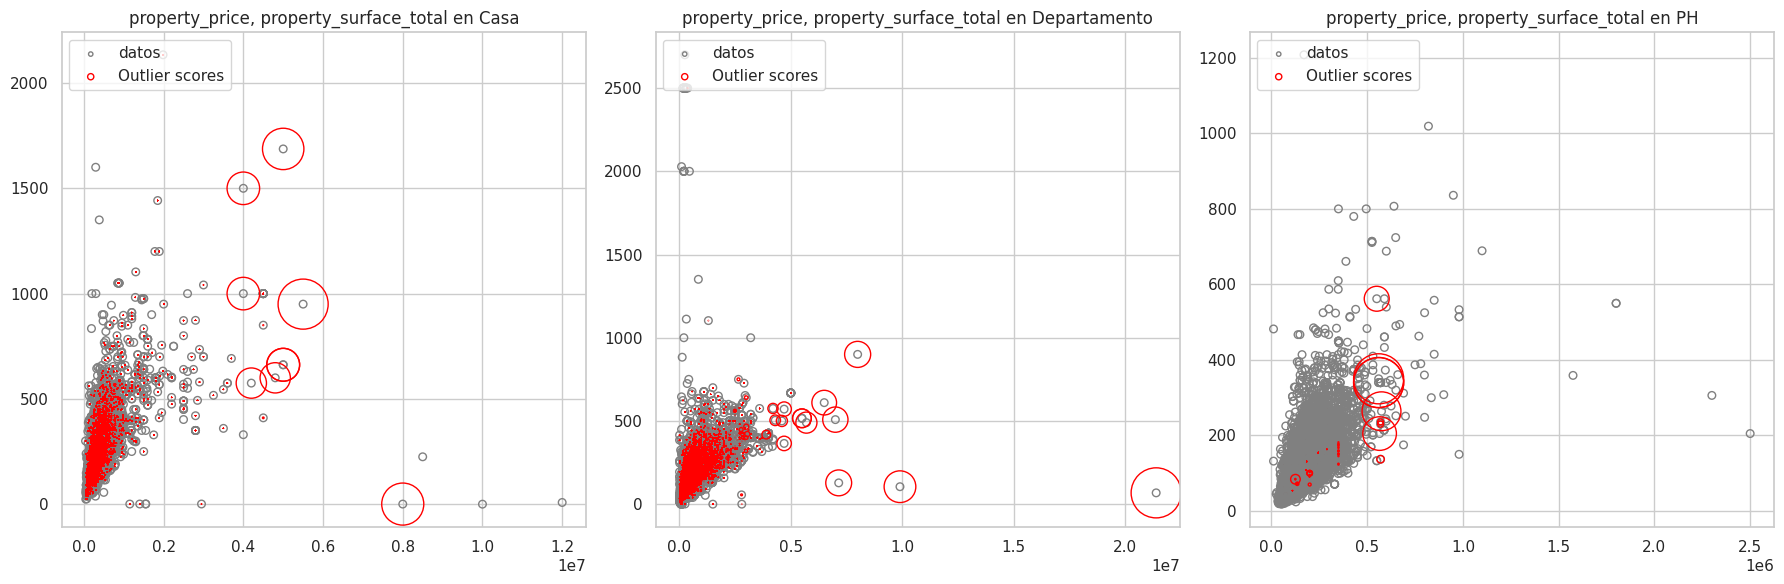

In [481]:
lof_segun_tipo(ds_propiedades_filtradas, 'property_price', 'property_surface_total', 'score_price_surface_total')

Si bien no se detectan como anomalías por LOF, vemos algunas situaciones extrañas en el gráfico y las analizamos.

In [482]:
# Propiedad demasiado barata para la superficie total
ds_propiedades_filtradas[((ds_propiedades_filtradas['property_price'] < 290000) & (ds_propiedades_filtradas['property_surface_total'] > 1000))]

id start_date    end_date    latitud   longitud  \
34113   TOICJnvvamy4J2bHIyfZAQ== 2021-02-08  2021-03-04 -34.554356 -58.458076   
59206   nAlNswS6InJ4arizl/c9QQ== 2021-03-13  2021-03-16 -34.563005 -58.453674   
152387  5e2B9vTi0QYTdU/nsMPrnw== 2021-08-05  2021-08-08 -34.611826 -58.516024   
195264  8b+CSpRNOTjFl1WESiegUg== 2021-08-21  2021-08-27 -34.554356 -58.458076   
233704  xZtn7sYshWyoqpVg9tsNKw== 2021-03-20  2021-04-13 -34.611826 -58.516024   
313773  g0YOvd0iUVPj5i5/W5L67g== 2021-01-06  2021-01-09 -34.617067 -58.513585   
314533  72wVhxVSXrYVxWF0A0oMlQ== 2021-01-06  2021-01-09 -34.554356 -58.458076   
314537  z68hZQPtyGLxAbk4BXLzjA== 2021-01-06  2021-01-09 -34.554356 -58.458076   
314539  DE092uxcDdDlDnRTCLVKkQ== 2021-01-06  2021-01-09 -34.554356 -58.458076   
314739  GCATxme+VZNJyNX6WLwKuA== 2021-01-06  2021-01-09 -34.611826 -58.516024   
320899  adGY6/gjcj/MfuSQmZg7jw== 2021-09-03  2021-09-03 -34.554356 -58.458076   
336355  4WknGj7iBL7zrNCoaqjvVA== 2021-07-21  2021-08-08 -34.604284 -58.387255   
338138  w1MOQZvGtuxrsmEwmJIQ5w== 2021-04-13  2021-05-01 -34.611826 -58.516024   
381402  lqZf0l2vUD4iyYKmcL/Wwg== 2021-07-08  2021-07-18 -34.554356 -58.458076   
406839  MVyJD44kmd4b9RZca8TQLw== 2021-01-07  2021-01-08 -34.611826 -58.516024   

            place_l3 property_type  property_rooms  property_bedrooms  \
34113       Belgrano  Departamento             2.0                1.0   
59206       Belgrano  Departamento             3.0                2.0   
152387  Villa Devoto  Departamento             3.0                2.0   
195264      Belgrano  Departamento             2.0                1.0   
233704  Villa Devoto  Departamento             3.0                2.0   
313773  Villa Devoto            PH             4.0                2.0   
314533      Belgrano  Departamento             3.0                2.0   
314537      Belgrano  Departamento             2.0                1.0   
314539      Belgrano  Departamento             2.0                1.0   
314739  Villa Devoto  Departamento             3.0                2.0   
320899      Belgrano  Departamento             2.0                1.0   
336355     Monserrat  Departamento             3.0                2.0   
338138  Villa Devoto  Departamento             3.0                2.0   
381402      Belgrano  Departamento             2.0                1.0   
406839  Villa Devoto  Departamento             3.0                2.0   

        property_surface_total  property_surface_covered  property_price  \
34113                   2500.0                      51.0        189850.0   
59206                   2500.0                      66.0        289500.0   
152387                  2000.0                      61.0        189400.0   
195264                  2500.0                      51.0        164900.0   
233704                  2000.0                      62.0        204700.0   
313773                  1208.0                      90.0        170000.0   
314533                  2700.0                      63.0        244750.0   
314537                  2500.0                      51.0        199000.0   
314539                  2500.0                      51.0        181990.0   
314739                  2000.0                      62.0        204700.0   
320899                  2500.0                      51.0        159000.0   
336355                  2028.0                      68.0         95000.0   
338138                  2000.0                      62.0        204700.0   
381402                  2500.0                      51.0        164900.0   
406839                  2000.0                      59.0        193400.0   

        z_property_bedrooms  zm_property_bedrooms  place_encoded  type_encoded  
34113             -0.897058             -0.897058              6             1  
59206              0.110798              0.110798              6             1  
152387             0.110798              0.110798             45             1  
195264            -0.89

Son casi todos casos de Departamento. Viendo las variables, el error parecería estar en la superficie y no en el precio. Normalizamos estos casos.

In [483]:
ds_propiedades_filtradas[((ds_propiedades_filtradas['property_price'] < 290000) & (ds_propiedades_filtradas['property_surface_total'] > 1000))]

# Determinamos las variables a normalizar y aplicamos MinMaxScaler
variables = filtrado[['property_price', 'property_surface_total']]
scaler = MinMaxScaler()
normalizadas = scaler.fit_transform(variables)


filtrado[['property_price', 'property_surface_total']] = normalizadas
ds_propiedades_filtradas.update(filtrado)

In [484]:
ds_lof.sort_values(by='score_price_surface_total', ascending=False)

id start_date    end_date    latitud   longitud  \
178393  a+mWBecW/t3IjeUVU+79ug== 2021-03-23  2021-06-05 -34.597598 -58.426630   
277361  zHso1NOZMzoFFA0SrcU+Zw== 2021-12-23  2022-03-25 -34.565457 -58.465499   
91925   fbAhrDgmPhb6OCZeW8COvA== 2021-08-03  2021-12-24 -34.547976 -58.463136   
379670  jNC3OJk0DAiniHio8gOUFA== 2021-05-19  2021-06-05 -34.571320 -58.441659   
149650  Hf1XdOCUIZMBd/BBNAiPOQ== 2021-05-12  2021-05-19 -34.593412 -58.404710   
...                          ...        ...         ...        ...        ...   
452635  JSXjynhGriLEYid2qEuPlw== 2021-12-16  2022-02-09 -34.616893 -58.442931   
16702   BvsYvWcDGLHlOu5yXFA2GQ== 2021-06-10  2021-06-22 -34.547277 -58.469756   
455239  fOV5F8KeXarxFMSY8t9y6w== 2021-12-16  2022-02-09 -34.628923 -58.408985   
452345  4Bs/wLipX8W1HCJMisqoPA== 2021-12-16  2022-02-09 -34.552255 -58.482840   
115179  kjhveUE+S+Quextr/6MFUg== 2021-12-07  2022-01-27 -34.614531 -58.443807   

             place_l3 property_type  property_rooms  property_bedrooms  \
178393   Villa Crespo  Departamento             2.0                1.0   
277361       Belgrano  Departamento             2.0                1.0   
91925           Nuñez  Departamento             2.0                1.0   
379670       Belgrano  Departamento             2.0                1.0   
149650   Barrio Norte  Departamento             3.0                2.0   
...               ...           ...             ...                ...   
452635      Caballito  Departamento             1.0                1.0   
16702           Nuñez  Departamento             2.0                1.0   
455239  San Cristobal  Departamento             1.0                1.0   
452345       Saavedra  Departamento             2.0                1.0   
115179      Caballito            PH             3.0                2.0   

        property_surface_total  property_surface_covered  property_price  \
178393                    56.0                      46.0        159000.0   
277361                    56.0                      45.0        159000.0   
91925                     56.0                      41.0        159000.0   
379670                    56.0                      41.0        159000.0   
149650                    56.0                      54.0        159000.0   
...                        ...                       ...             ...   
452635                    47.0                      39.0        115248.0   
16702                     47.0                      41.0        110300.0   
455239                    35.0                      31.0         65200.0   
452345                    57.0                      50.0        150490.0   
115179                    98.0                      95.0        211500.0   

        z_property_bedrooms  zm_property_bedrooms  place_encoded  \
178393            -0.897058             -0.897058             44   
277361            -0.897058             -0.897058              6   
91925             -0.897058             -0.897058             24   
379670            -0.897058             -0.897058              6   
149650             0.110798              0.110798              5   
...                     ...                   ...            ...   
452635            -0.897058             -0.897058              9   
16702             -0.897058             -0.897058             24   
455239            -0.897058             -0.897058             38   
452345            -0.897058             -0.897058             37   
115179             0.110798              0.110798              9   

        type_encoded  score_property_surface  score_price_surface_total  
178393             1           -1.000000e+00              -8.296703e-01  
277361             1           -4.000000e+09              -8.296703e-01  
91925              1           -1.000000e+00              -8.296703e-01  
379670             1           -1.000000e+00              -8.296703e-01  
149650             1           -1.000000e+00              -8.296703e

Lo que el score arrojado como LOF nos indica como outlier no parecería serlo a primera vista. Probamos igualmente

In [485]:
umbral = -1.5
# Filtrar las filas donde el valor de 'score_price_surface_total' es menor que el umbral
ds_lof[ds_lof['score_price_surface_total'] < umbral]


id start_date    end_date    latitud   longitud  \
49      vuX/ccLAMVml4qWRFcOJUA== 2021-09-09  2022-01-05 -34.610027 -58.401934   
58      tgaK6Ibor1zLY5bvNxsXfw== 2021-09-09  2021-09-26 -34.633730 -58.424729   
299     fWyBppiSbXhNSIjAmVDULg== 2021-09-09  2021-09-26 -34.597934 -58.376981   
305     KtZKt6J2m8yZ/iXRZYOYhw== 2021-09-09  2022-01-27 -34.608718 -58.418619   
395     SD2sSijPm7YXDWFdHatApQ== 2021-09-09  2022-03-09 -34.640498 -58.529040   
...                          ...        ...         ...        ...        ...   
459928  9F/sbqlrzng2Htc2U/xd6A== 2021-01-05  9999-12-31 -34.592192 -58.407731   
459972  dyv9BTo0JhAdZCa7yGo+Dw== 2021-01-05  2021-01-10 -34.624115 -58.377084   
460004  qoRmq/YnfYMQJSTTmVzp9w== 2021-01-05  2021-06-05 -34.617002 -58.362842   
460010  uuBjBTUABJDJ+kDPiN808Q== 2021-01-05  2021-01-06 -34.622961 -58.393313   
460066  6jIQwemq6hMLyB3vfivamA== 2021-01-05  2021-06-05 -34.632484 -58.432932   

                place_l3 property_type  property_rooms  property_bedrooms  \
49                  Once  Departamento             4.0           2.000000   
58                 Boedo          Casa            10.0           2.302585   
299               Retiro  Departamento             1.0           1.000000   
305              Almagro  Departamento             3.0           2.000000   
395              Liniers  Departamento             3.0           2.000000   
...                  ...           ...             ...                ...   
459928      Barrio Norte  Departamento             4.0           3.000000   
459972      Constitución  Departamento             2.0           1.000000   
460004     Puerto Madero  Departamento             2.0           1.000000   
460010     San Cristobal  Departamento             2.0           1.000000   
460066  Parque Chacabuco  Departamento             3.0           2.000000   

        property_surface_total  property_surface_covered  property_price  \
49                       131.0                     104.0        146000.0   
58                       394.0                     244.0        500000.0   
299                       14.0                      14.0         45200.0   
305                      110.0                      85.0        137000.0   
395                       66.0                      60.0         84900.0   
...                        ...                       ...             ...   
459928                   154.0                     154.0        429000.0   
459972                    40.0                      37.0         70000.0   
460004                    60.0                      50.0        302000.0   
460010                    49.0                      49.0         68900.0   
460066                   102.0                      76.0        129000.0   

        z_property_bedrooms  zm_property_bedrooms  place_encoded  \
49                 0.110798              0.110798             25   
58                 0.415761              0.415761              8   
299               -0.897058             -0.897058             36   
305                0.110798              0.110798              2   
395                0.110798              0.110798             20   
...                     ...                   ...            ...   
459928             1.118655              1.118655              5   
459972            -0.897058             -0.897058             16   
460004            -0.897058             -0.897058             34   
460010            -0.897058             -0.897058             38   
460066             0.110798              0.110798             29   

        type_encoded  score_property_surface  score_price_surface_total  
49                 1           -1.190997e+00              -2.108570e+00  
58                 0           -1.038832e+00              -2.933631e+00  
299                1           -1.179200e+00              -6.771899e+01  
305                1           -9.893192e-01              -3.034101e+00  
395                1           -

Estableciendo un umbral de -1.5, podemos ver 14166 filas consideradas 'outliers'. No solo eso, sino que a primera vista no parecerían serlo. Probamos normalizandolas y graficando a ver si encontramos alguna mejora.



In [486]:
columnas_a_normalizar=['property_price', 'property_surface_total']
ds_lof[columnas_a_normalizar] = scaler.fit_transform(ds_lof[columnas_a_normalizar])

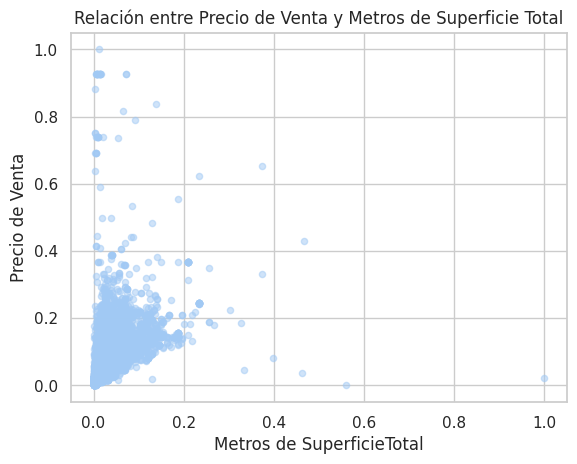

In [487]:
ds_lof.plot.scatter(y='property_surface_total', x='property_price', alpha=0.5)
plt.title('Relación entre Precio de Venta y Metros de Superficie Total')
plt.xlabel('Metros de SuperficieTotal')
plt.ylabel('Precio de Venta')
plt.grid(True)
plt.show()

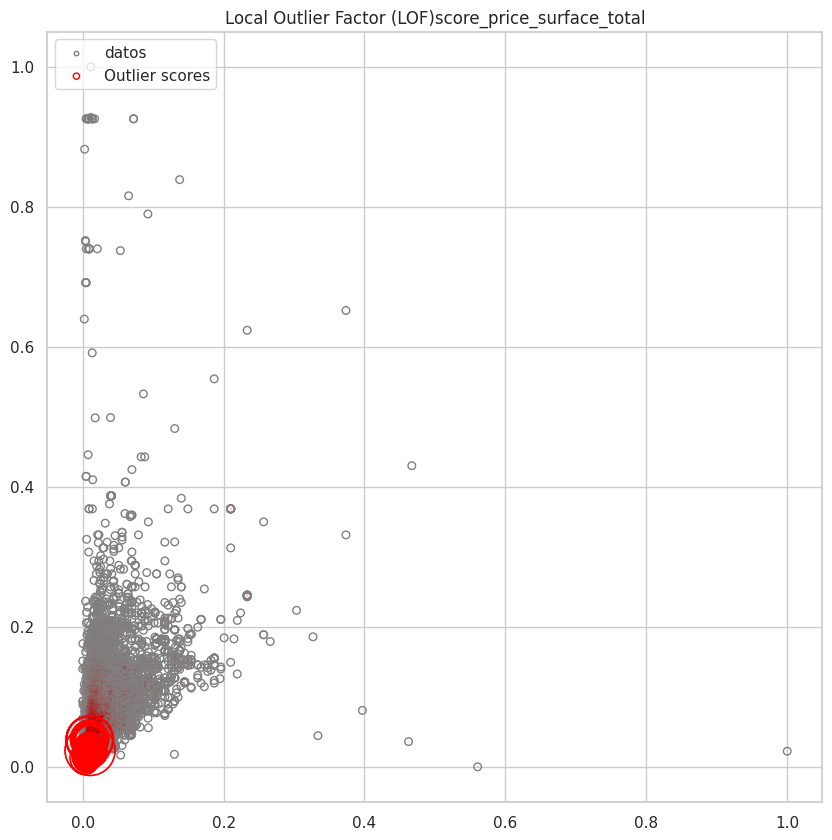

In [488]:
lof(ds_lof, 'property_price', 'property_surface_total', 'score_price_surface_total')

No se ve una mejora notoría, sino la concentración aún más de los outliers en una ubicación que no tiene sentido. Teniendo eso en cuenta y que los datos parecen normales a simple vista, los dejaremos como estaban, excepto los casos particulares ya expuestos.

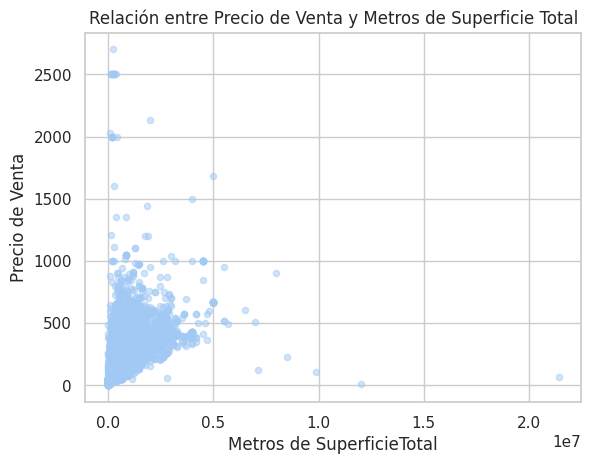

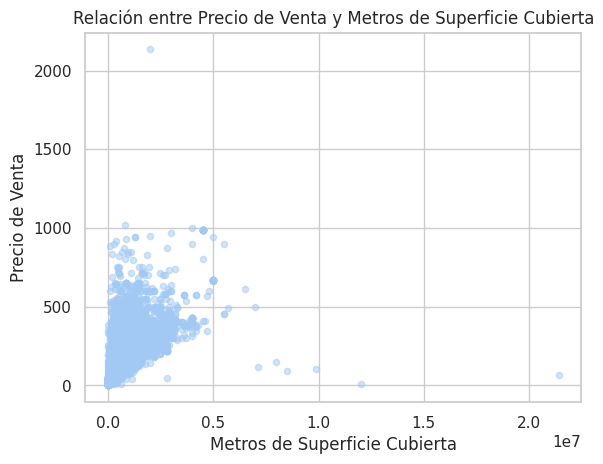

In [489]:
ds_propiedades_filtradas.plot.scatter(y='property_surface_total', x='property_price', alpha=0.5)
plt.title('Relación entre Precio de Venta y Metros de Superficie Total')
plt.xlabel('Metros de SuperficieTotal')
plt.ylabel('Precio de Venta')
plt.grid(True)
plt.show()


ds_propiedades_filtradas.plot.scatter(y='property_surface_covered', x='property_price', alpha=0.5)
plt.title('Relación entre Precio de Venta y Metros de Superficie Cubierta')
plt.xlabel('Metros de Superficie Cubierta')
plt.ylabel('Precio de Venta')
plt.grid(True)
plt.show()

###### Ubicación vs Precio

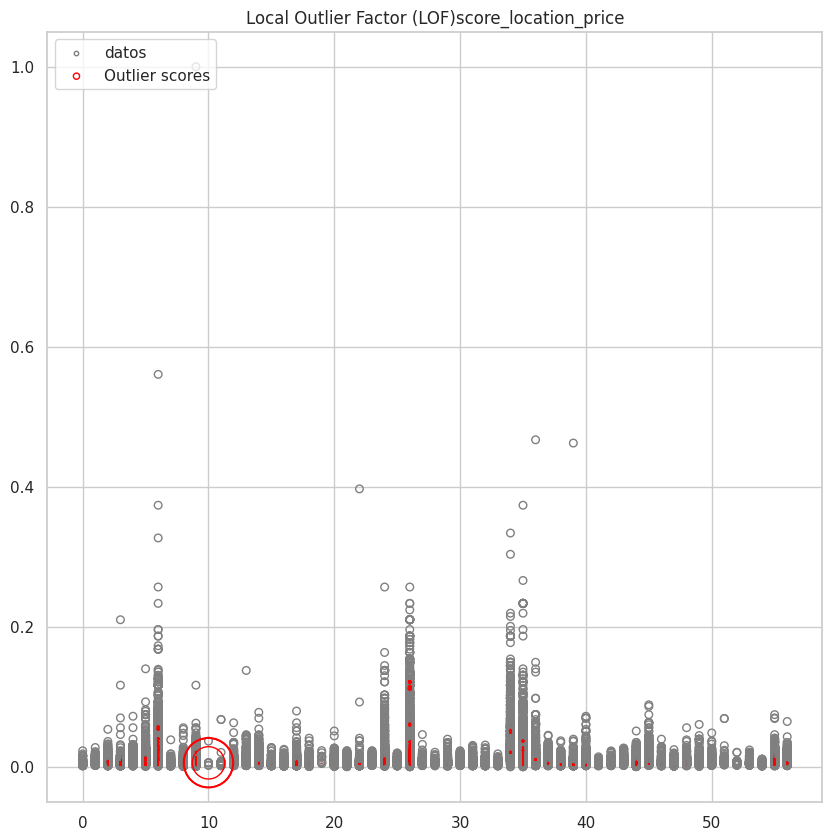

In [490]:
lof(ds_lof, 'place_encoded', 'property_price', 'score_location_price')

### Redondeo de rooms/bedrooms

Finalmente notamos que las habitaciones y ambientes tienen un tipo de dato Float (numeros con decimales) cosa que es imposible y no representan los datos reales (no se puede tener una fraccion de habitacion). Por lo tanto arreglamos esto redondeando dichas columnas.

In [491]:
ds_propiedades_filtradas.head()

id start_date    end_date    latitud   longitud  \
42  d3Z0MblSb2IMBoOBMGJEEQ== 2021-09-09  2021-09-26 -34.637319 -58.361124   
43  rL7qPkQnomsMGu2ViS3sBw== 2021-09-09  2021-09-28 -34.628647 -58.361871   
49  vuX/ccLAMVml4qWRFcOJUA== 2021-09-09  2022-01-05 -34.610027 -58.401934   
51  ZTtSCeqZ3HUgf5jjwEzRcw== 2021-09-09  2022-03-09 -34.631621 -58.416825   
53  3XhGN1xIqtzxywrDb3vC/w== 2021-09-09  2022-01-27 -34.623886 -58.412746   

       place_l3 property_type  property_rooms  property_bedrooms  \
42  San Nicolás  Departamento             3.0                2.0   
43     Belgrano  Departamento             4.0                3.0   
49         Once  Departamento             4.0                2.0   
51        Boedo            PH             4.0                2.0   
53        Boedo            PH             2.0                1.0   

    property_surface_total  property_surface_covered  property_price  \
42                    58.0                      55.0         82900.0   
43                    70.0                      70.0         99000.0   
49                   131.0                     104.0        146000.0   
51                   104.0                      73.0        250000.0   
53                    61.0                      46.0        100000.0   

    z_property_bedrooms  zm_property_bedrooms  place_encoded  type_encoded  
42             0.110798              0.110798             39             1  
43             1.118655              1.118655              6             1  
49             0.110798              0.110798             25             1  
51             0.110798              0.110798              8             2  
53            -0.897058             -0.897058              8             2

In [492]:
# Redondeamos rooms y bedrooms
ds_propiedades_filtradas['property_rooms'] = np.round(ds_propiedades_filtradas['property_rooms']).astype(int)
ds_propiedades_filtradas['property_bedrooms'] = np.round(ds_propiedades_filtradas['property_bedrooms']).astype(int)

# Guardado de train y test Datasets

In [493]:
# Primero borro columnas que ya no seran usadas
to_remove = ['z_property_bedrooms', 'zm_property_bedrooms', 'place_encoded', 'type_encoded']
ds_propiedades_filtradas.drop(columns=to_remove, inplace=True)

# Division Training y Testing set

In [494]:
# Dividir el dataset en conjuntos de entrenamiento y prueba
ds_train, ds_test = train_test_split(ds_propiedades_filtradas, train_size=0.8, random_state=42) # random state para usar misma semilla siempre
print("Propiedades para entrenar:", len(ds_train))
print("Propiedades para testear:", len(ds_test))

Propiedades para entrenar: 72216
Propiedades para testear: 18054


In [495]:
if using_drive:
  ds_train.to_csv(drive_path + "/Dataset/ds_train.csv", index=False)
  ds_test.to_csv(drive_path + "/Dataset/ds_test.csv", index=False)
else:
  ds_train.to_csv("./dataset/ds_train.csv", index=False)
  ds_test.to_csv("./dataset/ds_test.csv", index=False)